No GPU available, using the CPU instead.


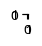

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

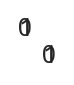

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

In [4]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


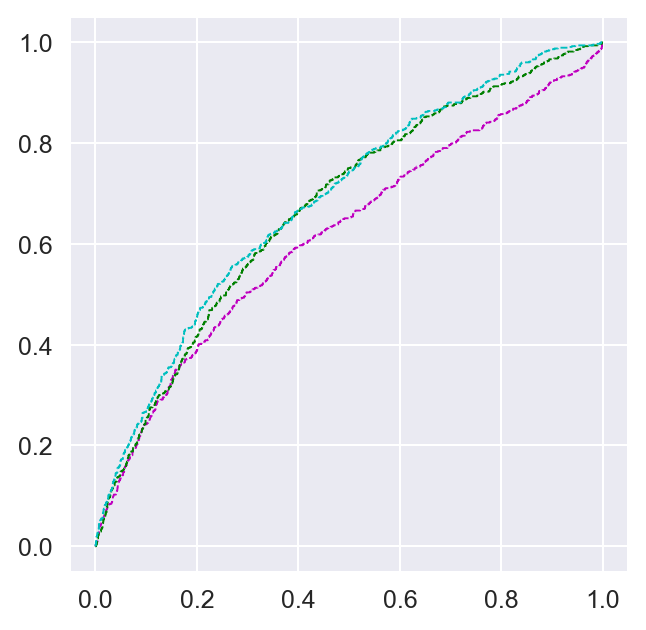

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
prime_related.columns.difference(prime_related_baseline.columns)

Index(['Allele', 'IEDB', 'Immunogenicity', 'MixMHCpred', 'NetMHCpanEL',
       'NetMHCpanEL_WT', 'PRIME', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point'],
      dtype='object')

# Redefine anchor/netmhcpan for old dump

## reading

In [8]:
cedar_related_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
print(len(cedar_related_fold))
cedar_related_fold.head()

3033


Peptide    wild_type  len        HLA  trueHLA_EL_rank  wt_EL_rank  \
0  AAAAAAQQIQV  AAAAAAQQLQV   11  HLA-B0702          26.7692     25.5667   
1    AAAAQQIQV    AAAAQQLQV    9  HLA-A0201           1.9555      2.2847   
2    AAAAQQIQV    AAAAQQLQV    9  HLA-B0702           4.9092      4.7746   
3    AAHFTVLLY    AAHFTALLY    9  HLA-A1101           0.4196      0.5881   
4    AAIAASRSV    AAIAASRSA    9  HLA-C1203           0.0591      1.1729   

   ratio_rank  fold  agg_label     binder  ...  mhc_anchor percentage_pos  \
0    0.955079     6          0  Conserved  ...         1,8            0.0   
1    1.168346     6          0  Conserved  ...       1,3,8            0.0   
2    0.972582     6          0  Conserved  ...         1,8            0.0   
3    1.401573     8          0  Conserved  ...       0,1,8            0.0   
4   19.846024     7          0   Improved  ...         1,8            0.0   

  pred_EL_rank  pred_EL_score    pred_HLA  responses  total_count trainset  \
0       5.2822         0.0166  HLA-A68:02   Negative            1    cedar   
1       0.1036         0.6567  HLA-C15:02   Negative            1    cedar   
2       0.1036         0.6567  HLA-C15:02   Negative            1    cedar   
3       0.0256         0.8170  HLA-A30:02   Negative            1    cedar   
4       0.0591         0.6191  HLA-C12:03   Negative            1    cedar   

     wt_core  wt_true  
0  AAAAAQLQV     True  
1  AAAAQQLQV     True  
2  AAAAQQLQV     True  
3  AAHFTALLY     True  
4  AAIAASRSA     True  

[5 rows x 45 columns]

## Writing into ""fasta"" file

In [9]:
','.join(sorted(cedar_related_fold.HLA_full.unique()))

'HLA-A*01:01,HLA-A*02:01,HLA-A*02:02,HLA-A*02:03,HLA-A*02:05,HLA-A*02:06,HLA-A*02:10,HLA-A*02:11,HLA-A*02:24,HLA-A*03:01,HLA-A*03:02,HLA-A*11:01,HLA-A*11:02,HLA-A*24:02,HLA-A*25:01,HLA-A*26:01,HLA-A*29:02,HLA-A*30:01,HLA-A*30:02,HLA-A*31:01,HLA-A*33:01,HLA-A*68:01,HLA-A*68:02,HLA-A*69:01,HLA-B*07:02,HLA-B*08:01,HLA-B*13:02,HLA-B*15:01,HLA-B*18:01,HLA-B*27:05,HLA-B*35:01,HLA-B*35:03,HLA-B*37:01,HLA-B*37:04,HLA-B*38:01,HLA-B*39:01,HLA-B*39:06,HLA-B*40:01,HLA-B*40:02,HLA-B*41:02,HLA-B*44:02,HLA-B*44:03,HLA-B*44:08,HLA-B*49:01,HLA-B*51:01,HLA-B*52:01,HLA-B*54:01,HLA-B*56:01,HLA-B*57:01,HLA-C*01:02,HLA-C*03:03,HLA-C*03:04,HLA-C*04:01,HLA-C*05:01,HLA-C*06:02,HLA-C*07:01,HLA-C*07:02,HLA-C*08:02,HLA-C*12:02,HLA-C*12:03,HLA-C*14:02,HLA-C*14:03,HLA-C*15:02'

In [13]:
f_mut = open('../../../netmhcpan/cedar_related_mut.fa', 'w')
f_wt = open('../../../netmhcpan/cedar_related_wt.fa', 'w')
cedar_related_fold['seq_id'] = [f'seq{i}' for i in range(1, len(cedar_related_fold)+1)]
for i, row in cedar_related_fold.iterrows():
    f_mut.writelines([f">{row['seq_id']}\n", f"{row['Peptide']}\n"])
    f_wt.writelines([f">{row['seq_id']}\n", f"{row['wild_type']}\n"])

f_mut.close()
f_wt.close()

In [427]:
','.join(sorted(prime_related_baseline.HLA.unique()))

'HLA-A0101,HLA-A0201,HLA-A0206,HLA-A0211,HLA-A0301,HLA-A1101,HLA-A2402,HLA-A2501,HLA-A2601,HLA-A2902,HLA-A3001,HLA-A3101,HLA-A3301,HLA-A6801,HLA-A6802,HLA-A6901,HLA-B0702,HLA-B0801,HLA-B1501,HLA-B1801,HLA-B2702,HLA-B2705,HLA-B3501,HLA-B3503,HLA-B3701,HLA-B3801,HLA-B3901,HLA-B3906,HLA-B4001,HLA-B4102,HLA-B4402,HLA-B4403,HLA-B4901,HLA-B5101,HLA-B5601,HLA-B5701,HLA-C0102,HLA-C0303,HLA-C0304,HLA-C0401,HLA-C0501,HLA-C0602,HLA-C0701,HLA-C0702,HLA-C0802,HLA-C1203,HLA-C1403,HLA-C1502'

In [89]:
f_mut = open('./prime_related_mut.fa', 'w')
f_wt = open('./prime_related_wt.fa', 'w')
prime_related_baseline['seq_id'] = [f'seq_{i}' for i in range(1, len(prime_related_baseline)+1)]
for i, row in prime_related_baseline.iterrows():
    f_mut.writelines([f">{row['seq_id']}\n", f"{row['Peptide']}\n"])
    f_wt.writelines([f">{row['seq_id']}\n", f"{row['wild_type']}\n"])

f_mut.close()
f_wt.close()

In [90]:
os.listdir()

['prime_related_mut.fa',
 'df_switch.csv',
 'data_parsing_prep.ipynb',
 '220916_Mutation_checks.ipynb',
 '.DS_Store',
 'nn_explo.ipynb',
 'ml_explo.ipynb',
 '220915_CEDAR_meeting.ipynb',
 'feature_correlation.ipynb',
 'trained_models',
 '221003_rebalance_dataset_bootstrappingUntitled.ipynb',
 'tuning_results_redo.ipynb',
 'tuning_results.ipynb',
 'nn_ml_traineval_scratchpad.ipynb',
 'prime_related_wt.fa',
 '2210xx_redefine_mutscores_binders.ipynb',
 '_old',
 '220911_bootstrap_evaluate.ipynb',
 '.ipynb_checkpoints',
 'anchors.ipynb',
 '220926_mut_wt_CNN.ipynb',
 'df_related_updated_mutcols_rank.csv',
 'data_partition.ipynb',
 '221010_various_things.ipynb']

## Parsing xls

In [14]:
ss = ['AEAERLDVKAI','AALHTPRPGPL']
test = cedar_related_fold.query('Peptide in @ss').reset_index(drop=True)
test=test.replace('HLA-B4403', 'HLA-A0201')
test['seq_id'] = ['seq2', 'seq1']
test = test[['Peptide', 'HLA', 'seq_id']]
test

Peptide        HLA seq_id
0  AALHTPRPGPL  HLA-B0702   seq2
1  AEAERLDVKAI  HLA-A0201   seq1

In [829]:
# Ranks stuff
from src.utils import read_netmhcpan_results, flatten_level_columns
from src.utils import get_trueHLA_EL_rank
test_xls = read_netmhcpan_results('../data/test.xls')
test_xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in test_xls.columns])
display(test_xls)
# display(flatten_level_columns(test_xls.head()))

base                         A0201                                 \
    Pos      Peptide    ID       core        icore EL-score  EL_Rank   
0     0  AEAERLDVKAI  seq1  AEAEDVKAI  AEAERLDVKAI   0.0003  30.1364   
1     0   AEAERLDVKA  seq1  AEAERLVKA   AEAERLDVKA   0.0005  24.1458   
2     1   EAERLDVKAI  seq1  EAERLDVAI   EAERLDVKAI   0.0001  50.0000   
3     0    AEAERLDVK  seq1  AEAERLDVK    AEAERLDVK   0.0002  35.7692   
4     1    EAERLDVKA  seq1  EAERLDVKA    EAERLDVKA   0.0001  48.4000   
5     2    AERLDVKAI  seq1  AERLDVKAI    AERLDVKAI   0.0004  26.6316   
6     0     AEAERLDV  seq1  AEAERLD-V     AEAERLDV   0.0000  55.4545   
7     1     EAERLDVK  seq1  EA-ERLDVK     EAERLDVK   0.0000  80.0000   
8     2     AERLDVKA  seq1  AER-LDVKA     AERLDVKA   0.0000  76.6667   
9     3     ERLDVKAI  seq1  ERLDVK-AI     ERLDVKAI   0.0000  70.0000   
10    0  AALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0005  23.6182   
11    0   AALHTPRPGP  seq2  ALHTPRPGP   AALHTPRPGP   0.0009  18.6532   
12    1   ALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0229   4.4505   
13    0    AALHTPRPG  seq2  AALHTPRPG    AALHTPRPG   0.0000  65.0000   
14    1    ALHTPRPGP  seq2  ALHTPRPGP    ALHTPRPGP   0.0065   8.1856   
15    2    LHTPRPGPL  seq2  LHTPRPGPL    LHTPRPGPL   0.0001  45.0000   
16    0     AALHTPRP  seq2  AALH-TPRP     AALHTPRP   0.0000  52.3333   
17    1     ALHTPRPG  seq2  ALHTPRPG-     ALHTPRPG   0.0001  43.2857   
18    2     LHTPRPGP  seq2  -LHTPRPGP     LHTPRPGP   0.0000  67.5000   
19    3     HTPRPGPL  seq2  HTPRPGP-L     HTPRPGPL   0.0002  30.3636   

        B0702                                    end     
         core        icore EL-score  EL_Rank     Ave NB  
0   AEAEDVKAI  AEAERLDVKAI   0.0003  25.4667  0.0003  0  
1   AEAERLVKA   AEAERLDVKA   0.0001  34.9091  0.0003  0  
2   EARLDVKAI   EAERLDVKAI   0.0010  15.0148  0.0005  0  
3   AEAERLDVK    AEAERLDVK   0.0002  29.8235  0.0002  0  
4   EAERLDVKA    EAERLDVKA   0.0001  35.2222  0.0001  0  
5   AERLDVKAI    AERLDVKAI   0.0037   8.2857  0.0020  0  
6   AEAERLD-V     AEAERLDV   0.0001  35.3333  0.0001  0  
7   EA-ERLDVK     EAERLDVK   0.0000  63.5714  0.0000  0  
8   AER-LDVKA     AERLDVKA   0.0001  48.7500  0.0000  0  
9   ERLDVK-AI     ERLDVKAI   0.0002  31.7333  0.0001  0  
10  AALPRPGPL  AALHTPRPGPL   0.0143   4.2778  0.0074  0  
11  AAHTPRPGP   AALHTPRPGP   0.0002  29.1765  0.0006  0  
12  ALHTPRPPL   ALHTPRPGPL   0.0383   2.5335  0.0306  0  
13  AALHTPRPG    AALHTPRPG   0.0002  27.7143  0.0001  0  
14  ALHTPRPGP    ALHTPRPGP   0.0016  12.1949  0.0041  0  
15  LHTPRPGPL    LHTPRPGPL   0.0095   5.2754  0.0048  0  
16  AALHTPRP-     AALHTPRP   0.0000  49.6667  0.0000  0  
17  ALHTPRPG-     ALHTPRPG   0.0001  35.8889  0.0001  0  
18  LHT-PRPGP     LHTPRPGP   0.0001  44.2500  0.0000  0  
19  HT-PRPGPL     HTPRPGPL   0.0116   4.7653  0.0059  0

In [16]:
read_netmhcpan_results('../data/netmhcpan_xls/cedar_neoepitope_220701.pep.xls')

base                       HLA-A01:01                                 \
      Pos      Peptide       ID       core        icore EL-score  EL_Rank   
0       0  AAAAAAQQIQV  PEPLIST  AAAAQQIQV  AAAAAAQQIQV   0.0004  32.1364   
1       0    AAAAQQIQV  PEPLIST  AAAAQQIQV    AAAAQQIQV   0.0041   8.1173   
2       0    AAAAQQIQV  PEPLIST  AAAAQQIQV    AAAAQQIQV   0.0041   8.1173   
3       0    AAFIWIISM  PEPLIST  AAFIWIISM    AAFIWIISM   0.0008  21.3065   
4       0    AAHFTVLLY  PEPLIST  AAHFTVLLY    AAHFTVLLY   0.4940   0.2990   
...   ...          ...      ...        ...          ...      ...      ...   
3475    0    YYPGKKEPF  PEPLIST  YYPGKKEPF    YYPGKKEPF   0.0018  13.2248   
3476    0   YYPPSQIAQL  PEPLIST  YYPPSQIQL   YYPPSQIAQL   0.0062   6.4498   
3477    0    YYSKNLNSF  PEPLIST  YYSKNLNSF    YYSKNLNSF   0.0248   2.9724   
3478    0   YYSKNLNSFF  PEPLIST  YSKNLNSFF   YYSKNLNSFF   0.0105   4.7605   
3479    0    YYSPQAQTL  PEPLIST  YYSPQAQTL    YYSPQAQTL   0.0197   3.3635   

                       HLA-A02:01                                          \
     BA-score  BA_Rank       core        icore EL-score  EL_Rank BA-score   
0      0.0281  54.9135  AAAAAQIQV  AAAAAAQQIQV   0.0030  11.4508   0.1003   
1      0.0623  16.3410  AAAAQQIQV    AAAAQQIQV   0.0949   1.9555   0.1977   
2      0.0623  16.3410  AAAAQQIQV    AAAAQQIQV   0.0949   1.9555   0.1977   
3      0.0455  28.5503  AAFIWIISM    AAFIWIISM   0.0126   6.0285   0.1958   
4      0.3875   0.3793  AAHFTVLLY    AAHFTVLLY   0.0007  20.7816   0.0574   
...       ...      ...        ...          ...      ...      ...      ...   
3475   0.0266  58.0991  YYPGKKEPF    YYPGKKEPF   0.0007  20.8966   0.0314   
3476   0.0406  34.2798  YYPPSIAQL   YYPPSQIAQL   0.0034  10.9311   0.0880   
3477   0.0823   9.5915  YYSKNLNSF    YYSKNLNSF   0.0015  15.4400   0.0649   
3478   0.1458   3.1834  YYSNLNSFF   YYSKNLNSFF   0.0001  39.8889   0.0695   
3479   0.0598  17.6094  YYSPQAQTL    YYSPQAQTL   0.0303   3.8684   0.1128   

              HLA-A02:02                                                   \
      BA_Rank       core        icore EL-score  EL_Rank BA-score  BA_Rank   
0     22.2007  AAAAAQIQV  AAAAAAQQIQV   0.0069  11.9673   0.1528  21.9860   
1     10.5015  AAAAQQIQV    AAAAQQIQV   0.1904   1.7747   0.3138   8.5357   
2     10.5015  AAAAQQIQV    AAAAQQIQV   0.1904   1.7747   0.3138   8.5357   
3     10.6309  AAFIWIISM    AAFIWIISM   0.0112   9.7216   0.1743  19.0436   
4     36.7439  AAHFTVLLY    AAHFTVLLY   0.0007  28.9722   0.0580  50.3604   
...       ...        ...          ...      ...      ...      ...      ...   
3475  57.6543  YYPGKKEPF    YYPGKKEPF   0.0010  26.0000   0.0470  57.6181   
3476  25.1923  YYPPSIAQL   YYPPSQIAQL   0.0142   8.6594   0.1610  20.8240   
3477  33.1425  YYSKNLNSF    YYSKNLNSF   0.0072  11.7987   0.1141  29.3706   
3478  31.2502  YYSKNNSFF   YYSKNLNSFF   0.0007  28.7500   0.1581  21.2369   
3479  19.7553  YYSPQAQTL    YYSPQAQTL   0.1068   2.7614   0.2031  15.8772   

     HLA-A02:03                                                  HLA-A02:05  \
           core        icore EL-score  EL_Rank BA-score  BA_Rank       core   
0     AAAAQQIQV  AAAAAAQQIQV   0.0035  11.9268   0.1566  20.0961  AAAAAQIQV   
1     AAAAQQIQV    AAAAQQIQV   0.1541   1.4611   0.3449   6.8050  AAAAQQIQV   
2     AAAAQQIQV    AAAAQQIQV   0.1541   1.4611   0.3449   6.8050  AAAAQQIQV   
3     AAFIWIISM    AAFIWIISM   0.0091   7.9066   0.1613  19.4895  AAFIWIISM   
4     AAHFTVLLY    AAHFTVLLY   0.0006  24.2456   0.0647  43.8329  AAHFTVLLY   
...         ...          ...      ...      ...      ...      ...        ...   
3475  YYPGKKEPF    YYPGKKEPF   0.0002  34.3158   0.0315  68.0120  YYPGKKEPF   
3476  YYPPSIAQL   YYPPSQIAQL   0.0037  11.7210   0.1172  26.8739  YYPPSIAQL   
3477  YYSKNLNSF    YYSKNLNSF   0.0036  11.7967   0.0994  31.2158  YYSKNLNSF   
3478  YYSKNLNSF   YYSKNLNSFF   0.0003  31.9259   0.1168  26.9714  YYSKNLNSF   
3479  YYSPQAQTL    YYSPQAQTL   0.0396   3.7396   0.

In [833]:
from src.utils import read_netmhcpan_results

def read_xls_parse_shift(filename):
    xls = read_netmhcpan_results(filename)
    xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in xls.columns])
    return xls

def parse_netmhcpan_shift(row, netmhc_xls):
    hla = row['HLA'].replace(':','').replace('HLA-','')
    # print(hla, row)
    seq_id = row['seq_id']
    tmp = netmhc_xls.query('@netmhc_xls.base.ID==@seq_id')
    tmp = tmp[[x for x in tmp.columns if x[0]==hla or x[0]=='base']]
    argmin = tmp.iloc[tmp[(hla, 'EL_Rank')].argmin()].droplevel(0).rename({'Peptide':'Peptide',
                                                                           'EL_Rank':'EL_rank'})
    try:
        return argmin.drop(['EL-score','ID'])
    
    except:
        print('here')
        return argmin['Pos'], argmin['Peptide'], argmin['core'], argmin['icore'], argmin['EL_Rank']
    
def pipeline_xls(df, xls_filename, xls_suffix):
    """
    Assumes df and XLS have the save seq_id for parsing
    """
    if type(xls_filename)==str:
        xls = read_xls_columns(xls_filename)
    elif type(xls_filename)==pd.DataFrame:
        xls = xls_filename
    merged_results = df.merge(df.apply(parse_netmhcpan_shift, netmhc_xls=xls,
                                        axis=1, result_type = 'expand').add_suffix(xls_suffix),
                              left_index=True, right_index=True)
    return merged_results

In [32]:
test.merge(test.apply(parse_netmhcpan_shift, netmhc_xls=test_xls, axis=1, result_type='expand'),
           left_index=True, right_index=True)

B0702 Peptide    AALHTPRPGPL
HLA          HLA-B0702
seq_id            seq2
Name: 0, dtype: object
A0201 Peptide    AEAERLDVKAI
HLA          HLA-A0201
seq_id            seq1
Name: 1, dtype: object


Peptide_x        HLA seq_id  Pos   Peptide_y       core       icore  \
0  AALHTPRPGPL  HLA-B0702   seq2    1  ALHTPRPGPL  ALHTPRPPL  ALHTPRPGPL   
1  AEAERLDVKAI  HLA-A0201   seq1    0  AEAERLDVKA  AEAERLVKA  AEAERLDVKA   

   EL_rank  
0   2.5335  
1  24.1458

In [55]:
# FOR CEDAR
# Read
cedar_mutant_xls = read_xls_parse('../data/netmhcpan_xls/cedar_related_mut.fa.xls')
cedar_wt_xls = read_xls_parse('../data/netmhcpan_xls/cedar_related_wt.fa.xls')
# Parse-merge
new_cedar_mut = pipeline_xls(cedar_related_fold, cedar_mutant_xls, xls_suffix='_mut')
new_cedar_wt = pipeline_xls(cedar_related_fold, cedar_wt_xls, xls_suffix='_wt')
# merged mut-wt
common_cols = [x for x in new_cedar_mut.columns if x in new_cedar_wt.columns]
related_merged = new_cedar_mut.merge(new_cedar_wt,
                                 left_on=common_cols,
                                 right_on=common_cols)

In [55]:
prime_related_baseline['seq_id'] = [f'seq_{i}' for i in range(1, len(prime_related_baseline)+1)]

In [91]:
# FOR PRIME
# Read
prime_mutant_xls = read_xls_parse_shift('../data/netmhcpan_xls/prime_related_mut.fa.xls')
prime_mutant_xls = prime_mutant_xls.query('not @prime_mutant_xls.base.Peptide.str.contains("X")', engine='python')
prime_wt_xls = read_xls_parse_shift('../data/netmhcpan_xls/prime_related_wt.fa.xls')
prime_wt_xls = prime_wt_xls.query('not @prime_wt_xls.base.Peptide.str.contains("X")', engine='python')
# Parse-merge
new_prime_mut = pipeline_xls(prime_related_baseline, prime_mutant_xls, xls_suffix='_mut')
new_prime_wt = pipeline_xls(prime_related_baseline, prime_wt_xls, xls_suffix='_wt')
# merged mut-wt
common_cols_prime = [x for x in new_prime_mut.columns if x in new_prime_wt.columns]
prime_baseline_merged = new_prime_mut.merge(new_prime_wt,
                                 left_on=common_cols_prime,
                                 right_on=common_cols_prime)

In [94]:
prime_baseline_merged

Peptide        HLA  trueHLA_EL_rank  agg_label       core  len  \
0      AAAAAAAAVL  HLA-B0702           3.6567          0  AAAAAAAAL   10   
1       AAAAAAAVL  HLA-B0702           0.9883          0  AAAAAAAVL    9   
2       AAAALHMQR  HLA-A1101           0.3609          0  AAAALHMQR    9   
3      AAAKAKNIPK  HLA-A0301           1.0865          0  AAAKKNIPK   10   
4      AAAPAVGPPL  HLA-B0702           1.4894          0  AAAPAGPPL   10   
...           ...        ...              ...        ...        ...  ...   
3104   YYCEVLPGEI  HLA-A2402           0.9916          0  YYCEVLPEI   10   
3105    YYCHWGYEV  HLA-A2402           0.4481          0  YYCHWGYEV    9   
3106    YYEDIKNDF  HLA-A2402           0.0940          0  YYEDIKNDF    9   
3107   YYNCAFTRNI  HLA-A2402           1.3054          0  YYNAFTRNI   10   
3108  YYNCAFTRNII  HLA-A2402           2.7750          0  YYAFTRNII   11   

        wild_type  wt_EL_rank mutation_type mutation_position  ...  Pos_mut  \
0      AAAAAAAAVI     13.1934  substitution                 9  ...        1   
1       AAAAAAAVI      3.9965  substitution                 8  ...        0   
2       AAAALHMLR      0.3717  substitution                 7  ...        0   
3      AAAKAKFIPK      0.8995  substitution                 6  ...        1   
4      AAATAVGPPL      3.0185  substitution                 3  ...        2   
...           ...         ...           ...               ...  ...      ...   
3104   YYREVLPGEI      1.2384  substitution                 2  ...        0   
3105    YYCHGGYEV      0.4865  substitution                 4  ...        0   
3106    YYEDIKKDF      0.1546  substitution                 6  ...        0   
3107   YYNRAFTRNI      0.7245  substitution                 3  ...        0   
3108  YYNRAFTRNII      1.2788  substitution                 3  ...        0   

     Peptide_mut   core_mut   icore_mut EL_rank_mut Pos_wt  Peptide_wt  \
0      AAAAAAAVL  AAAAAAAVL   AAAAAAAVL      0.9883      0   AAAAAAAAV   
1      AAAAAAAVL  AAAAAAAVL   AAAAAAAVL      0.9883      0   AAAAAAAVI   
2      AAAALHMQR  AAAALHMQR   AAAALHMQR      0.3609      0   AAAALHMLR   
3      AAKAKNIPK  AAKAKNIPK   AAKAKNIPK      0.6000      1   AAKAKFIPK   
4       APAVGPPL  APA-VGPPL    APAVGPPL      0.0897      1   AATAVGPPL   
...          ...        ...         ...         ...    ...         ...   
3104  YYCEVLPGEI  YYCEVLPEI  YYCEVLPGEI      0.9916      0  YYREVLPGEI   
3105   YYCHWGYEV  YYCHWGYEV   YYCHWGYEV      0.4481      0   YYCHGGYEV   
3106   YYEDIKNDF  YYEDIKNDF   YYEDIKNDF      0.0940      0   YYEDIKKDF   
3107  YYNCAFTRNI  YYNAFTRNI  YYNCAFTRNI      1.3054      0  YYNRAFTRNI   
3108  YYNCAFTRNI  YYNAFTRNI  YYNCAFTRNI      1.3054      0  YYNRAFTRNI   

        core_wt    icore_wt EL_rank_wt  
0     AAAAAAAAV   AAAAAAAAV     2.6958  
1     AAAAAAAVI   AAAAAAAVI     3.9965  
2     AAAALHMLR   AAAALHMLR     0.3717  
3     AAKAKFIPK   AAKAKFIPK     0.3640  
4     AATAVGPPL   AATAVGPPL     1.1108  
...         ...         ...        ...  
3104  YYREVLPEI  YYREVLPGEI     1.2384  
3105  YYCHGGYEV   YYCHGGYEV     0.4865  
3106  YYEDIKKDF   YYEDIKKDF     0.1546  
3107  YYNRAFTRI  YYNRAFTRNI     0.7245  
3108  YYNRAFTRI  YYNRAFTRNI     0.7245  

[3109 rows x 33 columns]

In [95]:
subcols = ['Peptide', 'wild_type', 'trueHLA_EL_rank', 'wt_EL_rank', 'EL_rank_mut', 'EL_rank_wt',
           'len', 'Peptide_mut','Peptide_wt', 'core_mut', 'core_wt', 'icore_mut','icore_wt']
related_merged[subcols]

NameError: name 'related_merged' is not defined

## Checks / stats

In [99]:
related_merged.loc[related_merged.core_wt.apply(len)!=9]

Empty DataFrame
Columns: [Peptide, wild_type, len, HLA, trueHLA_EL_rank, wt_EL_rank, ratio_rank, fold, agg_label, binder, anchor_mutation, mutation_position, mutation_type, mutation_score, blsm_mut_score, BA_rank, BA_score, HLA_full, PMIDs, Related Object_Ending Position, Related Object_Starting Position, core, core_mutation_position, delta_VHSE1, delta_VHSE3, delta_VHSE7, delta_VHSE8, delta_aliphatic_index, delta_boman, delta_hydrophobicity, delta_isoelectric_point, delta_rank, icore, label, len_wt, mhc_anchor, percentage_pos, pred_EL_rank, pred_EL_score, pred_HLA, responses, total_count, trainset, wt_core, wt_true, seq_id, Pos_mut, Peptide_mut, core_mut, icore_mut, EL_rank_mut, Pos_wt, Peptide_wt, core_wt, icore_wt, EL_rank_wt, lencore]
Index: []

In [101]:
related_merged.query('core_mut==core_wt')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

Peptide    wild_type  old_EL_rank_mut  old_EL_rank_wt  EL_rank_mut  \
22    AEWRNGSTSSL  PEWRNGSTSSL          27.1034         64.1667      24.2609   
23    AFLSTHLKLFL  AFLSTHLKLFP           2.5102          3.9665       0.2287   
25    AFQTSEKKFYI  AFQTSEKKFHI           4.9245          3.9744       0.5035   
117   ALWSLSRHASL  ALWSLSRHAAL           0.9784          1.3771       0.4606   
143   APGLMGTEQLF  APGLMGTEQLS           1.0030          6.5255       0.3481   
...           ...          ...              ...             ...          ...   
2960  YQFFSDECSYL  YQFSSDECSYL           1.5734          1.2855       1.5734   
2996  YTILRALEFHL  DTILRALEFHL           4.7463         27.0645       0.7269   
3017  YVRVTVQARVM  CVRVTVQARVM           5.0828         18.6104       1.9540   
3023  YVYSVAKTDSF  HVYSVAKTDSF           8.6524          6.9362       5.5720   
3031   YYSKNLNSFF   YYSKNLNSSF           0.0310          0.0350       0.0033   

      EL_rank_wt  Peptide_mut   Peptide_wt   core_mut    core_wt    icore_mut  \
22       24.2609   EWRNGSTSSL   EWRNGSTSSL  EWNGSTSSL  EWNGSTSSL   EWRNGSTSSL   
23        0.2287   AFLSTHLKLF   AFLSTHLKLF  AFLSTHLLF  AFLSTHLLF   AFLSTHLKLF   
25        0.5035    AFQTSEKKF    AFQTSEKKF  AFQTSEKKF  AFQTSEKKF    AFQTSEKKF   
117       0.4606    ALWSLSRHA    ALWSLSRHA  ALWSLSRHA  ALWSLSRHA    ALWSLSRHA   
143       0.3481   APGLMGTEQL   APGLMGTEQL  APGLMGTQL  APGLMGTQL   APGLMGTEQL   
...          ...          ...          ...        ...        ...          ...   
2960      1.2855  YQFFSDECSYL  YQFSSDECSYL  YQFDECSYL  YQFDECSYL  YQFFSDECSYL   
2996      0.7269    ILRALEFHL    ILRALEFHL  ILRALEFHL  ILRALEFHL    ILRALEFHL   
3017      1.9540    RVTVQARVM    RVTVQARVM  RVTVQARVM  RVTVQARVM    RVTVQARVM   
3023      5.5720    YSVAKTDSF    YSVAKTDSF  YSVAKTDSF  YSVAKTDSF    YSVAKTDSF   
3031      0.0350    YYSKNLNSF   YYSKNLNSSF  YYSKNLNSF  YYSKNLNSF    YYSKNLNSF   

         icore_wt  
22     EWRNGSTSSL  
23     AFLSTHLKLF  
25      AFQTSEKKF  
117     ALWSLSRHA  
143    APGLMGTEQL  
...           ...  
2960  YQFSSDECSYL  
2996    ILRALEFHL  
3017    RVTVQARVM  
3023    YSVAKTDSF  
3031   YYSKNLNSSF  

[159 rows x 12 columns]

In [139]:
related_merged['len_1'] = related_merged['Peptide_mut'].apply(len)
related_merged['len_2'] = related_merged['Peptide_wt'].apply(len)
related_merged.query('len_1!=len_2')[subcols+['agg_label']]

Peptide    wild_type  trueHLA_EL_rank  wt_EL_rank  EL_rank_mut  \
8       AAPAHSHAV    AAPAHSHAG           0.8023     42.1176       0.8023   
31      AILLGAEEK    AKLLGAEEK           0.3346      7.5168       0.3346   
33     AILPFTPEFL   AISPFTPEFL           0.7790      1.4141       0.5632   
34    AILPFTPEFLV  AISPFTPEFLV           0.6360      1.0875       0.5632   
39    AIYHTLNLFNI  AIYHTLNLCNI           5.8573      7.5550       4.7939   
...           ...          ...              ...         ...          ...   
2984   YSWSAQRQAL   YSWSAQRRAL           1.9060      1.8906       0.8898   
2986    YTAPGIVEI    DTAPGIVEI           0.0533      2.4396       0.0533   
2998    YTLSQCFQL    CTLSQCFQL           0.9252      7.6774       0.9252   
3013  YVMASVFVCPL  YVMASVFVCLL           3.6690      3.3129       3.0785   
3031   YYSKNLNSFF   YYSKNLNSSF           0.0310      0.0350       0.0033   

      EL_rank_wt  len Peptide_mut   Peptide_wt   core_mut    core_wt  \
8        35.6875    9   AAPAHSHAV     AAPAHSHA  AAPAHSHAV  AAP-AHSHA   
31        5.9022    9   AILLGAEEK     KLLGAEEK  AILLGAEEK  KLL-GAEEK   
33        1.4141   10   ILPFTPEFL   AISPFTPEFL  ILPFTPEFL  AISPFTPEL   
34        1.0875   11   ILPFTPEFL  AISPFTPEFLV  ILPFTPEFL  AISPFTPEV   
39        3.4539   11    AIYHTLNL    AIYHTLNLC  AIY-HTLNL  AIYHTLNLC   
...          ...  ...         ...          ...        ...        ...   
2984      0.9112   10   YSWSAQRQA     WSAQRRAL  YSWSAQRQA  WSA-QRRAL   
2986      2.0632    9   YTAPGIVEI     TAPGIVEI  YTAPGIVEI  TA-PGIVEI   
2998      4.3204    9   YTLSQCFQL     TLSQCFQL  YTLSQCFQL  TL-SQCFQL   
3013      0.5738   11    YVMASVFV    VMASVFVCL  YVMASVF-V  VMASVFVCL   
3031      0.0350   10   YYSKNLNSF   YYSKNLNSSF  YYSKNLNSF  YYSKNLNSF   

      icore_mut     icore_wt  agg_label  
8     AAPAHSHAV     AAPAHSHA          0  
31    AILLGAEEK     KLLGAEEK          0  
33    ILPFTPEFL   AISPFTPEFL          0  
34    ILPFTPEFL  AISPFTPEFLV          0  
39     AIYHTLNL    AIYHTLNLC          0  
...         ...          ...        ...  
2984  YSWSAQRQA     WSAQRRAL          0  
2986  YTAPGIVEI     TAPGIVEI          0  
2998  YTLSQCFQL     TLSQCFQL          0  
3013   YVMASVFV    VMASVFVCL          0  
3031  YYSKNLNSF   YYSKNLNSSF          1  

[391 rows x 14 columns]

In [102]:
related_merged.query('core_wt.str.contains("-") or core_mut.str.contains("-")', engine='python')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

Peptide    wild_type  old_EL_rank_mut  old_EL_rank_wt  EL_rank_mut  \
8       AAPAHSHAV    AAPAHSHAG           0.8023         42.1176       0.8023   
31      AILLGAEEK    AKLLGAEEK           0.3346          7.5168       0.3346   
39    AIYHTLNLFNI  AIYHTLNLCNI           5.8573          7.5550       4.7939   
40     AKNCGIAIPV   AKNRGIAIPV          52.6923         32.5385      33.2727   
46      ALAKETQFW    ALAKETQFR           1.3863         21.4545       1.3863   
...           ...          ...              ...             ...          ...   
2984   YSWSAQRQAL   YSWSAQRRAL           1.9060          1.8906       0.8898   
2986    YTAPGIVEI    DTAPGIVEI           0.0533          2.4396       0.0533   
2998    YTLSQCFQL    CTLSQCFQL           0.9252          7.6774       0.9252   
3013  YVMASVFVCPL  YVMASVFVCLL           3.6690          3.3129       3.0785   
3027    YYLEGWRFL    YYLEGWRLL           7.2266          6.8968       2.5719   

      EL_rank_wt Peptide_mut Peptide_wt   core_mut    core_wt  icore_mut  \
8        35.6875   AAPAHSHAV   AAPAHSHA  AAPAHSHAV  AAP-AHSHA  AAPAHSHAV   
31        5.9022   AILLGAEEK   KLLGAEEK  AILLGAEEK  KLL-GAEEK  AILLGAEEK   
39        3.4539    AIYHTLNL  AIYHTLNLC  AIY-HTLNL  AIYHTLNLC   AIYHTLNL   
40        7.5456    AKNCGIAI  KNRGIAIPV  -AKNCGIAI  KNRGIAIPV   AKNCGIAI   
46        7.5397   ALAKETQFW   ALAKETQF  ALAKETQFW  ALAKET-QF  ALAKETQFW   
...          ...         ...        ...        ...        ...        ...   
2984      0.9112   YSWSAQRQA   WSAQRRAL  YSWSAQRQA  WSA-QRRAL  YSWSAQRQA   
2986      2.0632   YTAPGIVEI   TAPGIVEI  YTAPGIVEI  TA-PGIVEI  YTAPGIVEI   
2998      4.3204   YTLSQCFQL   TLSQCFQL  YTLSQCFQL  TL-SQCFQL  YTLSQCFQL   
3013      0.5738    YVMASVFV  VMASVFVCL  YVMASVF-V  VMASVFVCL   YVMASVFV   
3027      2.7499    YLEGWRFL   YLEGWRLL  YL-EGWRFL  YL-EGWRLL   YLEGWRFL   

       icore_wt  
8      AAPAHSHA  
31     KLLGAEEK  
39    AIYHTLNLC  
40    KNRGIAIPV  
46     ALAKETQF  
...         ...  
2984   WSAQRRAL  
2986   TAPGIVEI  
2998   TLSQCFQL  
3013  VMASVFVCL  
3027   YLEGWRLL  

[241 rows x 12 columns]

In [130]:
related_merged.query('Peptide_mut==Peptide_wt')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

Peptide    wild_type  old_EL_rank_mut  old_EL_rank_wt  EL_rank_mut  \
22    AEWRNGSTSSL  PEWRNGSTSSL          27.1034         64.1667      24.2609   
23    AFLSTHLKLFL  AFLSTHLKLFP           2.5102          3.9665       0.2287   
25    AFQTSEKKFYI  AFQTSEKKFHI           4.9245          3.9744       0.5035   
117   ALWSLSRHASL  ALWSLSRHAAL           0.9784          1.3771       0.4606   
143   APGLMGTEQLF  APGLMGTEQLS           1.0030          6.5255       0.3481   
...           ...          ...              ...             ...          ...   
2926  YMAPEVVEVFA  YMAPEVVEVFT           0.4028          1.4863       0.0011   
2958  YQDKWAEKPAF  HQDKWAEKPAF           5.5473          7.1522       2.7769   
2996  YTILRALEFHL  DTILRALEFHL           4.7463         27.0645       0.7269   
3017  YVRVTVQARVM  CVRVTVQARVM           5.0828         18.6104       1.9540   
3023  YVYSVAKTDSF  HVYSVAKTDSF           8.6524          6.9362       5.5720   

      EL_rank_wt Peptide_mut  Peptide_wt   core_mut    core_wt   icore_mut  \
22       24.2609  EWRNGSTSSL  EWRNGSTSSL  EWNGSTSSL  EWNGSTSSL  EWRNGSTSSL   
23        0.2287  AFLSTHLKLF  AFLSTHLKLF  AFLSTHLLF  AFLSTHLLF  AFLSTHLKLF   
25        0.5035   AFQTSEKKF   AFQTSEKKF  AFQTSEKKF  AFQTSEKKF   AFQTSEKKF   
117       0.4606   ALWSLSRHA   ALWSLSRHA  ALWSLSRHA  ALWSLSRHA   ALWSLSRHA   
143       0.3481  APGLMGTEQL  APGLMGTEQL  APGLMGTQL  APGLMGTQL  APGLMGTEQL   
...          ...         ...         ...        ...        ...         ...   
2926      0.0011   YMAPEVVEV   YMAPEVVEV  YMAPEVVEV  YMAPEVVEV   YMAPEVVEV   
2958      2.7769   DKWAEKPAF   DKWAEKPAF  DKWAEKPAF  DKWAEKPAF   DKWAEKPAF   
2996      0.7269   ILRALEFHL   ILRALEFHL  ILRALEFHL  ILRALEFHL   ILRALEFHL   
3017      1.9540   RVTVQARVM   RVTVQARVM  RVTVQARVM  RVTVQARVM   RVTVQARVM   
3023      5.5720   YSVAKTDSF   YSVAKTDSF  YSVAKTDSF  YSVAKTDSF   YSVAKTDSF   

        icore_wt  
22    EWRNGSTSSL  
23    AFLSTHLKLF  
25     AFQTSEKKF  
117    ALWSLSRHA  
143   APGLMGTEQL  
...          ...  
2926   YMAPEVVEV  
2958   DKWAEKPAF  
2996   ILRALEFHL  
3017   RVTVQARVM  
3023   YSVAKTDSF  

[103 rows x 12 columns]

In [104]:
related_merged.query('Pos_mut!=0 and Pos_wt != 0')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

Peptide    wild_type  old_EL_rank_mut  old_EL_rank_wt  EL_rank_mut  \
5     AALHTPRPGPL  AALHNPRPGPL           4.2778          3.2200       2.5335   
6      AALLQVTLLL   AALSQVTLLL           1.1841          1.5250       0.0995   
14    AEAERLDVKAI  AEAERLDVKAM           0.5602          0.3118       0.3700   
15     AEETPPFSNY   AEETPPYSNY           0.0334          0.0341       0.0056   
22    AEWRNGSTSSL  PEWRNGSTSSL          27.1034         64.1667      24.2609   
...           ...          ...              ...             ...          ...   
3015  YVPRFVFKLYY  YVPRFVSKLYY           6.9240          3.9333       0.4181   
3017  YVRVTVQARVM  CVRVTVQARVM           5.0828         18.6104       1.9540   
3020  YVTFAVSFYVV  YVTFAVSFYLV          11.6672         11.8131       0.5877   
3023  YVYSVAKTDSF  HVYSVAKTDSF           8.6524          6.9362       5.5720   
3027    YYLEGWRFL    YYLEGWRLL           7.2266          6.8968       2.5719   

      EL_rank_wt Peptide_mut  Peptide_wt   core_mut    core_wt   icore_mut  \
5         2.4193  ALHTPRPGPL  ALHNPRPGPL  ALHTPRPPL  ALHNPRPPL  ALHTPRPGPL   
6         0.1342   ALLQVTLLL   ALSQVTLLL  ALLQVTLLL  ALSQVTLLL   ALLQVTLLL   
14        0.2139   AERLDVKAI   AERLDVKAM  AERLDVKAI  AERLDVKAM   AERLDVKAI   
15        0.0074   EETPPFSNY   EETPPYSNY  EETPPFSNY  EETPPYSNY   EETPPFSNY   
22       24.2609  EWRNGSTSSL  EWRNGSTSSL  EWNGSTSSL  EWNGSTSSL  EWRNGSTSSL   
...          ...         ...         ...        ...        ...         ...   
3015      0.2156   VPRFVFKLY   VPRFVSKLY  VPRFVFKLY  VPRFVSKLY   VPRFVFKLY   
3017      1.9540   RVTVQARVM   RVTVQARVM  RVTVQARVM  RVTVQARVM   RVTVQARVM   
3020      0.9022   VTFAVSFYV   VTFAVSFYL  VTFAVSFYV  VTFAVSFYL   VTFAVSFYV   
3023      5.5720   YSVAKTDSF   YSVAKTDSF  YSVAKTDSF  YSVAKTDSF   YSVAKTDSF   
3027      2.7499    YLEGWRFL    YLEGWRLL  YL-EGWRFL  YL-EGWRLL    YLEGWRFL   

        icore_wt  
5     ALHNPRPGPL  
6      ALSQVTLLL  
14     AERLDVKAM  
15     EETPPYSNY  
22    EWRNGSTSSL  
...          ...  
3015   VPRFVSKLY  
3017   RVTVQARVM  
3020   VTFAVSFYL  
3023   YSVAKTDSF  
3027    YLEGWRLL  

[379 rows x 12 columns]

In [115]:
related_merged.rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                               'wt_EL_rank':'old_EL_rank_wt'})[['old_EL_rank_mut', 'EL_rank_mut', 'old_EL_rank_wt', 'EL_rank_wt']].describe()

old_EL_rank_mut  EL_rank_mut  old_EL_rank_wt   EL_rank_wt
count      3033.000000  3033.000000     3033.000000  3033.000000
mean          2.012025     1.245269        5.245905     3.030456
std           3.677250     2.362419       10.534507     6.307858
min           0.000600     0.000600        0.000700     0.000700
25%           0.199100     0.127600        0.348900     0.223700
50%           0.739600     0.490700        1.432500     0.882700
75%           2.304500     1.478700        4.744900     2.860400
max          52.692300    44.333300      100.000000    73.750000

In [126]:
related_merged.rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                               'wt_EL_rank':'old_EL_rank_wt'})[['old_EL_rank_mut', 'EL_rank_mut', 'old_EL_rank_wt', 'EL_rank_wt']]\
              .quantile([x/10 for x in range(11)])\
              .set_index(pd.Index([f'Quantile {x/10:.0%}' for x in range(11)]))\
              .rename(columns={'EL_rank_mut':'Updated_EL_rank_mut',
                               'EL_rank_wt':'Updated_EL_rank_wt'})
                                                                                                                                                                                                                                                       

old_EL_rank_mut  Updated_EL_rank_mut  old_EL_rank_wt  \
Quantile 0%            0.00060              0.00060         0.00070   
Quantile 10%           0.04578              0.03250         0.07366   
Quantile 20%           0.12886              0.08628         0.23548   
Quantile 30%           0.27780              0.18230         0.47486   
Quantile 40%           0.46762              0.32168         0.86288   
Quantile 50%           0.73960              0.49070         1.43250   
Quantile 60%           1.17766              0.73118         2.31318   
Quantile 70%           1.85294              1.18764         3.60108   
Quantile 80%           2.82354              1.87226         6.47600   
Quantile 90%           5.00050              3.12196        14.04238   
Quantile 100%         52.69230             44.33330       100.00000   

               Updated_EL_rank_wt  
Quantile 0%               0.00070  
Quantile 10%              0.04648  
Quantile 20%              0.15118  
Quantile 30%              0.30620  
Quantile 40%              0.51856  
Quantile 50%              0.88270  
Quantile 60%              1.40698  
Quantile 70%              2.32418  
Quantile 80%              3.64190  
Quantile 90%              7.77182  
Quantile 100%            73.75000

# Redo mutscore trainings etc for old dump

In [48]:
from src.mutation_tools import check_wt, get_anchor, get_anchor_mutation, get_binder_type
from src.mutation_tools import get_mutation_pos, get_mutation_type, get_blsm_mutation_score, get_mutation_score
from src.data_processing import BL62, BL50

## Other checks 

In [163]:
same_core = related_merged.query('core_mut==core_wt')# and icore_mut!=icore_wt')[subcols]
print(len(same_core.query('icore_mut!=icore_wt')), len(same_core.query('icore_mut==icore_wt')), len(same_core))
same_core[subcols+['core','agg_label']].query('agg_label==1').rename(columns={'core':'old_core_mut'}).iloc[[0]]

56 103 159


Peptide   wild_type  trueHLA_EL_rank  wt_EL_rank  EL_rank_mut  \
872  HQNPVTGLLL  HQNPVTGLLP           0.4505      8.3554       0.1582   

     EL_rank_wt  len Peptide_mut Peptide_wt   core_mut    core_wt  icore_mut  \
872      0.1582   10   HQNPVTGLL  HQNPVTGLL  HQNPVTGLL  HQNPVTGLL  HQNPVTGLL   

      icore_wt old_core_mut  agg_label  
872  HQNPVTGLL    HQNPVTLLL          1

In [180]:
related_merged.query('EL_rank_mut>2 and EL_rank_wt<=2 and agg_label==1')[subcols+['agg_label','HLA']]

Peptide    wild_type  trueHLA_EL_rank  wt_EL_rank  EL_rank_mut  \
194     ASMPSSPPL    AIMPSSPPL           2.2354      1.2900       2.2354   
1055  ITVARCMKMAY  ITVPRCMKMAY           2.9980      1.4039       2.5174   
1260  KSDIGWIWELW  SSDIGWVLELP           3.6011      8.8128       2.6553   
1441    LLKHPFTLM    LLKHPFILM           2.3767      1.9660       2.3767   
1552  LQTIKDIASPI  LQTIKDIASAI           7.0457      3.6822       2.6924   
1617   LYIWFKTACL   LYLWFKTACL           4.9286      6.8704       3.5331   
1673    MLMLAVIVA    MLMFAVIVA           2.1606      1.8384       2.1606   
1830    QCEEVARVL    QCEEVARAL           2.1308      1.8209       2.1308   
1832    QEECLWMAV    QEECLGMAV           2.3848      1.8941       2.3848   
2107   RTAVYHEIHI   RTAVYHEILI           3.8225      3.4034       3.6890   
2893    YLLFMIGYT    YLLFMIGYA           4.2070      1.6843       4.2070   

      EL_rank_wt  len Peptide_mut   Peptide_wt   core_mut    core_wt  \
194       1.2900    9   ASMPSSPPL    AIMPSSPPL  ASMPSSPPL  AIMPSSPPL   
1055      1.4039   11  TVARCMKMAY  ITVPRCMKMAY  TVARMKMAY  ITVPRCMKY   
1260      1.2809   11    KSDIGWIW   SSDIGWVLEL  KSD-IGWIW  SSDIGVLEL   
1441      1.9660    9   LLKHPFTLM    LLKHPFILM  LLKHPFTLM  LLKHPFILM   
1552      1.1350   11   TIKDIASPI    TIKDIASAI  TIKDIASPI  TIKDIASAI   
1617      1.6155   10   YIWFKTACL    YLWFKTACL  YIWFKTACL  YLWFKTACL   
1673      1.8384    9   MLMLAVIVA    MLMFAVIVA  MLMLAVIVA  MLMFAVIVA   
1830      1.8209    9   QCEEVARVL    QCEEVARAL  QCEEVARVL  QCEEVARAL   
1832      1.8941    9   QEECLWMAV    QEECLGMAV  QEECLWMAV  QEECLGMAV   
2107      1.6039   10    RTAVYHEI    RTAVYHEIL  RTA-VYHEI  RTAVYHEIL   
2893      1.6843    9   YLLFMIGYT    YLLFMIGYA  YLLFMIGYT  YLLFMIGYA   

       icore_mut     icore_wt  agg_label        HLA  
194    ASMPSSPPL    AIMPSSPPL          1  HLA-B1501  
1055  TVARCMKMAY  ITVPRCMKMAY          1  HLA-A0101  
1260    KSDIGWIW   SSDIGWVLEL          1  HLA-A0101  
1441   LLKHPFTLM    LLKHPFILM          1  HLA-A3001  
1552   TIKDIASPI    TIKDIASAI          1  HLA-B5201  
1617   YIWFKTACL    YLWFKTACL          1  HLA-C0702  
1673   MLMLAVIVA    MLMFAVIVA          1  HLA-A0201  
1830   QCEEVARVL    QCEEVARAL          1  HLA-B3503  
1832   QEECLWMAV    QEECLGMAV          1  HLA-B4002  
2107    RTAVYHEI    RTAVYHEIL          1  HLA-B5701  
2893   YLLFMIGYT    YLLFMIGYA          1  HLA-A0201

In [244]:
related_merged['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
related_merged['mhc_anchor'] = related_merged.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
related_merged['mutation_position'] = related_merged.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
related_merged['anchor_mutation'] = related_merged.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
related_merged['core_mutation_position'] = related_merged.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
related_merged['binder'] = related_merged.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
related_merged['ratio_rank'] = related_merged['EL_rank_wt']/related_merged['EL_rank_mut']


In [63]:
prime_baseline_merged['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
prime_baseline_merged['mhc_anchor'] = prime_baseline_merged.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
prime_baseline_merged['mutation_position'] = prime_baseline_merged.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
prime_baseline_merged['anchor_mutation'] = prime_baseline_merged.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
prime_baseline_merged['core_mutation_position'] = prime_baseline_merged.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
prime_baseline_merged['binder'] = prime_baseline_merged.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
prime_baseline_merged['ratio_rank'] = prime_baseline_merged['EL_rank_wt']/prime_baseline_merged['EL_rank_mut']

In [247]:
pd.set_option('display.max_rows', None)
related_merged.groupby(['core_mutation_position']).count()

Peptide  wild_type  len  HLA  trueHLA_EL_rank  \
core_mutation_position                                                  
-1                          159        159  159  159              159   
0                           226        226  226  226              226   
0,1                          13         13   13   13               13   
0,1,2                        18         18   18   18               18   
0,1,2,3                      17         17   17   17               17   
0,1,2,3,4                     8          8    8    8                8   
0,1,2,3,4,5                  12         12   12   12               12   
0,1,2,3,4,5,6                11         11   11   11               11   
0,1,2,3,4,5,6,7              25         25   25   25               25   
0,1,2,3,4,5,6,7,8            28         28   28   28               28   
0,1,2,3,4,5,6,8               1          1    1    1                1   
0,1,2,3,4,5,7                 3          3    3    3                3   
0,1,2,3,4,5,7,8               3          3    3    3                3   
0,1,2,3,4,6                   1          1    1    1                1   
0,1,2,3,4,6,7                 5          5    5    5                5   
0,1,2,3,4,6,7,8               6          6    6    6                6   
0,1,2,3,5                     1          1    1    1                1   
0,1,2,3,5,6                   2          2    2    2                2   
0,1,2,3,5,6,7                 2          2    2    2                2   
0,1,2,3,5,6,7,8               1          1    1    1                1   
0,1,2,3,5,6,8                 1          1    1    1                1   
0,1,2,3,5,7                   1          1    1    1                1   
0,1,2,3,5,7,8                 1          1    1    1                1   
0,1,2,3,6,8                   1          1    1    1                1   
0,1,2,3,8                     1          1    1    1                1   
0,1,2,4                       1          1    1    1                1   
0,1,2,4,5                     2          2    2    2                2   
0,1,2,4,5,6                   1          1    1    1                1   
0,1,2,4,5,6,7                 1          1    1    1                1   
0,1,2,4,5,6,7,8               2          2    2    2                2   
0,1,2,5                       2          2    2    2                2   
0,1,2,5,6,7,8                 1          1    1    1                1   
0,1,2,7                       1          1    1    1                1   
0,1,3                         2          2    2    2                2   
0,1,3,4                       1          1    1    1                1   
0,1,3,4,5                     1          1    1    1                1   
0,1,3,4,5,6                   1          1    1    1                1   
0,1,3,4,5,6,7                 1          1    1    1                1   
0,1,3,4,5,6,7,8               1          1    1    1                1   
0,1,3,4,6                     1          1    1    1                1   
0,1,3,4,6,7                   1          1    1    1                1   
0,1,4                         1          1    1    1                1   
0,1,4,5,6,7                   1          1    1    1                1   
0,1,4,5,6,7,8                 2          2    2    2                2   
0,1,5                         2          2    2    2                2   
0,1,7                         3          3    3    3                3   
0,1,8                         1          1    1    1                1   
0,2                           5          5    5    5                5   
0,2,3                         7          7    7    7                7   
0,2,3,4                       2          2    2    2                2   
0,2,3,4,5                     4          4    4    4                4   
0,2,3,4,5,6                   2          2    2    2                2   
0,2,3,4,5,6,7                 5          5    5    5                5   
0,2,3,4,5

In [205]:
related_merged.groupby(['anchor_mutation','binder','agg_label']).count()

Peptide  wild_type   len   HLA  \
anchor_mutation binder    agg_label                                   
False           Conserved 0             1476       1476  1476  1476   
                          1              365        365   365   365   
                Improved  0               78         78    78    78   
                          1               17         17    17    17   
True            Conserved 0              575        575   575   575   
                          1              107        107   107   107   
                Improved  0              312        312   312   312   
                          1              103        103   103   103   

                                     trueHLA_EL_rank  wt_EL_rank  ratio_rank  \
anchor_mutation binder    agg_label                                            
False           Conserved 0                     1476        1476        1476   
                          1                      365         365         365   
                Improved  0                       78          78          78   
                          1                       17          17          17   
True            Conserved 0                      575         575         575   
                          1                      107         107         107   
                Improved  0                      312         312         312   
                          1                      103         103         103   

                                     fold  mutation_position  mutation_type  \
anchor_mutation binder    agg_label                                           
False           Conserved 0          1476               1476           1476   
                          1           365                365            365   
                Improved  0            78                 78             78   
                          1            17                 17             17   
True            Conserved 0           575                575            575   
                          1           107                107            107   
                Improved  0           312                312            312   
                          1           103                103            103   

                                     mutation_score  blsm_mut_score  BA_rank  \
anchor_mutation binder    agg_label                                            
False           Conserved 0                    1476            1476     1476   
                          1                     365             365      365   
                Improved  0                      78              78       78   
                          1                      17              17       17   
True            Conserved 0                     575             575      575   
                          1                     107             107      107   
                Improved  0                     312             312      312   
                          1                     103             103      103   

                                     BA_score  HLA_full  PMIDs  \
anchor_mutation binder    agg_label                              
False           Conserved 0              1476      1476   1476   
                          1               365       365    365   
                Improved  0                78        78     78   
                          1                17        17     17   
True            Conserved 0               575       575    575   
                          1               107       107    107   
                Improved  0               312       312    312   
                          1               103       103    103   

                                     Related Object_Ending Position  \
anchor_mutation binder    agg_label                                   
False           Conserved 0                                    1466   
                          1                                

## Score re-def & Getting similarity

### Dissimilarity to WT

In [218]:
# Saving peps for 1-similarity computation
related_merged[['Peptide_mut', 'Peptide_wt']].to_csv('../../../kern_dist/data/cedar_related_mut_wt_REDO.pep',
                                                     sep='\t', index=False, header=False)

In [118]:
# Saving peps for 1-similarity computation
prime_baseline_merged[['Peptide_mut', 'Peptide_wt']].to_csv('../../netmhcpan/prime_related_mut_wt_REDO.pep',
                                                     sep='\t', index=False, header=False)

In [119]:
prime_related_merged_distance = pd.read_csv('../data/mutant/prime_related_mut_wt_REDO.pep_kerndist.out', header=None).rename(columns={0:'mut_wt_sim'})
prime_related_merged_distance['dissimilarity_score']=1-prime_related_merged_distance['mut_wt_sim']
prime_baseline_merged = prime_baseline_merged.reset_index(drop=True).merge(prime_related_merged_distance, left_index=True, right_index=True)

In [120]:
len(prime_baseline_merged)

3109

In [124]:
from src.data_processing import get_aa_properties
prime_aa, aa_cols = get_aa_properties(prime_baseline_merged)

In [126]:
prime_aa.to_csv('../data/mutant/221028_prime_related_newcore.csv', index=False)

In [220]:
related_merged_distance = pd.read_csv('../../../kern_dist/out/cedar_related_mut_wt_REDO.pep_kerndist.out', header=None).rename(columns={0:'mut_wt_sim'})
related_merged_distance['dissimilarity_score']=1-related_merged_distance['mut_wt_sim']
related_merged = related_merged.reset_index(drop=True).merge(related_merged_distance, left_index=True, right_index=True)

agg_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dissimilarity_score, dtype: object

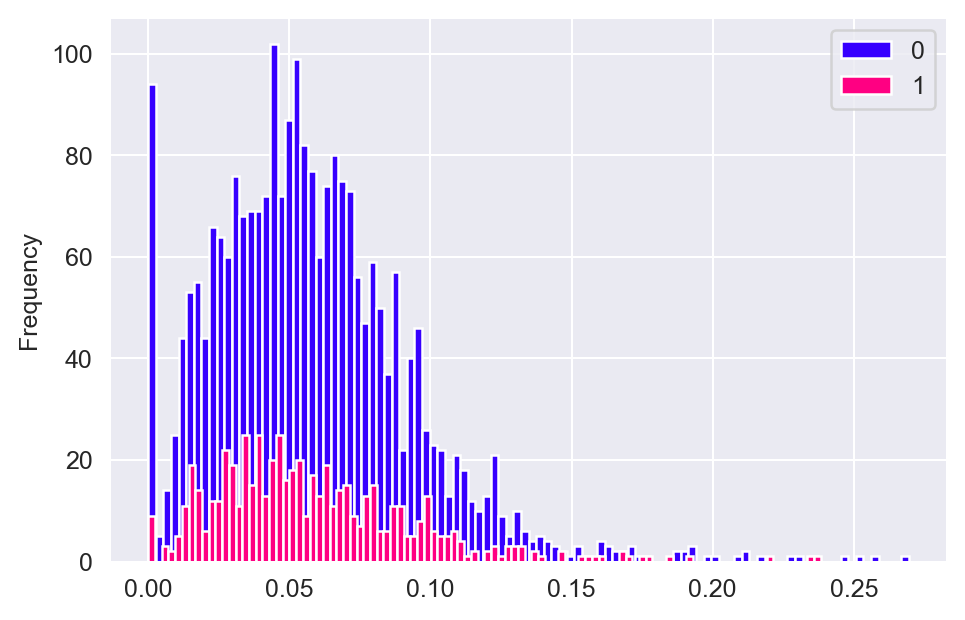

In [224]:
related_merged.groupby('agg_label')['dissimilarity_score'].plot(kind='hist', bins=100, legend=True)

In [237]:
from scipy.stats import mannwhitneyu, ttest_ind
for binder in ['Conserved', 'Improved']:
    for anchor in [True, False]:
        tmp = related_merged.query('binder==@binder and anchor_mutation==@anchor')
        pos = tmp.query('agg_label==1')['dissimilarity_score'].values
        neg = tmp.query('agg_label==0')['dissimilarity_score'].values
        print(f'{binder} Binder, {anchor} anchor; mwu:', mannwhitneyu(pos, neg)[1], 'ttest:', ttest_ind(pos,neg, equal_var=False)[1])


Conserved Binder, True anchor; mwu: 0.7790537289311881 ttest: 0.4772504658203883
Conserved Binder, False anchor; mwu: 0.9085927858226623 ttest: 0.47800041086296674
Improved Binder, True anchor; mwu: 0.5333253321097338 ttest: 0.9709978892787062
Improved Binder, False anchor; mwu: 0.7230117908272231 ttest: 0.7337449412403927


In [311]:
rest

Index(['Peptide', 'Peptide_mut', 'Peptide_wt', 'binder', 'core_mut', 'core_wt',
       'icore_mut', 'icore_wt', 'len', 'wild_type'],
      dtype='object')

In [320]:
pd.options.display.max_rows = 68
tmp = related_merged.query('agg_label==1 and anchor_mutation==False and binder=="Conserved" and ratio_rank>1 and EL_rank_wt>0.5 and EL_rank_mut <2')[subcols+['ratio_rank', 'binder','agg_label']]\
              .rename(columns = {'trueHLA_EL_rank':'old_EL_rank_mut',
                                 'wt_EL_rank':'old_EL_rank_wt',
                                 'ratio_rank':'ratio_rank_new'})
tmp['ratio_rank_old']=tmp['old_EL_rank_wt']/tmp['old_EL_rank_mut']
rank_cols = [x for x in tmp.columns if 'rank' in x.lower()]
rest = [x for x in tmp.columns.difference(rank_cols)]
tmp[rest+rank_cols].to_csv('../../Positive_problematic_conserved_binders_sample.csv', index=False)
tmp[rest+rank_cols]

Peptide  Peptide_mut   Peptide_wt  agg_label     binder   core_mut  \
28     AGQHIAKSLF    GQHIAKSLF    GQHIAKSPF          1  Conserved  GQHIAKSLF   
47      ALALAQKGV    ALALAQKGV    ALALARKGV          1  Conserved  ALALAQKGV   
241   AVYHEIHIGYL  AVYHEIHIGYL  AVYHEILIGYL          1  Conserved  AVYHEIHYL   
259     CISNVFMQR    CISNVFMQR    CISNVFVQR          1  Conserved  CISNVFMQR   
290     CTIAVVNFL    CTIAVVNFL    CTNAVVNFL          1  Conserved  CTIAVVNFL   
404     FAIADTAYV    FAIADTAYV    FASADTAYV          1  Conserved  FAIADTAYV   
441     FIDCYLLAI    FIDCYLLAI    SIDCYLLAI          1  Conserved  FIDCYLLAI   
452   FILLLFLTIFI    LLLFLTIFI    LLLFLAIFI          1  Conserved  LLLFLTIFI   
511    FLLRFLYTQL   FLLRFLYTQL   SLLRFLYTQL          1  Conserved  FLLRFLTQL   
544     FLTAHSLPL    FLTAHSLPL    FLTAHRLPL          1  Conserved  FLTAHSLPL   
560    FMDMAILVES     FMDMAILV     FMDMAMLV          1  Conserved  FM-DMAILV   
563     FMFVNSLLL    FMFVNSLLL    SMFVNSLLL          1  Conserved  FMFVNSLLL   
595     FQAQHIAMA    FQAQHIAMA    FQAQHIAVA          1  Conserved  FQAQHIAMA   
661    FVSTSDIKSM    VSTSDIKSM    VSKSDIKSM          1  Conserved  VSTSDIKSM   
699    GIKFVKHLGK   GIKFVKHLGK   GIKFVKRLGK          1  Conserved  GIFVKHLGK   
775     GRQSWSLYV    GRQSWSLYV    GRQSWSSYV          1  Conserved  GRQSWSLYV   
790    GTKKDVDVLK   GTKKDVDVLK   GTKEDVDVLK          1  Conserved  GTKKDVVLK   
808     HDLGRLHSC    HDLGRLHSC    HDLGRLHPC          1  Conserved  HDLGRLHSC   
823     HIIRLMLEY    HIIRLMLEY    HIIRLMLKY          1  Conserved  HIIRLMLEY   
859     HMTEVVRHC    HMTEVVRHC    HMTEVVRRC          1  Conserved  HMTEVVRHC   
923     IILVAVPHV    IILVAVPHV    IILVAVQHV          1  Conserved  IILVAVPHV   
956     ILGIFNEFV    ILGIFNEFV    ILGISNEFV          1  Conserved  ILGIFNEFV   
965    ILLLFLTIFI    LLLFLTIFI    LLLFLAIFI          1  Conserved  LLLFLTIFI   
1083    KARLPVGAY    KARLPVGAY    KALLPVGAY          1  Conserved  KARLPVGAY   
1168    KLKFVTLVF    KLKFVTLVF    ELKFVTLVF          1  Conserved  KLKFVTLVF   
1246    KQWLVWLAL    KQWLVWLAL    KQWLVWLLL          1  Conserved  KQWLVWLAL   
1414    LLFALHFSA    LLFALHFSA    LLFALYFSA          1  Conserved  LLFALHFSA   
1429    LLHASFVTL    LLHASFVTL    LLAASFETL          1  Conserved  LLHASFVTL   
1448    LLLFLTIFI    LLLFLTIFI    LLLFLAIFI          1  Conserved  LLLFLTIFI   
1491    LMFWASSSI    LMFWASSSI    LMLWASSSI          1  Conserved  LMFWASSSI   
1498   LMMPFSIVYI    MMPFSIVYI    VMPFSIVYI          1  Conserved  MMPFSIVYI   
1509  LPALAFTFFSL    LPALAFTFF    LPALAFAFF          1  Conserved  LPALAFTFF   
1528    LPNEYAFVT    LPNEYAFVT    LPDEYAFVT          1  Conserved  LPNEYAFVT   
1529   LPNEYAFVTT    LPNEYAFVT    LPDEYAFVT          1  Conserved  LPNEYAFVT   
1650    MIISHLYLI    MIISHLYLI    MIISHLSLI          1  Conserved  MIISHLYLI   
1664  MLLENKAVEKA  MLLENKAVEKA  MLLENKAVKKA          1  Conserved  MLLEAVEKA   
1687    MMPFSIVYI    MMPFSIVYI    VMPFSIVYI          1  Conserved  MMPFSIVYI   
1688   MMPFSIVYIV    MMPFSIVYI    VMPFSIVYI          1  Conserved  MMPFSIVYI   
1697    MPLVILIVL    MPLVILIVL    VPLVILIVL          1  Conserved  MPLVILIVL   
1698  MPLVILIVLVL    MPLVILIVL    VPLVILIVL          1  Conserved  MPLVILIVL   
1704   MQLMPFGSLL    QLMPFGSLL    QLMPFGCLL          1  Conserved  QLMPFGSLL   
1778    NTVILETLK    NTVILETLK    NTDILETLK          1  Conserved  NTVILETLK   
1823    PYMFLSEWI    PYMFLSEWI    PYVFLSEWI          1  Conserved  PYMFLSEWI   
1843   QIIHTYSNTV    IIHTYSNTV    IIHTDSNTV          1  Conserved  IIHTYSNTV   
1870    QLQKANVLL    QLQKANVLL    QLQKANVRL          1  Conserved  QLQKANVLL   
1873    QLSCISTYV    QLSCISTYV    QLSCTSTYV          1  Conserved  QLSCISTYV   
1895    QQFAVGSYV    QQFAVGSYV    QQFAVGSHV          1  Conserved  QQFAVGSYV   
1923    QVTDFLAPL    QVTDFLAPL    EVTDFLAPL          1  Conserved  QVTDFLAPL   
1995    RLDSTLLLY     RLDSTLLL     RLDSTLRL          1  Conserved  RL-DSTLLL   
2026    RL

In [271]:
related_merged.groupby(['anchor_mutation', 'binder', 'agg_label']).agg(count=('Peptide','count'))

count
anchor_mutation binder    agg_label       
False           Conserved 0           1465
                          1            364
                Improved  0             89
                          1             18
True            Conserved 0            570
                          1            106
                Improved  0            317
                          1            104

In [288]:
related_merged.loc[related_merged.apply(lambda x: len(x['Peptide_mut'])!= len(x['Peptide_wt']), axis=1)][subcols+['anchor_mutation','binder', 'agg_label']]

Peptide    wild_type  trueHLA_EL_rank  wt_EL_rank  EL_rank_mut  \
8       AAPAHSHAV    AAPAHSHAG           0.8023     42.1176       0.8023   
31      AILLGAEEK    AKLLGAEEK           0.3346      7.5168       0.3346   
33     AILPFTPEFL   AISPFTPEFL           0.7790      1.4141       0.5632   
34    AILPFTPEFLV  AISPFTPEFLV           0.6360      1.0875       0.5632   
39    AIYHTLNLFNI  AIYHTLNLCNI           5.8573      7.5550       4.7939   
...           ...          ...              ...         ...          ...   
2984   YSWSAQRQAL   YSWSAQRRAL           1.9060      1.8906       0.8898   
2986    YTAPGIVEI    DTAPGIVEI           0.0533      2.4396       0.0533   
2998    YTLSQCFQL    CTLSQCFQL           0.9252      7.6774       0.9252   
3013  YVMASVFVCPL  YVMASVFVCLL           3.6690      3.3129       3.0785   
3031   YYSKNLNSFF   YYSKNLNSSF           0.0310      0.0350       0.0033   

      EL_rank_wt  len Peptide_mut   Peptide_wt   core_mut    core_wt  \
8        35.6875    9   AAPAHSHAV     AAPAHSHA  AAPAHSHAV  AAP-AHSHA   
31        5.9022    9   AILLGAEEK     KLLGAEEK  AILLGAEEK  KLL-GAEEK   
33        1.4141   10   ILPFTPEFL   AISPFTPEFL  ILPFTPEFL  AISPFTPEL   
34        1.0875   11   ILPFTPEFL  AISPFTPEFLV  ILPFTPEFL  AISPFTPEV   
39        3.4539   11    AIYHTLNL    AIYHTLNLC  AIY-HTLNL  AIYHTLNLC   
...          ...  ...         ...          ...        ...        ...   
2984      0.9112   10   YSWSAQRQA     WSAQRRAL  YSWSAQRQA  WSA-QRRAL   
2986      2.0632    9   YTAPGIVEI     TAPGIVEI  YTAPGIVEI  TA-PGIVEI   
2998      4.3204    9   YTLSQCFQL     TLSQCFQL  YTLSQCFQL  TL-SQCFQL   
3013      0.5738   11    YVMASVFV    VMASVFVCL  YVMASVF-V  VMASVFVCL   
3031      0.0350   10   YYSKNLNSF   YYSKNLNSSF  YYSKNLNSF  YYSKNLNSF   

      icore_mut     icore_wt  anchor_mutation     binder  agg_label  
8     AAPAHSHAV     AAPAHSHA             True   Improved          0  
31    AILLGAEEK     KLLGAEEK             True   Improved          0  
33    ILPFTPEFL   AISPFTPEFL             True  Conserved          0  
34    ILPFTPEFL  AISPFTPEFLV             True  Conserved          0  
39     AIYHTLNL    AIYHTLNLC             True  Conserved          0  
...         ...          ...              ...        ...        ...  
2984  YSWSAQRQA     WSAQRRAL             True  Conserved          0  
2986  YTAPGIVEI     TAPGIVEI            False   Improved          0  
2998  YTLSQCFQL     TLSQCFQL            False   Improved          0  
3013   YVMASVFV    VMASVFVCL             True  Conserved          0  
3031  YYSKNLNSF   YYSKNLNSSF            False  Conserved          1  

[391 rows x 16 columns]

## Mutscores

In [97]:
from src.mutation_tools import get_mutation_score, get_blsm_mutation_score

In [596]:
related_merged['mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
related_merged['blsm_mut_score'] = related_merged.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

related_merged['core_mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
related_merged['core_blsm_mut_score'] = related_merged.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)

In [69]:
prime_baseline_merged.query('core_mut.str.contains("X") or core_wt.str.contains("X")', engine='python')[[x for x in colsx if 'score' not in x]]

Peptide    wild_type   core_mut    core_wt        HLA  EL_rank_mut  \
64       ALFTWTNL     AVFTWTNL  ALFTWTNLX  AVFTWTNLX  HLA-A0201       2.2587   
125     APAAAATAA    APAAAATAP  APAAAATAA  APAAAATAX  HLA-B0702       0.2275   
129    APFPLGDSAL   APFPHGDSAL  FPLGDSALX  FPHGDSALX  HLA-A6801      16.4871   
142     APRAGPGVV    APRAGPGVG  APRAGPGVV  APRGPGVGX  HLA-B0702       0.0161   
147    APVCRNEMSV   APVCRNETSV  APV-CRNEM  APRNETSVX  HLA-B0702       0.4007   
...           ...          ...        ...        ...        ...          ...   
3026    YPGKDGKVM    YRGKDGKVM  YPGKDGKVM  RGKDGKVMX  HLA-B0702       0.2412   
3066  YTEYAVKSLSK  YTEYAVKSLSN  YTAVKSLSK  YAVKSLSNX  HLA-A1101       1.0782   
3068     YTFEIQGV     YTFEIQAV  YTFEI-QGV  YTFEIQAVX  HLA-A6802       0.5296   
3073    YTGELDENK    YTGELDENE  YTGELDENK  YTGELENEX  HLA-A1101       1.9445   
3087    YTVTQLRPK    YTVTQLRPN  YTVTQLRPK  TVTQLRPNX  HLA-A1101       0.2807   

      EL_rank_wt  agg_label  anchor_mutation     binder mutation_position  \
64        7.7163          0             True  Conserved                 1   
125       0.8917          0             True   Improved                 8   
129      13.5075          0            False  Conserved                 4   
142       0.1958          0             True  Conserved                 8   
147       0.6258          0             True  Conserved                 7   
...          ...        ...              ...        ...               ...   
3026      7.0770          0             True   Improved                 1   
3066     14.5392          0             True   Improved                10   
3068      0.3577          0             True  Conserved                 6   
3073     37.3333          0             True   Improved                 8   
3087     10.9296          0             True   Improved                 8   

     core_mutation_position  
64                        1  
125                       8  
129                       2  
142             3,4,5,6,7,8  
147           2,3,4,5,6,7,8  
...                     ...  
3026      0,1,2,3,4,5,6,7,8  
3066        1,2,3,4,5,6,7,8  
3068                5,6,7,8  
3073                5,6,7,8  
3087      0,1,2,3,4,5,6,7,8  

[228 rows x 12 columns]

In [101]:
del get_mutation_score

In [108]:
from src.mutation_tools import MUT_MATRIX
MUT_MATRIX['-']['-']

1

In [111]:
from src.mutation_tools import get_mutation_score
prime_baseline_merged['mutation_score'] = prime_baseline_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
prime_baseline_merged['blsm_mut_score'] = prime_baseline_merged.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

prime_baseline_merged['core_mutation_score'] = prime_baseline_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
prime_baseline_merged['core_blsm_mut_score'] = prime_baseline_merged.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)

In [112]:
prime_baseline_merged.to_csv('../data/mutant/221028_prime_related_newcore.csv', index=False)

In [110]:
pd.options.display.max_rows = 20
related_merged.groupby('agg_label')['dissimilarity_score', 'mutation_score', 'blsm_mut_score', 'core_mutation_score',
                                    'core_blsm_mut_score']\
              .quantile(q=np.arange(0.1,1.1,0.1)).rename(columns = {k:f'Quantile {k:.0%}' for k in np.arange(0.1,1.1,0.1)})

NameError: name 'related_merged' is not defined

KeyError: 'Column not found: dissimilarity_score'

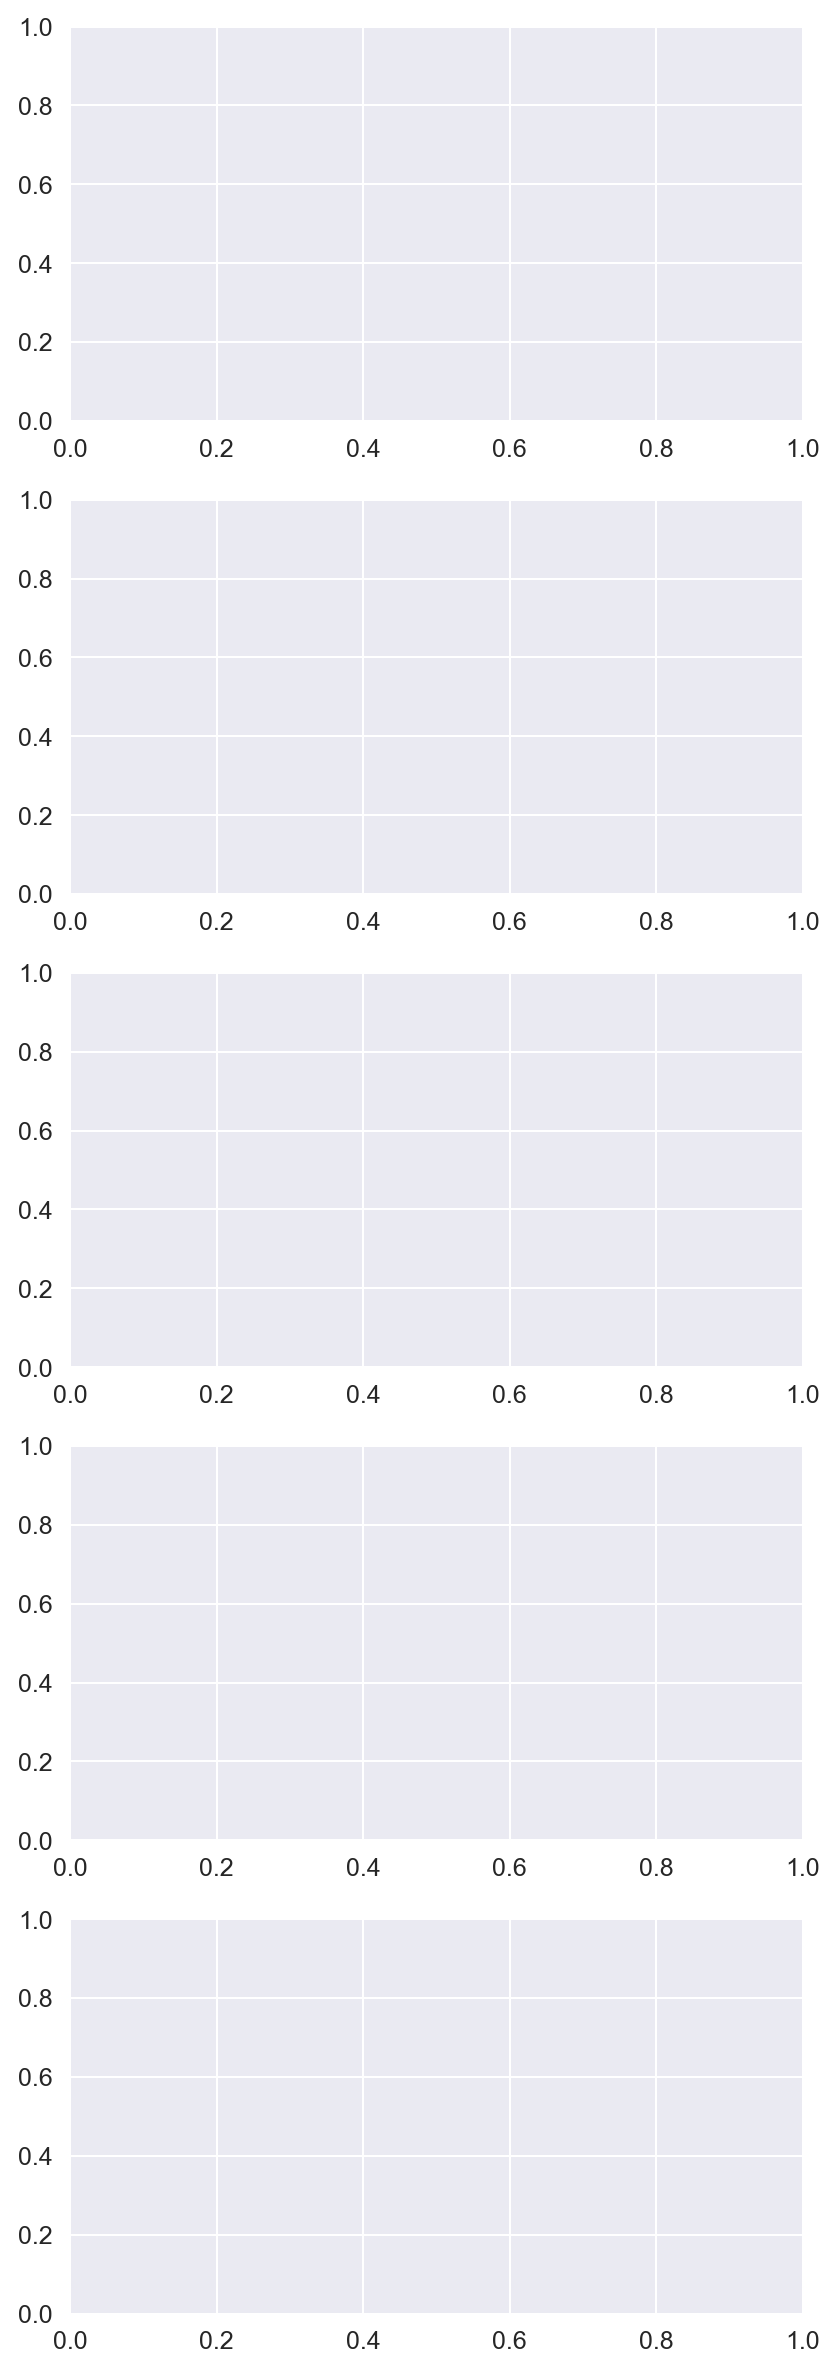

In [113]:
f,a = plt.subplots(5,1, figsize=(5.25, 16.5))
for i, col in enumerate(['dissimilarity_score', 'mutation_score', 'blsm_mut_score', 
                         'core_mutation_score', 'core_blsm_mut_score']):
    prime_baseline_merged.groupby('agg_label')[col]\
                  .plot(kind='hist', bins=100, legend=True, ax=a[i])
    a[i].set_title(col)

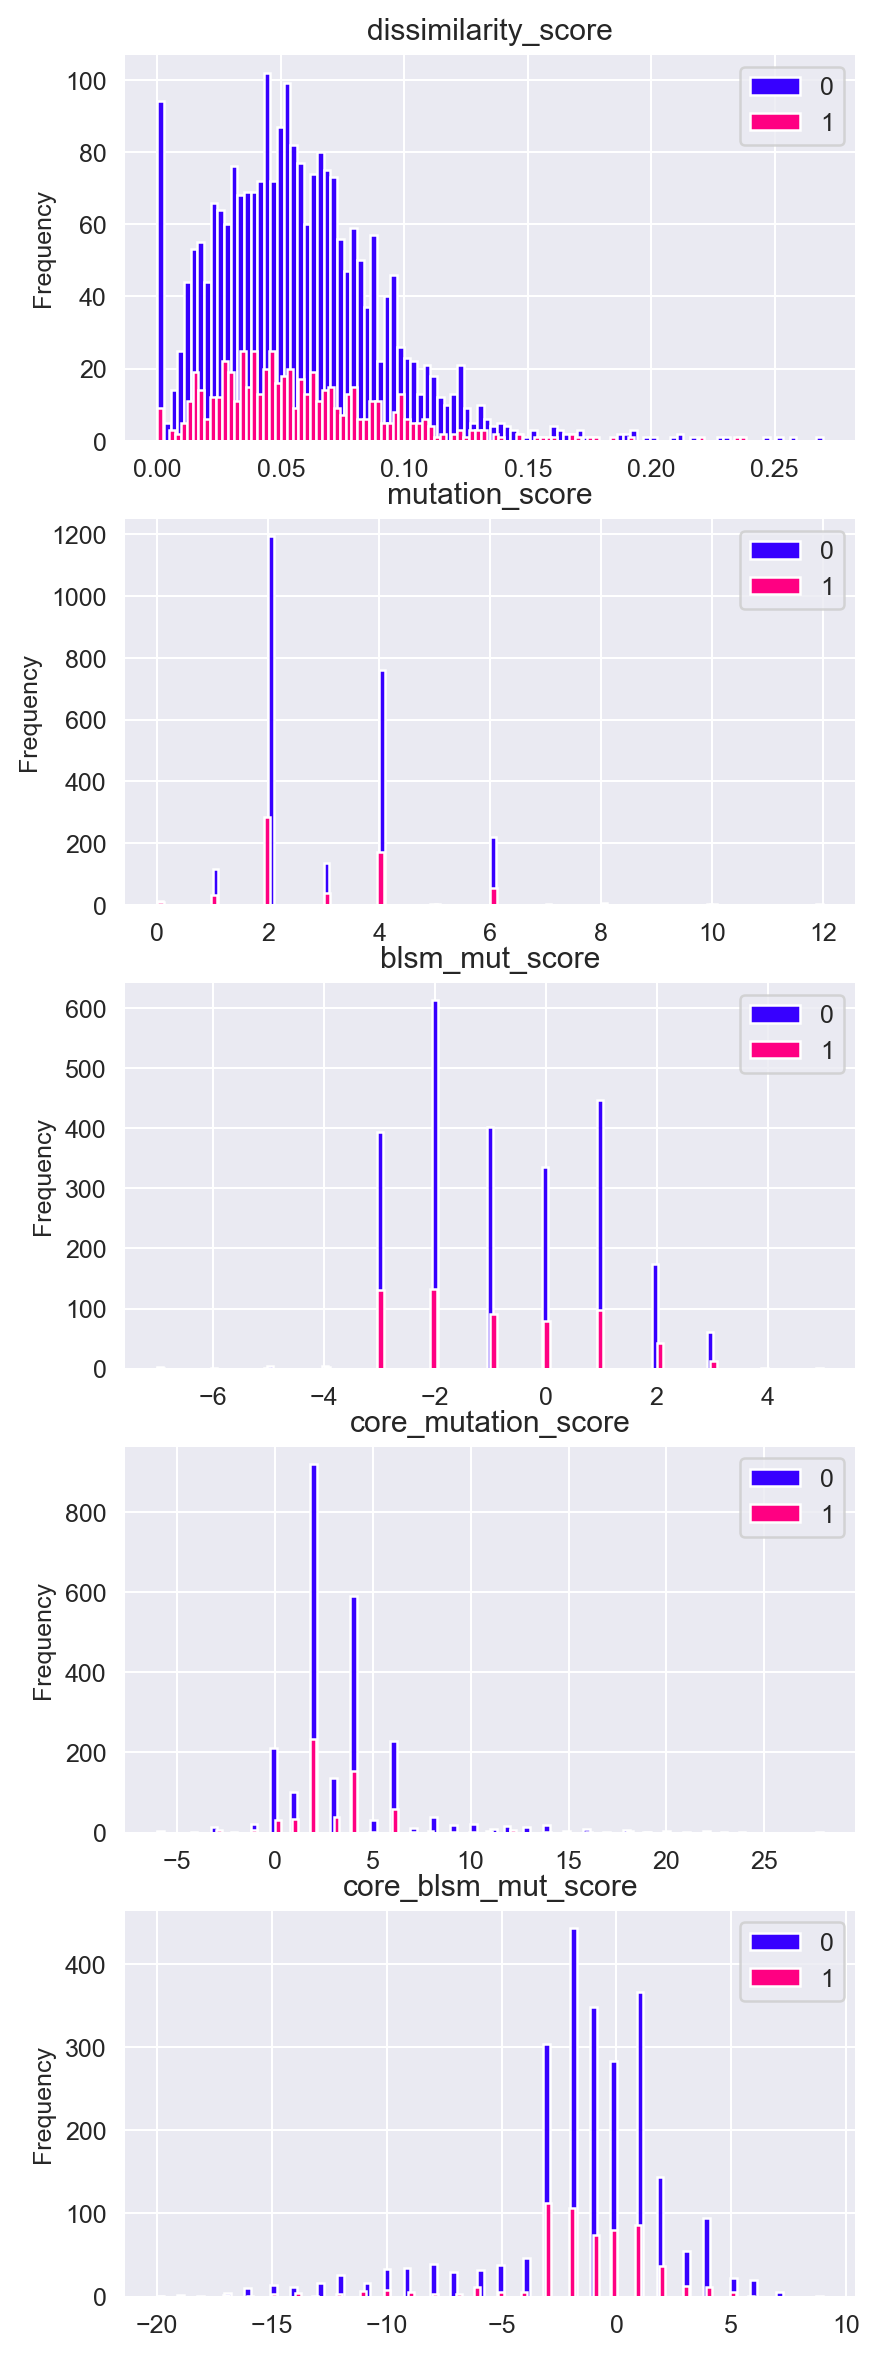

In [601]:
f,a = plt.subplots(5,1, figsize=(5.25, 16.5))
for i, col in enumerate(['dissimilarity_score', 'mutation_score', 'blsm_mut_score', 
                         'core_mutation_score', 'core_blsm_mut_score']):
    related_merged.groupby('agg_label')[col]\
                  .plot(kind='hist', bins=100, legend=True, ax=a[i])
    a[i].set_title(col)

### Mutscores

In [252]:
related_merged['mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
related_merged['blsm_mut_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

related_merged['core_mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
related_merged['core_blsm_mut_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)


In [265]:
related_merged.groupby('agg_label')[['dissimilarity_score','mutation_score', 'blsm_mut_score', 'core_mutation_score', 'core_blsm_mut_score']]\
              .quantile(q=np.linspace(0.1,1.0,10)).rename(columns={k:f'Quantile {k:.0%}' for k in np.linspace(0.1,1.0,10)})

dissimilarity_score  mutation_score  blsm_mut_score  \
agg_label                                                            
0         0.1             0.016584        0.693147        0.693147   
          0.2             0.028597        0.693147        0.693147   
          0.3             0.037356        0.693147        0.693147   
          0.4             0.045687        0.693147        0.693147   
          0.5             0.053460        0.693147        0.693147   
          0.6             0.062170        1.386294        1.386294   
          0.7             0.071296        1.386294        1.386294   
          0.8             0.082198        1.386294        1.386294   
          0.9             0.099304        1.386294        1.386294   
          1.0             0.269576        2.302585        2.302585   
1         0.1             0.018982        0.693147        0.693147   
          0.2             0.029031        0.693147        0.693147   
          0.3             0.037150        0.693147        0.693147   
          0.4             0.044384        0.693147        0.693147   
          0.5             0.051025        0.693147        0.693147   
          0.6             0.061124        1.098612        1.098612   
          0.7             0.070538        1.386294        1.386294   
          0.8             0.084358        1.386294        1.386294   
          0.9             0.101186        1.386294        1.386294   
          1.0             0.238194        2.484907        2.484907   

               core_mutation_score  core_blsm_mut_score  
agg_label                                                
0         0.1             0.693147             0.693147  
          0.2             0.693147             0.693147  
          0.3             0.693147             0.693147  
          0.4             0.693147             0.693147  
          0.5             1.098612             1.098612  
          0.6             1.386294             1.386294  
          0.7             1.386294             1.386294  
          0.8             1.386294             1.386294  
          0.9             1.791759             1.791759  
          1.0             3.332205             3.332205  
1         0.1             0.693147             0.693147  
          0.2             0.693147             0.693147  
          0.3             0.693147             0.693147  
          0.4             0.693147             0.693147  
          0.5             0.693147             0.693147  
          0.6             1.386294             1.386294  
          0.7             1.386294             1.386294  
          0.8             1.386294             1.386294  
          0.9             1.791759             1.791759  
          1.0             3.178054             3.178054

agg_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: core_blsm_mut_score, dtype: object

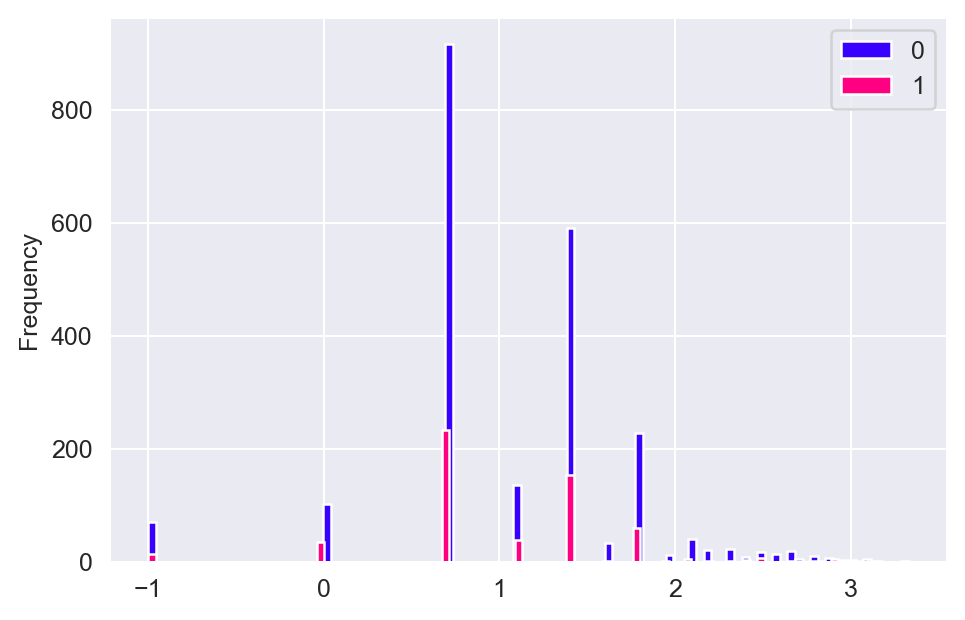

In [253]:
related_merged.groupby(['agg_label'])['core_blsm_mut_score'].plot(kind='hist', bins=100, legend=True)

## Making folds

In [322]:
related_merged.drop(columns = ['lencore', 'len_1', 'len_2'], inplace=True)
related_merged['len_icore_mut'] = related_merged['icore_mut'].apply(len)
related_merged['len_icore_wt'] = related_merged['icore_wt'].apply(len)
related_merged['len_pep_mut'] = related_merged['Peptide_mut'].apply(len)
related_merged['len_pep_wt'] = related_merged['Peptide_wt'].apply(len)

In [338]:
(related_merged['icore_mut']==related_merged['Peptide_mut']).all()

True

In [333]:
display(related_merged.groupby(['len_pep_mut']).agg(count=('Peptide', 'count')))
display(related_merged.groupby(['len']).agg(count=('Peptide', 'count')))

count
len_pep_mut       
8              125
9             2146
10             525
11             236
12               1

count
len       
9     1531
10     875
11     625
12       2

In [335]:
related_merged.drop(columns=[x for x in related_merged.columns if 'delta' in x], inplace=True)

In [370]:
# Icore mut yields duplicates due to duplicated cores for distinct peptides
related_merged['icore_mut'].to_csv('../../../kern_dist/data/221028_related_icore_mut.pep', index=False, header=False)
related_merged['Peptide'].to_csv('../../../kern_dist/data/221028_Peptide_mut.pep', index=False, header=False)

In [535]:
from src.partition_tools import pipeline_stratified_kfold
related_merged_fold = pipeline_stratified_kfold('../../../kern_dist/out/221028_Peptide_mut.pep_0.8.out', 
                                                related_merged.reset_index(drop=True),
                                               k=10, shuffle=True, seed=20, pep_col = 'Peptide', elrank_col = 'EL_rank_mut')

# related_merged_core_fold = pipeline_stratified_kfold('../../../kern_dist/out/221028_related_icore_mut.pep_0.8.out', 
#                                                 related_merged.reset_index(drop=True),
#                                                k=10, shuffle=True, seed=20, pep_col = 'icore_mut', elrank_col = 'EL_rank_mut')


In [536]:
pd.options.display.max_rows=678
diff=related_merged_fold.loc[related_merged_fold.duplicated(['icore_mut', 'HLA'], keep=False)][['HLA', 'Peptide', 'Peptide_mut','EL_rank_mut', 'core_mut', 'icore_mut','agg_label']]\
                   .groupby(['HLA', 'icore_mut']).agg(diff=('agg_label','std')).query('diff!=0').reset_index()
diff_labels = related_merged_fold.query('icore_mut in @diff.icore_mut.values').sort_values('icore_mut')[['HLA', 'Peptide','Peptide_mut', 'icore_mut', 'core_mut', 'EL_rank_mut', 'agg_label','fold']]
print(len(diff_labels.icore_mut.unique()), len(diff_labels))
diff_labels.head(10)

30 75


HLA      Peptide Peptide_mut   icore_mut   core_mut  EL_rank_mut  \
62    HLA-A0201   ALDPHSGHFV  ALDPHSGHFV  ALDPHSGHFV  ALDPHSHFV       0.0854   
63    HLA-A0201  ALDPHSGHFVA  ALDPHSGHFV  ALDPHSGHFV  ALDPHSHFV       0.0854   
1101  HLA-A0201  KALDPHSGHFV  ALDPHSGHFV  ALDPHSGHFV  ALDPHSHFV       0.0854   
6     HLA-A0201   AALLQVTLLL   ALLQVTLLL   ALLQVTLLL  ALLQVTLLL       0.0995   
90    HLA-A0201    ALLQVTLLL   ALLQVTLLL   ALLQVTLLL  ALLQVTLLL       0.0995   
121   HLA-A0201    AMAGSLVFL   AMAGSLVFL   AMAGSLVFL  AMAGSLVFL       0.0845   
123   HLA-B0702    AMAGSLVFL   AMAGSLVFL   AMAGSLVFL  AMAGSLVFL       6.2205   
125   HLA-A2402    AMAGSLVFL   AMAGSLVFL   AMAGSLVFL  AMAGSLVFL       4.1874   
1364  HLA-A0201   LAMAGSLVFL   AMAGSLVFL   AMAGSLVFL  AMAGSLVFL       0.0845   
726   HLA-A0201  GLAMAGSLVFL   AMAGSLVFL   AMAGSLVFL  AMAGSLVFL       0.0845   

      agg_label  fold  
62            1     8  
63            0     8  
1101          0     8  
6             0     6  
90            1     6  
121           1     6  
123           0     6  
125           0     6  
1364          0     2  
726           0     2

In [537]:
from src.data_processing import get_aa_properties
related_fold_aaprops, aa_cols = get_aa_properties(related_merged_fold, seq_col='Peptide') 

## Collapsing datapoints with same icores and re-defining neg-pos

In [538]:
prop_same_core = len(related_fold_aaprops.query('agg_label==1 and core_mut==core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut==core_wt'))
prop_diff_core = len(related_fold_aaprops.query('agg_label==1 and core_mut!=core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut!=core_wt'))
prop_overall = len(related_fold_aaprops.query('agg_label==1'))/len(related_fold_aaprops.query('agg_label==0'))
print('BEFORE collapsing data')
print(f'pos/neg prop with same core:\t{prop_same_core}\npos/neg prop with diff core:\t{prop_diff_core}\npos/neg prop overall:\t\t{prop_overall}')

BEFORE collapsing data
pos/neg prop with same core:	0.1276595744680851
pos/neg prop with diff core:	0.24956521739130436
pos/neg prop overall:		0.24252355591970504


In [539]:
def most_common(x):
    return np.bincount(x).argmax()

In [540]:
fucking_gb = diff_labels.groupby(['icore_mut', 'HLA']).agg(max_label=('agg_label','max'), top_fold = ('fold', most_common))
fucking_folds = fucking_gb.reset_index().groupby(['icore_mut']).agg(top_fold=('top_fold', most_common))
for i, row in fucking_gb.iterrows():
    core = row.name[0]    
    hla = row.name[1]
    indices = related_fold_aaprops.query('HLA==@hla and icore_mut == @core').index
    related_fold_aaprops.loc[indices, 'agg_label']= row['max_label']
    related_fold_aaprops.loc[indices, 'fold'] = int(fucking_folds.loc[core].top_fold)

In [542]:
prop_same_core = len(related_fold_aaprops.query('agg_label==1 and core_mut==core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut==core_wt'))
prop_diff_core = len(related_fold_aaprops.query('agg_label==1 and core_mut!=core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut!=core_wt'))
prop_overall = len(related_fold_aaprops.query('agg_label==1'))/len(related_fold_aaprops.query('agg_label==0'))
print('AFTER collapsing data')
print(f'pos/neg prop with same core:\t{prop_same_core}\npos/neg prop with diff core:\t{prop_diff_core}\npos/neg prop overall:\t\t{prop_overall}')

AFTER collapsing data
pos/neg prop with same core:	0.1276595744680851
pos/neg prop with diff core:	0.2711189739053516
pos/neg prop overall:		0.2626977518734388


In [544]:
related_fold_aaprops.query('core_mut==core_wt and agg_label==1')[subcols+['HLA']]

Peptide    wild_type  trueHLA_EL_rank  wt_EL_rank  EL_rank_mut  \
890    HQNPVTGLLL   HQNPVTGLLP           0.4505      8.3554       0.1582   
1028  IPDSIALIQQL  IPDSIAVIQQL           0.7846      0.7692       0.7846   
1220   KLVVVGACGV   KLVVVGAGGV           5.3829      6.0865       5.3829   
1221   KLVVVGADGV   KLVVVGAGGV           3.2976      3.2011       3.2976   
1251   KPKKENLWRM   KPKKENLRRM           0.4590      0.4129       0.4590   
1306   KTGEQRVVTL   ETGEQRVVTL           9.5707     17.3019       3.2579   
1524  LMLEYQKILWK  LMLKYQKILWK           5.1172      5.4139       2.3040   
1690   MLEYQKILWK   MLKYQKILWK           2.3040      2.3837       2.3040   
1691  MLEYQKILWKV  MLKYQKILWKV           2.9861      3.0418       2.1404   
1735   MQLMPFGCLL   TQLMPFGCLL           2.9729      3.0424       0.5522   
2006  RHDLPPYRVYL  RHDLPPYRVHL           0.1253      0.1287       0.0253   
2067  RLSCMLARLEV  RLSCMLARLEI           3.9007      8.4547       1.3674   
2551   TLDWLLQTPK   TLGWLLQTPK           1.3884      1.5030       1.3884   
2560  TLIAIFPYARL  TLIAIFPYAGL           2.7494      2.8137       0.2600   
2598   TMIEEYDSGL   TMIEEDDSGL           2.2537      2.4307       2.2537   
2894   YFATLITELF   YFATLITELV           2.7089      7.5707       0.0760   
3064  YVRVTVQARVM  CVRVTVQARVM           5.0828     18.6104       1.9540   
3078   YYSKNLNSFF   YYSKNLNSSF           0.0310      0.0350       0.0033   

      EL_rank_wt  len  Peptide_mut   Peptide_wt   core_mut    core_wt  \
890       0.1582   10    HQNPVTGLL    HQNPVTGLL  HQNPVTGLL  HQNPVTGLL   
1028      0.7692   11  IPDSIALIQQL  IPDSIAVIQQL  IPDSIAQQL  IPDSIAQQL   
1220      6.0865   10   KLVVVGACGV   KLVVVGAGGV  KLVVVGAGV  KLVVVGAGV   
1221      3.2011   10   KLVVVGADGV   KLVVVGAGGV  KLVVVGAGV  KLVVVGAGV   
1251      0.4129   10   KPKKENLWRM   KPKKENLRRM  KPKKENLRM  KPKKENLRM   
1306      3.2579   10    TGEQRVVTL    TGEQRVVTL  TGEQRVVTL  TGEQRVVTL   
1524      2.3837   11   MLEYQKILWK   MLKYQKILWK  MLYQKILWK  MLYQKILWK   
1690      2.3837   10   MLEYQKILWK   MLKYQKILWK  MLYQKILWK  MLYQKILWK   
1691      2.1404   11     YQKILWKV     YQKILWKV  YQ-KILWKV  YQ-KILWKV   
1735      0.5522   10    QLMPFGCLL    QLMPFGCLL  QLMPFGCLL  QLMPFGCLL   
2006      0.0253   11    RHDLPPYRV    RHDLPPYRV  RHDLPPYRV  RHDLPPYRV   
2067      1.3674   11    RLSCMLARL    RLSCMLARL  RLSCMLARL  RLSCMLARL   
2551      1.5030   10   TLDWLLQTPK   TLGWLLQTPK  TLWLLQTPK  TLWLLQTPK   
2560      0.2600   11    TLIAIFPYA    TLIAIFPYA  TLIAIFPYA  TLIAIFPYA   
2598      2.4307   10   TMIEEYDSGL   TMIEEDDSGL  TMIEEDSGL  TMIEEDSGL   
2894      0.0760   10    YFATLITEL    YFATLITEL  YFATLITEL  YFATLITEL   
3064      1.9540   11    RVTVQARVM    RVTVQARVM  RVTVQARVM  RVTVQARVM   
3078      0.0350   10    YYSKNLNSF   YYSKNLNSSF  YYSKNLNSF  YYSKNLNSF   

        icore_mut     icore_wt        HLA  
890     HQNPVTGLL    HQNPVTGLL  HLA-B3801  
1028  IPDSIALIQQL  IPDSIAVIQQL  HLA-B0702  
1220   KLVVVGACGV   KLVVVGAGGV  HLA-A0201  
1221   KLVVVGADGV   KLVVVGAGGV  HLA-A0203  
1251   KPKKENLWRM   KPKKENLRRM  HLA-B0702  
1306    TGEQRVVTL    TGEQRVVTL  HLA-C1203  
1524   MLEYQKILWK   MLKYQKILWK  HLA-A1101  
1690   MLEYQKILWK   MLKYQKILWK  HLA-A1101  
1691     YQKILWKV     YQKILWKV  HLA-A0201  
1735    QLMPFGCLL    QLMPFGCLL  HLA-A0201  
2006    RHDLPPYRV    RHDLPPYRV  HLA-B3801  
2067    RLSCMLARL    RLSCMLARL  HLA-A0201  
2551   TLDWLLQTPK   TLGWLLQTPK  HLA-A0301  
2560    TLIAIFPYA    TLIAIFPYA  HLA-A0201  
2598   TMIEEYDSGL   TMIEEDDSGL  HLA-A0201  
2894    YFATLITEL    YFATLITEL  HLA-C0401  
3064    RVTVQARVM    RVTVQARVM  HLA-B0702  
3078    YYSKNLNSF   YYSKNLNSSF  HLA-A2402

## Hyperparameters check

In [ ]:
dir_='../output/tuning/rf_bootstrap/'
df = pd.DataFrame()
for x in [x for x in os.listdir(dir_) if 'onehot' in x.lower()]:
    df= df.append(pd.DataFrame(pkl_load(os.path.join(dir_,x)), index=[0]))
df.reset_index(drop=True)

In [193]:
import itertools
df['learning_rate']=1
df['max_depth'].replace(np.nan, -1,inplace=True)
cols_ = ['ccp_alpha', 'max_depth', 'n_estimators']
mcs = []
for L in range(1, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
for mc in mcs:
    display(df.groupby(mc).count())


max_depth  n_estimators  learning_rate  reg_alpha  reg_lambda
ccp_alpha                                                                  
1.000000e-09         43            43             43          0           0
4.641589e-07         62            62             62          0           0
2.154435e-04         67            67             67          0           0

ccp_alpha  n_estimators  learning_rate  reg_alpha  reg_lambda
max_depth                                                               
-1.0              68            71             71          3           3
 3.0               2            11             11          9           9
 5.0               5             5              5          0           0
 7.0              50            54             54          4           4
 9.0              47            47             47          0           0

ccp_alpha  max_depth  learning_rate  reg_alpha  reg_lambda
n_estimators                                                            
100.0                17         17             17          0           0
200.0                46         59             59         13          13
250.0                25         28             28          3           3
300.0                84         84             84          0           0

n_estimators  learning_rate  reg_alpha  reg_lambda
ccp_alpha    max_depth                                                    
1.000000e-09 -1.0                 18             18          0           0
              5.0                  1              1          0           0
              7.0                 12             12          0           0
              9.0                 12             12          0           0
4.641589e-07 -1.0                 27             27          0           0
              5.0                  4              4          0           0
              7.0                 15             15          0           0
              9.0                 16             16          0           0
2.154435e-04 -1.0                 23             23          0           0
              3.0                  2              2          0           0
              7.0                 23             23          0           0
              9.0                 19             19          0           0

max_depth  learning_rate  reg_alpha  reg_lambda
ccp_alpha    n_estimators                                                 
1.000000e-09 100.0                 3              3          0           0
             200.0                10             10          0           0
             250.0                 6              6          0           0
             300.0                24             24          0           0
4.641589e-07 100.0                 5              5          0           0
             200.0                18             18          0           0
             250.0                 9              9          0           0
             300.0                30             30          0           0
2.154435e-04 100.0                 9              9          0           0
             200.0                18             18          0           0
             250.0                10             10          0           0
             300.0                30             30          0           0

ccp_alpha  learning_rate  reg_alpha  reg_lambda
max_depth n_estimators                                                 
-1.0      100.0                 4              4          0           0
          200.0                14             16          2           2
          250.0                17             18          1           1
          300.0                33             33          0           0
 3.0      200.0                 1              9          8           8
          250.0                 0              1          1           1
          300.0                 1              1          0           0
 5.0      100.0                 1              1          0           0
          200.0                 3              3          0           0
          300.0                 1              1          0           0
 7.0      100.0                 5              5          0           0
          200.0                13             16          3           3
          250.0                 8              9          1           1
          300.0                24             24          0           0
 9.0      100.0                 7              7          0           0
          200.0                15             15          0           0
          300.0                25             25          0           0

learning_rate  reg_alpha  reg_lambda
ccp_alpha    max_depth n_estimators                                      
1.000000e-09 -1.0      100.0                     1          0           0
                       200.0                     2          0           0
                       250.0                     3          0           0
                       300.0                    12          0           0
              5.0      200.0                     1          0           0
              7.0      100.0                     2          0           0
                       200.0                     3          0           0
                       250.0                     3          0           0
                       300.0                     4          0           0
              9.0      200.0                     4          0           0
                       300.0                     8          0           0
4.641589e-07 -1.0      200.0                     8          0           0
                       250.0                     7          0           0
                       300.0                    12          0           0
              5.0      100.0                     1          0           0
                       200.0                     2          0           0
                       300.0                     1          0           0
              7.0      100.0                     1          0           0
                       200.0                     5          0           0
                       250.0                     2          0           0
                       300.0                     7          0           0
              9.0      100.0                     3          0           0
                       200.0                     3          0           0
                       300.0                    10          0           0
2.154435e-04 -1.0      100.0                     3          0           0
                       200.0                     4          0           0
                       250.0                     7          0           0
                       300.0                     9          0           0
              3.0      200.0                     1          0           0
                       300.0                     1          0           0
              7.0      100.0                     2          0           0
                       200.0                     5          0           0
                       250.0                     3          0           0
                       300.0                    13          0           0
              9.0      100.0                     4          0           0
                       200.0                     8          0           0
                       300.0                     7          0           0

In [197]:
df.quantile(q=np.arange(0.1,1.1, 0.1))

ccp_alpha  max_depth  n_estimators  learning_rate     reg_alpha  \
0.1  1.000000e-09       -1.0         200.0            1.0  1.000000e-09   
0.2  1.000000e-09       -1.0         200.0            1.0  1.000000e-09   
0.3  4.641589e-07       -1.0         200.0            1.0  1.077222e-04   
0.4  4.641589e-07        3.0         200.0            1.0  2.154435e-04   
0.5  4.641589e-07        7.0         250.0            1.0  1.000000e-01   
0.6  4.641589e-07        7.0         300.0            1.0  1.000000e-01   
0.7  2.154435e-04        7.0         300.0            1.0  1.000000e-01   
0.8  2.154435e-04        9.0         300.0            1.0  1.000000e-01   
0.9  2.154435e-04        9.0         300.0            1.0  1.000000e-01   
1.0  2.154435e-04        9.0         300.0            1.0  1.000000e-01   

       reg_lambda  
0.1  2.325794e-07  
0.2  2.154435e-04  
0.3  2.154435e-04  
0.4  2.154435e-04  
0.5  5.010772e-02  
0.6  1.000000e-01  
0.7  1.000000e-01  
0.8  1.000000e-01  
0.9  1.000000e-01  
1.0  1.000000e-01

In [646]:
related_fold_aaprops.to_csv('../data/mutant/221028_related_newcore_fold.csv', index=False)

# Making a merged related dataset (PRIME + CEDAR) for training?

In [8]:
prime_related_newcore = pd.read_csv('../data/mutant/221028_prime_related_newcore.csv')
cedar_related_newcore = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')

## Check common peps

In [9]:
prime_peps = prime_related_newcore.Peptide.unique()
cedar_peps = cedar_related_newcore.Peptide.unique()
common_peps = [x for x in cedar_peps if x in prime_peps]
prime_common = prime_related_newcore.query('Peptide in @common_peps').sort_values('Peptide')
cedar_common = cedar_related_newcore.query('Peptide in @common_peps').sort_values('Peptide')

In [10]:
cols = ['Peptide', 'HLA', 'agg_label']
count=0
diff_label = pd.DataFrame(columns = ['Peptide','HLA', 'cedar_label', 'prime_label'])
for peptide in common_peps:
    if peptide=="TTLFHTFYEL" or peptide=="KLKFVTLVF":continue
    cv = cedar_related_newcore.query('Peptide==@peptide')[cols]
    pv = prime_related_newcore.query('Peptide==@peptide')[cols]
    lcv = len(cv)
    lpv = len(pv)
    if lcv==1 and lpv==1:
        if len(cv)==len(pv):
            if (cv['agg_label'].item() == pv['agg_label'].item()):
                continue
            else:
                diff_label=diff_label.append(pd.DataFrame([peptide, pv['HLA'].item(), cv['agg_label'].item(), pv['agg_label'].item()], index=diff_label.columns).T)
                # print('cedar:\t', cv.values)
                # print('prime:\t', pv.values)
                # print('––––––––––––––––––––––––––––––––––––––––')
                count+=1
    else:
        if lcv>lpv:
            for _, c in cv.iterrows():
                if c['HLA']!= pv['HLA'].item():
                    continue
                else:
                    if c['agg_label']!=pv['agg_label'].item():
                        diff_label=diff_label.append(pd.DataFrame([peptide, pv['HLA'].item(), c['agg_label'], pv['agg_label'].item()], index=diff_label.columns).T)
                        # print('cedar:\t', c.values)
                        # print('prime:\t', pv.values)
                        # print('––––––––––––––––––––––––––––––––––––––––')
                        count+=1
print(count)


27


In [11]:
diff_label

Peptide        HLA cedar_label prime_label
0    ALALAQKGV  HLA-A0201           1           0
0   ALLETPSLLL  HLA-A0201           1           0
0    ALYGFVPVL  HLA-A0201           1           0
0    DMKARQKAL  HLA-B0801           1           0
0    FILDAVQRV  HLA-A0201           1           0
0    FLEIYTVTV  HLA-A0201           1           0
0   FLMASISSFL  HLA-A0201           1           0
0    FQLNQSFEI  HLA-A0201           1           0
0    FSGEYIPTV  HLA-A0201           1           0
0    FWYTHNLIF  HLA-C1403           1           0
0   FWYTHNLIFV  HLA-C1403           1           0
0  FWYTHNLIFVF  HLA-C1403           1           0
0    HLMDGDLGL  HLA-A0201           1           0
0   IFWYTHNLIF  HLA-C1403           1           0
0    IHYTAQIIL  HLA-B3901           1           0
0  IHYTAQIILAL  HLA-B3901           1           0
0    KLKLPIIMK  HLA-A0301           1           0
0    LMASISSFL  HLA-A0201           1           0
0   LMASISSFLL  HLA-A0201           1           0
0   LMMPFSIVYI  HLA-A0201           1           0
0   MLSILALVRV  HLA-A0201           1           0
0    REFDKIELA  HLA-B4102           1           0
0  RTQDVSVQVER  HLA-A6801           1           0
0    SLAPLSPRV  HLA-A0201           1           0
0    SLDLTTSPV  HLA-A0201           1           0
0   TMSFSHLFYL  HLA-A0201           1           0
0    YLDELIRNT  HLA-A0201           1           0

In [12]:
np.bincount(diff_label['cedar_label']>diff_label['prime_label'])

array([ 0, 27])

27 datapoints have different labels and all 27 are positive in CEDAR but negative in PRIME

In [13]:
cedar_related_newcore['diff_label_from_prime'] = 0
for a,b in diff_label[['Peptide', 'HLA']].values:
    idx = cedar_related_newcore.query('Peptide==@a and HLA==@b').index
    cedar_related_newcore.loc[idx, 'diff_label_from_prime']=1

## Making the dataset

Keeping the CEDAR label as the "correct" label, making folds

In [123]:
pd.set_option('display.max_columns', 99)
prime_related_newcore = prime_related_newcore.query('Peptide not in @common_peps')
cedar_related_newcore['dataset']='CEDAR'
prime_related_newcore['dataset']='PRIME'
concat=pd.concat([cedar_related_newcore, prime_related_newcore]).drop(columns = ['nnalign_score', 'MixMHCrank', 'PRIME_score', 'MixMHCallele', 'StudyOrigin',
                                                                                 'pred_EL_rank', 'pred_EL_score', 'pred_HLA', 'total_count', 'seq_id', 'trainset',
                                                                                'fold', 'BA_score', 'BA_rank', 'icore', 'len_icore_mut', 'len_icore_wt', 
                                                                                'len_pep_mut', 'len_pep_wt', 'len_wt', 'wt_true'])

In [15]:
concat['Peptide'].to_csv('../../kern_dist/data/cedar_prime_merged.pep', index=False, header=False)

In [124]:
concat

Peptide        HLA  EL_rank_mut  agg_label  EL_rank_wt     HLA_full  \
0     AAAAAAQQIQV  HLA-B0702       3.9712          0      1.0441  HLA-B*07:02   
1       AAAAQQIQV  HLA-B0702       4.9092          0      4.7746  HLA-B*07:02   
2       AAAAQQIQV  HLA-A0201       1.9555          0      2.2847  HLA-A*02:01   
3       AAHFTVLLY  HLA-A1101       0.4196          0      0.5881  HLA-A*11:01   
4       AAIAASRSV  HLA-C1203       0.0591          0      1.1729  HLA-C*12:03   
...           ...        ...          ...        ...         ...          ...   
3104   YYCEVLPGEI  HLA-A2402       0.9916          0      1.2384  HLA-A*24:02   
3105    YYCHWGYEV  HLA-A2402       0.4481          0      0.4865  HLA-A*24:02   
3106    YYEDIKNDF  HLA-A2402       0.0940          0      0.1546  HLA-A*24:02   
3107   YYNCAFTRNI  HLA-A2402       1.3054          0      0.7245  HLA-A*24:02   
3108  YYNCAFTRNII  HLA-A2402       1.3054          0      0.7245  HLA-A*24:02   

         PMIDs Peptide_mut  Peptide_wt  Pos_mut  Pos_wt  \
0     27198675   AAAAAAQQI   AAAAAAQQL        0       0   
1     27198675   AAAAQQIQV   AAAAQQLQV        0       0   
2     27198675   AAAAQQIQV   AAAAQQLQV        0       0   
3     31511069   AAHFTVLLY   AAHFTALLY        0       0   
4     30556813   AAIAASRSV   AAIAASRSA        0       0   
...        ...         ...         ...      ...     ...   
3104       NaN  YYCEVLPGEI  YYREVLPGEI        0       0   
3105       NaN   YYCHWGYEV   YYCHGGYEV        0       0   
3106       NaN   YYEDIKNDF   YYEDIKKDF        0       0   
3107       NaN  YYNCAFTRNI  YYNRAFTRNI        0       0   
3108       NaN  YYNCAFTRNI  YYNRAFTRNI        0       0   

      Related Object_Ending Position  Related Object_Starting Position  \
0                              167.0                             157.0   
1                              167.0                             159.0   
2                              167.0                             159.0   
3                             1957.0                            1949.0   
4                               14.0                               6.0   
...                              ...                               ...   
3104                             NaN                               NaN   
3105                             NaN                               NaN   
3106                             NaN                               NaN   
3107                             NaN                               NaN   
3108                             NaN                               NaN   

      anchor_mutation     binder  blsm_mut_score       core  \
0                True  Conserved               2  AAAAAQIQV   
1               False  Conserved               2  AAAAQQIQV   
2               False  Conserved               2  AAAAQQIQV   
3               False  Conserved               0  AAHFTVLLY   
4                True   Improved               0  AAIAASRSV   
...               ...        ...             ...        ...   
3104            False  Conserved              -3  YYCEVLPEI   
3105            False  Conserved              -2  YYCHWGYEV   
3106            False  Conserved               0  YYEDIKNDF   
3107             True  Conserved              -3  YYNAFTRNI   
3108             True  Conserved              -3  YYAFTRNII   

      core_blsm_mut_score   core_mut core_mutation_position  \
0                       2  AAAAAAQQI                      8   
1                       2  AAAAQQIQV                      6   
2                       2  AAAAQQIQV                      6   
3                       0  AAHFTVLLY                      5   
4                       0  AAIAASRSV                      8   
...                   ...        ...                    ...   
3104                   -3  YYCEVLPEI                      2   
3105                   -2  YYCHWGYEV                      4   
3106                    0  YYEDIKNDF                      6   
3107                   -6  YYNAFTRNI              3,

In [130]:
from src.partition_tools import pipeline_stratified_kfold
concat = concat.reset_index(drop=True)
cedar_prime_merged_fold = pipeline_stratified_kfold('../../kern_dist/out/cedar_prime_merged.pep_0.9.out', concat,
                                                    k=10, pep_col='Peptide', elrank_col='EL_rank_mut', hla_col='HLA', target_col='agg_label')

read hobohm 4428 1396
strat kfold unique 4428 1396
manually reassign identical 4428 1396
manually reassign related 4428 1396
concat 5824
merge 5824
drop duplicated 5739


In [133]:
cedar_prime_merged_fold.to_csv('../data/mutant/221112_cedar_prime_merged_fold.csv', index=False)

# Train 

## runs

__run as script on computerome__

In [14]:
related_fold_aaprops = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
related_fold_aaprops.columns[related_fold_aaprops.isna().any()]

Index(['Related Object_Ending Position', 'Related Object_Starting Position'], dtype='object')

In [20]:
related_fold_aaprops.columns

Index(['Peptide', 'HLA', 'EL_rank_mut', 'agg_label', 'fold', 'BA_rank',
       'BA_score', 'EL_rank_wt', 'HLA_full', 'PMIDs', 'Peptide_mut',
       'Peptide_wt', 'Pos_mut', 'Pos_wt', 'Related Object_Ending Position',
       'Related Object_Starting Position', 'anchor_mutation', 'binder',
       'blsm_mut_score', 'core', 'core_blsm_mut_score', 'core_mut',
       'core_mutation_position', 'core_mutation_score', 'core_wt',
       'dissimilarity_score', 'icore', 'icore_mut', 'icore_wt', 'label', 'len',
       'len_icore_mut', 'len_icore_wt', 'len_pep_mut', 'len_pep_wt', 'len_wt',
       'mhc_anchor', 'mut_wt_sim', 'mutation_position', 'mutation_score',
       'mutation_type', 'percentage_pos', 'pred_EL_rank', 'pred_EL_score',
       'pred_HLA', 'ratio_rank', 'responses', 'seq_id', 'total_count',
       'trainset', 'trueHLA_EL_rank', 'wild_type', 'wt_EL_rank', 'wt_core',
       'wt_true', 'aliphatic_index', 'boman', 'hydrophobicity',
       'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'V

In [29]:
from src.data_processing import BL62

In [30]:
BL62['G']['V']

-3

In [42]:
colsx=['Peptide', 'wild_type', 'core_mut', 'core_wt', 'HLA', 'EL_rank_mut', 
        'EL_rank_wt', 'agg_label', 'anchor_mutation', 'binder', 'mutation_position', 'core_mutation_position']+[x for x in related_fold_aaprops if 'score' in x.lower() and 'pred' not in x]

In [36]:
BL62['Q']['M']

0

In [43]:
related_fold_aaprops.query('agg_label==0 and blsm_mut_score<0')[colsx]

Peptide    wild_type   core_mut    core_wt        HLA  EL_rank_mut  \
8       AAPAHSHAV    AAPAHSHAG  AAPAHSHAV  AAP-AHSHA  HLA-A0206       0.8023   
9       AAQARLQPV    IAMARLQPV  AAQARLQPV  IAMARLQPV  HLA-B0801       1.0295   
11      AAQSVIKAL    AAQSVNKAL  AAQSVIKAL  AAQSVNKAL  HLA-B0702       0.7826   
22    AEWRNGSTSSL  PEWRNGSTSSL  EWNGSTSSL  EWNGSTSSL  HLA-A6801      24.2609   
23    AFLSTHLKLFL  AFLSTHLKLFP  AFLSTHLLF  AFLSTHLLF  HLA-A2402       0.2287   
...           ...          ...        ...        ...        ...          ...   
3024    YWSLLSHPL    YWSPLSHPL  YWSLLSHPL  YWSPLSHPL  HLA-A2402       0.9633   
3025    YYADAFDFY    YYADAFDSY  YYADAFDFY  YYADAFDSY  HLA-A2402       0.2948   
3028  YYNFEGDIALL  SYNFEGDIALL  YYNGDIALL  SYNGDIALL  HLA-A2402       0.6247   
3029    YYPGKKEPF    YYSGKKEPF  YYPGKKEPF  YYSGKKEPF  HLA-A2402       0.0965   
3032    YYSPQAQTL    YYSPQAQTP  YYSPQAQTL  YYSPQAQTP  HLA-A2402       0.0052   

      EL_rank_wt  agg_label  anchor_mutation     binder mutation_position  \
8        35.6875          0             True   Improved                 8   
9         0.3943          0            False  Conserved               0,2   
11        0.7256          0            False  Conserved                 5   
22       24.2609          0            False  Conserved                 0   
23        0.2287          0            False  Conserved                10   
...          ...        ...              ...        ...               ...   
3024      0.3262          0            False  Conserved                 3   
3025      0.2451          0            False  Conserved                 7   
3028      0.7584          0            False  Conserved                 0   
3029      0.0817          0            False  Conserved                 2   
3032      1.3642          0             True   Improved                 8   

     core_mutation_position  BA_score  blsm_mut_score  core_blsm_mut_score  \
8               3,4,5,6,7,8    0.7027              -3                  -12   
9                       0,2    0.4298              -1                   -1   
11                        5    0.5934              -3                   -3   
22                       -1    0.6288              -1                    4   
23                       -1    0.2090              -3                    6   
...                     ...       ...             ...                  ...   
3024                      3    0.7893              -3                   -3   
3025                      7    0.7989              -2                   -2   
3028                      0    0.4146              -2                   -2   
3029                      2    0.7654              -1                   -1   
3032                      8    0.8825              -3                   -3   

      core_mutation_score  dissimilarity_score  mutation_score  
8                       1             0.043956        1.386294  
9                       0             0.079210       -1.000000  
11                      2             0.081965        0.693147  
22                      0             0.000000        1.386294  
23                      0             0.000000        1.386294  
...                   ...                  ...             ...  
3024                    4             0.112125        1.386294  
3025                    2             0.057633        0.693147  
3028                    2             0.018043        0.693147  
3029                    4             0.072049        1.386294  
3032                    4             0.030461        1.386294  

[1393 rows x 18 columns]

<AxesSubplot:xlabel='agg_label', ylabel='dissimilarity_score'>

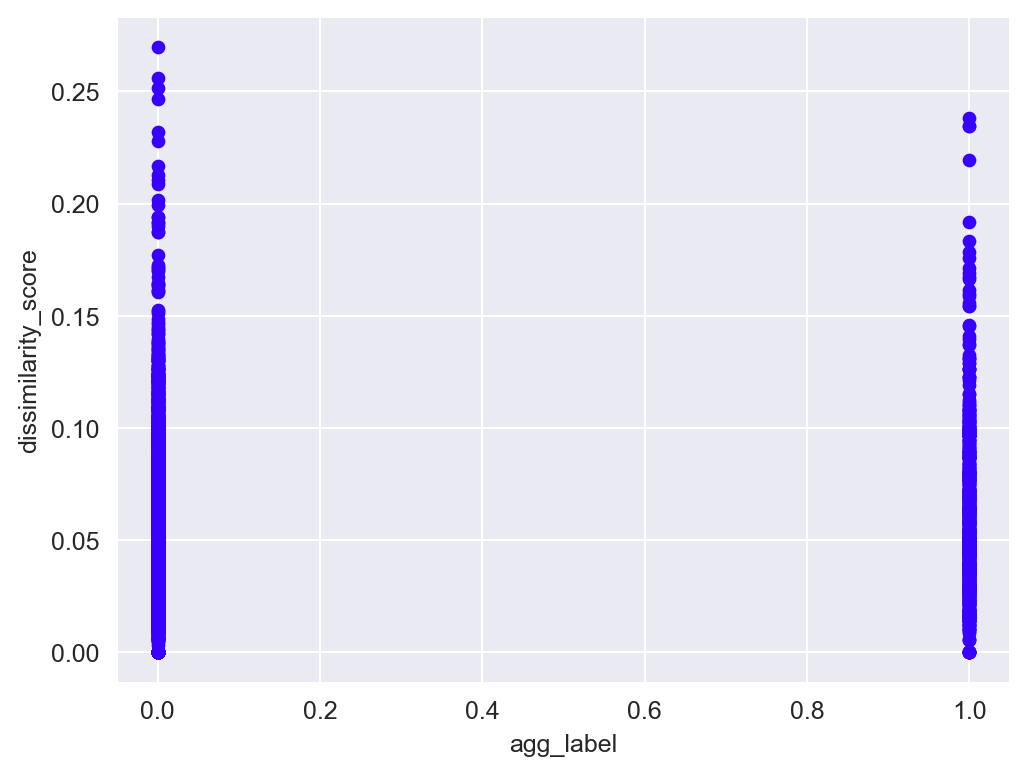

In [32]:
related_fold_aaprops.plot(kind='scatter', y='dissimilarity_score', x='agg_label')

In [613]:
mcs = []
cols_ = ['dissimilarity_score', 'blsm_mut_score', 'mutation_score', 'ratio_rank']
for L in range(0, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))

cols_ = ['dissimilarity_score', 'core_blsm_mut_score', 'core_mutation_score', 'ratio_rank']
for L in range(0, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
mcs.append(aa_cols)
mcs = list(np.unique(mcs))
mcs

[[],
 ['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8'],
 ['blsm_mut_score'],
 ['blsm_mut_score', 'mutation_score'],
 ['blsm_mut_score', 'mutation_score', 'ratio_rank'],
 ['blsm_mut_score', 'ratio_rank'],
 ['core_blsm_mut_score'],
 ['core_blsm_mut_score', 'core_mutation_score'],
 ['core_blsm_mut_score', 'core_mutation_score', 'ratio_rank'],
 ['core_blsm_mut_score', 'ratio_rank'],
 ['core_mutation_score'],
 ['core_mutation_score', 'ratio_rank'],
 ['dissimilarity_score'],
 ['dissimilarity_score', 'blsm_mut_score'],
 ['dissimilarity_score', 'blsm_mut_score', 'mutation_score'],
 ['dissimilarity_score', 'blsm_mut_score', 'mutation_score', 'ratio_rank'],
 ['dissimilarity_score', 'blsm_mut_score', 'ratio_rank'],
 ['dissimilarity_score', 'core_blsm_mut_score'],
 ['dissimilarity_score', 'core_blsm_mut_score', 'core_mutation_score'],
 ['dissimilarity_score',
  'core_blsm_mut_score',
  'core_mutation_score',
  'ratio_rank'],
 ['d

In [605]:
# Prints to terminal instead of nb
import sys
nb_stdout = sys.stdout
sys.stdout = open(1, 'w')
print('xd')

In [620]:
'-'.join(['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8'])

'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8'

In [687]:
','.join(sorted(prime_related_baseline.HLA_full.str.replace('*','').unique()))

'HLA-A01:01,HLA-A02:01,HLA-A02:06,HLA-A02:11,HLA-A03:01,HLA-A11:01,HLA-A24:02,HLA-A25:01,HLA-A26:01,HLA-A29:02,HLA-A30:01,HLA-A31:01,HLA-A33:01,HLA-A68:01,HLA-A68:02,HLA-A69:01,HLA-B07:02,HLA-B08:01,HLA-B15:01,HLA-B18:01,HLA-B27:02,HLA-B27:05,HLA-B35:01,HLA-B35:03,HLA-B37:01,HLA-B38:01,HLA-B39:01,HLA-B39:06,HLA-B40:01,HLA-B41:02,HLA-B44:02,HLA-B44:03,HLA-B49:01,HLA-B51:01,HLA-B56:01,HLA-B57:01,HLA-C01:02,HLA-C03:03,HLA-C03:04,HLA-C04:01,HLA-C05:01,HLA-C06:02,HLA-C07:01,HLA-C07:02,HLA-C08:02,HLA-C12:03,HLA-C14:03,HLA-C15:02'

In [651]:
xd = pkl_load('../output/bootstrapping/features_results.pkl')

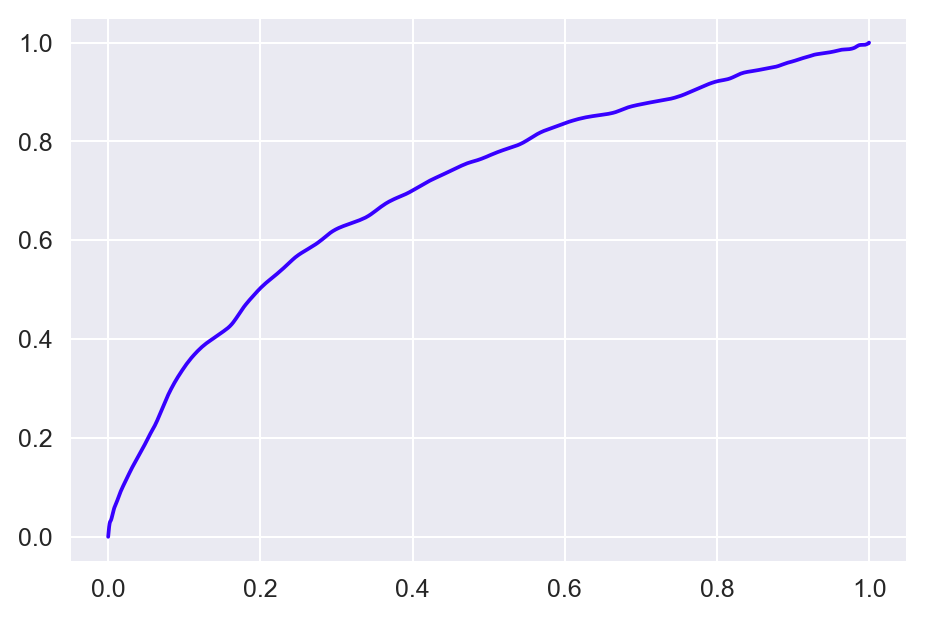

In [659]:
plt.plot(xd[0]['cedar_rocs'][0], xd[0]['cedar_rocs'][1])

# Results

In [19]:
df_results = pd.read_csv('../output/221102_new_core_mutscores/bootstrapping/total_df.csv')

## new filtered baselines

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
new_prime_baseline = prime_related_baseline.query('Peptide in @prime_peps') 
new_cedar_baseline = cedar_related_baseline.query('Peptide in @cedar_peps')

In [21]:
a,b, _ = precision_recall_curve(new_prime_baseline.agg_label.values, new_prime_baseline.PRIME_score.values)
new_prime_prauc = auc(b,a)
a,b, _ = precision_recall_curve(new_cedar_baseline.agg_label.values, new_cedar_baseline.PRIME_score.values)
new_cedar_prauc = auc(b,a)
print(f'{new_prime_prauc:.3%}', f'{new_cedar_prauc:.3%}')

9.755% 32.268%


In [22]:
new_prime_auc = roc_auc_score(new_prime_baseline.agg_label.values, new_prime_baseline.PRIME_score.values)
new_cedar_auc = roc_auc_score(new_cedar_baseline.agg_label.values, new_cedar_baseline.PRIME_score.values)
print(new_prime_auc, new_cedar_auc)

0.7201783168399867 0.671354783706279


In [23]:
len(new_prime_baseline), len(new_cedar_baseline)

(3109, 3033)

Text(0.5, 1.0, 'Baseline ROCs on CEDAR')

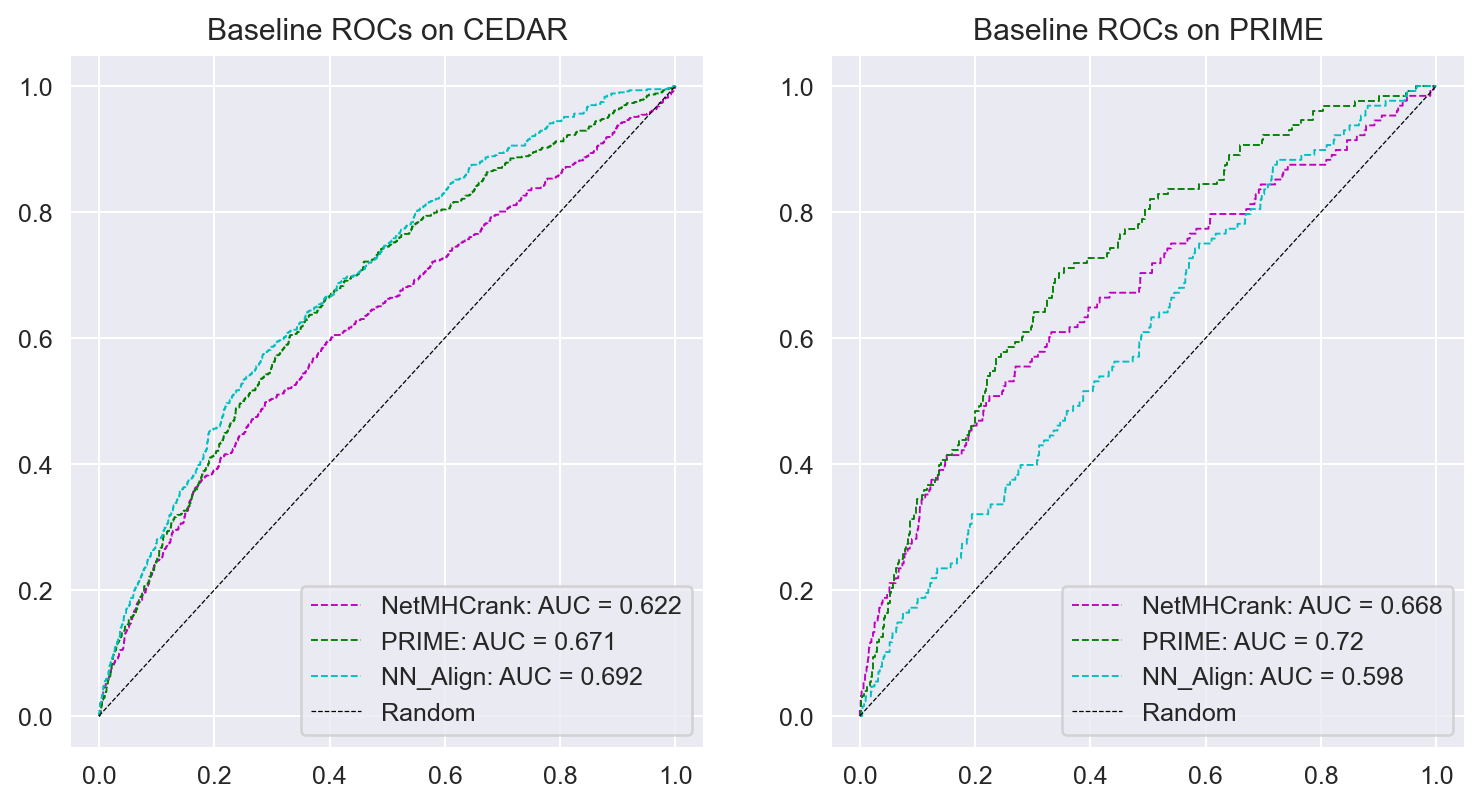

In [24]:
f,a = plt.subplots(1,2, figsize=(10,5))
plot_related_baseline_roc(axis=a[1], dataset=new_prime_baseline)
a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=new_cedar_baseline)
a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

In [25]:
def weight_name(weight):
    if weight=='None':
        return weight
    elif 'Inverted' in weight:
        weight = weight.strip('Inverted ')
        return f'IC {weight}'
    else:
        return f'(1–IC) {weight}'
df_results['weight'] = df_results['weight'].apply(weight_name)
df_results['weight'] = df_results['weight'].apply(lambda x: 'IC Shannon' if x=='IC Shanno' else x)

## reshape results

In [27]:
score_cols = ['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall']
feat_cols = ['encoding', 'weight','pep_col', 'rank_col', 'key']

df_prime = df_results.query('evalset=="PRIME"').drop(columns=['evalset']).reset_index(drop=True)
df_prime.rename(columns = {k:f'{k}_prime' for k in score_cols}, inplace=True)

df_cedar = df_results.query('evalset=="CEDAR"').drop(columns=['evalset']).reset_index(drop=True)
df_cedar.rename(columns = {k:f'{k}_cedar' for k in score_cols}, inplace=True)

df_reshape = df_cedar.merge(df_prime.drop(columns = feat_cols), left_index=True, right_index=True)

## gb_agg checks

In [28]:
# Only keep models that use EL rank mut as rank 
gb_agg = df_results.query('rank_col=="EL_rank_mut"').groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset']).agg(max_AUC=('auc', 'max'),
                                                                                                 mean_AUC=('auc', 'mean'),
                                                                                                 med_AUC=('auc', 'median'),
                                                                                                 std_AUC=('auc', 'std'), 
                                                                                                 max_PRAUC=('prauc', 'max'),
                                                                                                 mean_PRAUC=('prauc', 'mean'),
                                                                                                 med_PRAUC=('prauc', 'median'),
                                                                                                 std_PRAUC=('prauc', 'std')).reset_index('evalset')

gb_reshape = df_reshape.query('rank_col=="EL_rank_mut"').groupby(['encoding', 'weight', 'pep_col', 'rank_col', 'key']).agg(max_AUC_cedar=('auc_cedar', 'max'),
                                                                                          mean_AUC_cedar=('auc_cedar', 'mean'),
                                                                                          max_PRAUC_cedar=('prauc_cedar', 'max'),
                                                                                          mean_PRAUC_cedar=('prauc_cedar', 'mean'),
                                                                                          max_AUC_prime=('auc_prime', 'max'),
                                                                                          mean_AUC_prime=('auc_prime', 'mean'),
                                                                                          max_PRAUC_prime=('prauc_prime', 'max'),
                                                                                          mean_PRAUC_prime=('prauc_prime', 'mean'))

In [429]:
gb_agg.query('evalset=="PRIME"').reset_index('key').query('key=="only_rank"').sort_values('mean_AUC', ascending=False).head(10)

key evalset   max_AUC  \
encoding weight         pep_col   rank_col                                   
onehot   (1–IC) Mask    Peptide   EL_rank_mut  only_rank   PRIME  0.792114   
                        icore_mut EL_rank_mut  only_rank   PRIME  0.781905   
         None           Peptide   EL_rank_mut  only_rank   PRIME  0.778952   
         (1–IC) Shannon Peptide   EL_rank_mut  only_rank   PRIME  0.775688   
         (1–IC) KL      Peptide   EL_rank_mut  only_rank   PRIME  0.774002   
         IC Mask        Peptide   EL_rank_mut  only_rank   PRIME  0.772340   
BL62LO   (1–IC) Mask    Peptide   EL_rank_mut  only_rank   PRIME  0.766241   
                        icore_mut EL_rank_mut  only_rank   PRIME  0.759359   
onehot   (1–IC) KL      icore_mut EL_rank_mut  only_rank   PRIME  0.763981   
         (1–IC) Shannon icore_mut EL_rank_mut  only_rank   PRIME  0.762363   

                                               mean_AUC   med_AUC   std_AUC  \
encoding weight         pep_col   rank_col                                    
onehot   (1–IC) Mask    Peptide   EL_rank_mut  0.708984  0.709350  0.023501   
                        icore_mut EL_rank_mut  0.695110  0.695349  0.023663   
         None           Peptide   EL_rank_mut  0.686811  0.687111  0.024606   
         (1–IC) Shannon Peptide   EL_rank_mut  0.684903  0.685167  0.025034   
         (1–IC) KL      Peptide   EL_rank_mut  0.684143  0.684319  0.025178   
         IC Mask        Peptide   EL_rank_mut  0.683976  0.684285  0.024826   
BL62LO   (1–IC) Mask    Peptide   EL_rank_mut  0.678708  0.678989  0.023667   
                        icore_mut EL_rank_mut  0.675657  0.675788  0.023278   
onehot   (1–IC) KL      icore_mut EL_rank_mut  0.674860  0.674954  0.025004   
         (1–IC) Shannon icore_mut EL_rank_mut  0.674453  0.674501  0.024885   

                                               max_PRAUC  mean_PRAUC  \
encoding weight         pep_col   rank_col                             
onehot   (1–IC) Mask    Peptide   EL_rank_mut   0.190192    0.108801   
                        icore_mut EL_rank_mut   0.228102    0.105885   
         None           Peptide   EL_rank_mut   0.189304    0.107529   
         (1–IC) Shannon Peptide   EL_rank_mut   0.200220    0.113577   
         (1–IC) KL      Peptide   EL_rank_mut   0.199734    0.114534   
         IC Mask        Peptide   EL_rank_mut   0.179687    0.097547   
BL62LO   (1–IC) Mask    Peptide   EL_rank_mut   0.143914    0.080942   
                        icore_mut EL_rank_mut   0.150257    0.078530   
onehot   (1–IC) KL      icore_mut EL_rank_mut   0.231126    0.108681   
         (1–IC) Shannon icore_mut EL_rank_mut   0.236163    0.108072   

                                               med_PRAUC  std_PRAUC  
encoding weight         pep_col   rank_col                           
onehot   (1–IC) Mask    Peptide   EL_rank_mut   0.107290   0.018833  
                        icore_mut EL_rank_mut   0.104432   0.020471  
         None           Peptide   EL_rank_mut   0.106275   0.020264  
         (1–IC) Shannon Peptide   EL_rank_mut   0.112141   0.021872  
         (1–IC) KL      Peptide   EL_rank_mut   0.113084   0.022000  
         IC Mask        Peptide   EL_rank_mut   0.095804   0.018169  
BL62LO   (1–IC) Mask    Peptide   EL_rank_mut   0.079953   0.013042  
                        icore_mut EL_rank_mut   0.077526   0.013006  
onehot   (1–IC) KL      icore_mut EL_rank_mut   0.107173   0.022317  
         (1–IC) Shannon icore_mut EL_rank_mut   0.106568   0.022287

In [430]:
gb_agg.sort_values("mean_AUC", ascending=False).head(10)

evalset  \
encoding weight     pep_col   rank_col    key                                      
onehot   IC KL      Peptide   EL_rank_mut aa_props                         CEDAR   
         IC Shannon icore_mut EL_rank_mut aa_props                         CEDAR   
                    Peptide   EL_rank_mut aa_props                         CEDAR   
         IC KL      icore_mut EL_rank_mut aa_props                         CEDAR   
                    Peptide   EL_rank_mut mutation_score-ratio_rank        CEDAR   
BL62FREQ IC Shannon icore_mut EL_rank_mut aa_props                         CEDAR   
onehot   IC KL      Peptide   EL_rank_mut blsm_mut_score-mutation_score    CEDAR   
                                          core_blsm_mut_score-ratio_rank   CEDAR   
                                          blsm_mut_score-ratio_rank        CEDAR   
                                          dissimilarity_score-ratio_rank   CEDAR   

                                                                           max_AUC  \
encoding weight     pep_col   rank_col    key                                        
onehot   IC KL      Peptide   EL_rank_mut aa_props                        0.768095   
         IC Shannon icore_mut EL_rank_mut aa_props                        0.768596   
                    Peptide   EL_rank_mut aa_props                        0.768209   
         IC KL      icore_mut EL_rank_mut aa_props                        0.766998   
                    Peptide   EL_rank_mut mutation_score-ratio_rank       0.760450   
BL62FREQ IC Shannon icore_mut EL_rank_mut aa_props                        0.764420   
onehot   IC KL      Peptide   EL_rank_mut blsm_mut_score-mutation_score   0.761203   
                                          core_blsm_mut_score-ratio_rank  0.760232   
                                          blsm_mut_score-ratio_rank       0.759753   
                                          dissimilarity_score-ratio_rank  0.757711   

                                                                          mean_AUC  \
encoding weight     pep_col   rank_col    key                                        
onehot   IC KL      Peptide   EL_rank_mut aa_props                        0.727865   
         IC Shannon icore_mut EL_rank_mut aa_props                        0.727794   
                    Peptide   EL_rank_mut aa_props                        0.727470   
         IC KL      icore_mut EL_rank_mut aa_props                        0.726676   
                    Peptide   EL_rank_mut mutation_score-ratio_rank       0.722555   
BL62FREQ IC Shannon icore_mut EL_rank_mut aa_props                        0.722323   
onehot   IC KL      Peptide   EL_rank_mut blsm_mut_score-mutation_score   0.722136   
                                          core_blsm_mut_score-ratio_rank  0.721922   
                                          blsm_mut_score-ratio_rank       0.721696   
                                          dissimilarity_score-ratio_rank  0.721516   

                                                                           med_AUC  \
encoding weight     pep_col   rank_col    key                                        
onehot   IC KL      Peptide   EL_rank_mut aa_props                        0.728156   
         IC Shannon icore_mut EL_rank_mut aa_props                        0.727926   
                    Peptide   EL_rank_mut aa_props                        0.727690   
         IC KL      icore_mut EL_rank_mut aa_props                        0.726775   
                    Peptide   EL_rank_mut mutation_score-ratio_rank       0.722690   
BL62FREQ IC Shannon icore_mut EL_rank_mut aa_props                        0.722404   
onehot   IC KL      Peptide   EL_rank_mut blsm_mut_score-mutation_score   0.722237   
                                          core_blsm_mut_score-ratio_rank  0.722049   
                                          blsm_mut_score-ratio_rank       0.721873   
                                          dissimilar

## quick pvalue stuff

In [293]:
gb_agg.sort_values('mean_AUC', ascending=False).head(20).reset_index()\
                                        .query('evalset=="CEDAR"')[['encoding', 'weight', 'pep_col', 'rank_col' ,'key']].values

array([['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted KL', 'icore_mut', 'EL_rank_mut', 'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'mutation_score-ratio_rank'],
       ['BL62FREQ', 'Inverted Shannon', 'icore_mut', 'EL_rank_mut',
        'aa_props'],
       ['onehot', 'Inverted Shannon', 'Peptide', 'trueHLA_EL_rank',
        'aa_props'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-mutation_score'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'core_blsm_mut_score-ratio_rank'],
       ['onehot', 'Inverted KL', 'Peptide', 'EL_rank_mut',
        'blsm_mut_score-ratio_rank'],
       ['onehot', 'Inve

In [180]:
auc_a = df_a.auc.values
auc_b = df_results.query('encoding=="BL62FREQ" and evalset=="CEDAR" and rank_col=="EL_rank_mut" and key=="aa_props" and pep_col=="icore_mut" and weight=="Shannon"').auc.values
a_over_b = [x>y for x,y in zip(auc_a, auc_b)]
pval = 1 - (len((auc_a>auc_b).astype(int).nonzero()[0]) / 10000 )
pval

0.0010999999999999899

In [248]:
df_results.columns

Index(['auc', 'prauc', 'AP', 'auc_01', 'f1', 'accuracy', 'precision', 'recall',
       'encoding', 'weight', 'pep_col', 'rank_col', 'key', 'evalset'],
      dtype='object')

## top means et

In [29]:
auc_cols = ['max_AUC_cedar', 'mean_AUC_cedar', 'mean_PRAUC_cedar', 'max_AUC_prime', 'mean_AUC_prime', 'mean_PRAUC_prime']
top25_mean_cedar = gb_reshape.sort_values('mean_AUC_cedar', ascending=False).head(25)
top25_mean_prcedar = gb_reshape.sort_values('mean_PRAUC_cedar', ascending=False).head(25)
top25_mean_prime = gb_reshape.sort_values('mean_AUC_prime', ascending=False).head(25)
top25_mean_prprime = gb_reshape.sort_values('mean_PRAUC_prime', ascending=False).head(25)

In [ ]:
from IPython.core.display import display, HTML
output = top25_mean_cedar[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))


In [ ]:
top25_mean_cedar[auc_cols]

In [685]:
tmp = top25_mean_cedar.reset_index('key').groupby('key').agg(x=('max_AUC_cedar','count'))
appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in appearances.keys():
            appearances[n]+=v
        else:
            appearances[n]=v
appearances

In [686]:
appearances

{'aa_props': 5,
 'blsm_mut_score': 8,
 'mutation_score': 10,
 'ratio_rank': 12,
 'core_blsm_mut_score': 3,
 'core_mutation_score': 2,
 'dissimilarity_score': 8}

In [672]:
from IPython.core.display import display, HTML
output = top25_mean_prime[auc_cols].head(15).to_html(formatters={col: '{:,.3%}'.format for col in auc_cols})
display(HTML(output))


In [687]:
tmp = top25_mean_prime.reset_index('key').groupby('key').agg(x=('max_AUC_cedar','count'))
appearances={}
idx=list(tmp.index)
vals=tmp.x.values
for k,v in zip(idx,vals):
    names = k.split('-')
    for n in names:
        if n in appearances.keys():
            appearances[n]+=v
        else:
            appearances[n]=v
appearances

{'blsm_mut_score': 8,
 'mutation_score': 5,
 'ratio_rank': 2,
 'core_blsm_mut_score': 9,
 'core_mutation_score': 9,
 'dissimilarity_score': 12,
 'only_rank': 1}

In [424]:
display(top25_mean_prime.iloc[0])
top25_mean_prime.reset_index('key').groupby('key').agg(count=('mean_AUC_prime','count'))

max_AUC_cedar       0.742955
mean_AUC_cedar      0.699172
max_PRAUC_cedar     0.446166
mean_PRAUC_cedar    0.375032
max_AUC_prime       0.799025
mean_AUC_prime      0.715095
max_PRAUC_prime     0.201122
mean_PRAUC_prime    0.112765
Name: (onehot, (1–IC) Mask, Peptide, EL_rank_mut, core_blsm_mut_score-core_mutation_score), dtype: float64

count
key                                                      
blsm_mut_score                                          3
blsm_mut_score-mutation_score                           2
core_blsm_mut_score                                     2
core_blsm_mut_score-core_mutation_score                 3
core_mutation_score                                     2
dissimilarity_score                                     1
dissimilarity_score-blsm_mut_score                      2
dissimilarity_score-blsm_mut_score-mutation_score       1
dissimilarity_score-core_blsm_mut_score                 2
dissimilarity_score-core_blsm_mut_score-core_mu...      2
dissimilarity_score-core_mutation_score                 2
dissimilarity_score-mutation_score                      1
mutation_score                                          1
only_rank                                               1

In [425]:
display(top25_mean_cedar.iloc[0])
top25_mean_cedar.reset_index('key').groupby('key').agg(count=('mean_AUC_cedar','count'))

max_AUC_cedar       0.768095
mean_AUC_cedar      0.727865
max_PRAUC_cedar     0.491444
mean_PRAUC_cedar    0.418566
max_AUC_prime       0.746858
mean_AUC_prime      0.654866
max_PRAUC_prime     0.161283
mean_PRAUC_prime    0.077870
Name: (onehot, IC KL, Peptide, EL_rank_mut, aa_props), dtype: float64

count
key                                                      
aa_props                                                8
blsm_mut_score-mutation_score                           2
blsm_mut_score-mutation_score-ratio_rank                1
blsm_mut_score-ratio_rank                               1
core_blsm_mut_score                                     1
core_blsm_mut_score-core_mutation_score                 1
core_blsm_mut_score-ratio_rank                          1
core_mutation_score-ratio_rank                          1
dissimilarity_score-blsm_mut_score                      1
dissimilarity_score-blsm_mut_score-mutation_sco...      2
dissimilarity_score-mutation_score                      1
dissimilarity_score-mutation_score-ratio_rank           1
dissimilarity_score-ratio_rank                          1
mutation_score-ratio_rank                               2
ratio_rank                                              1

PRIME only has Mask as weight when looking at top 25 mean/median AUCs 

CEDAR only has Inverted (Shannon or KL), i.e. 1-IC when looking at top 25 mean/median AUCs

# plots

## Initial boxplot (Encoding vs Input) 

Text(0.5, 1.0, 'Test AUC (PRIME) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

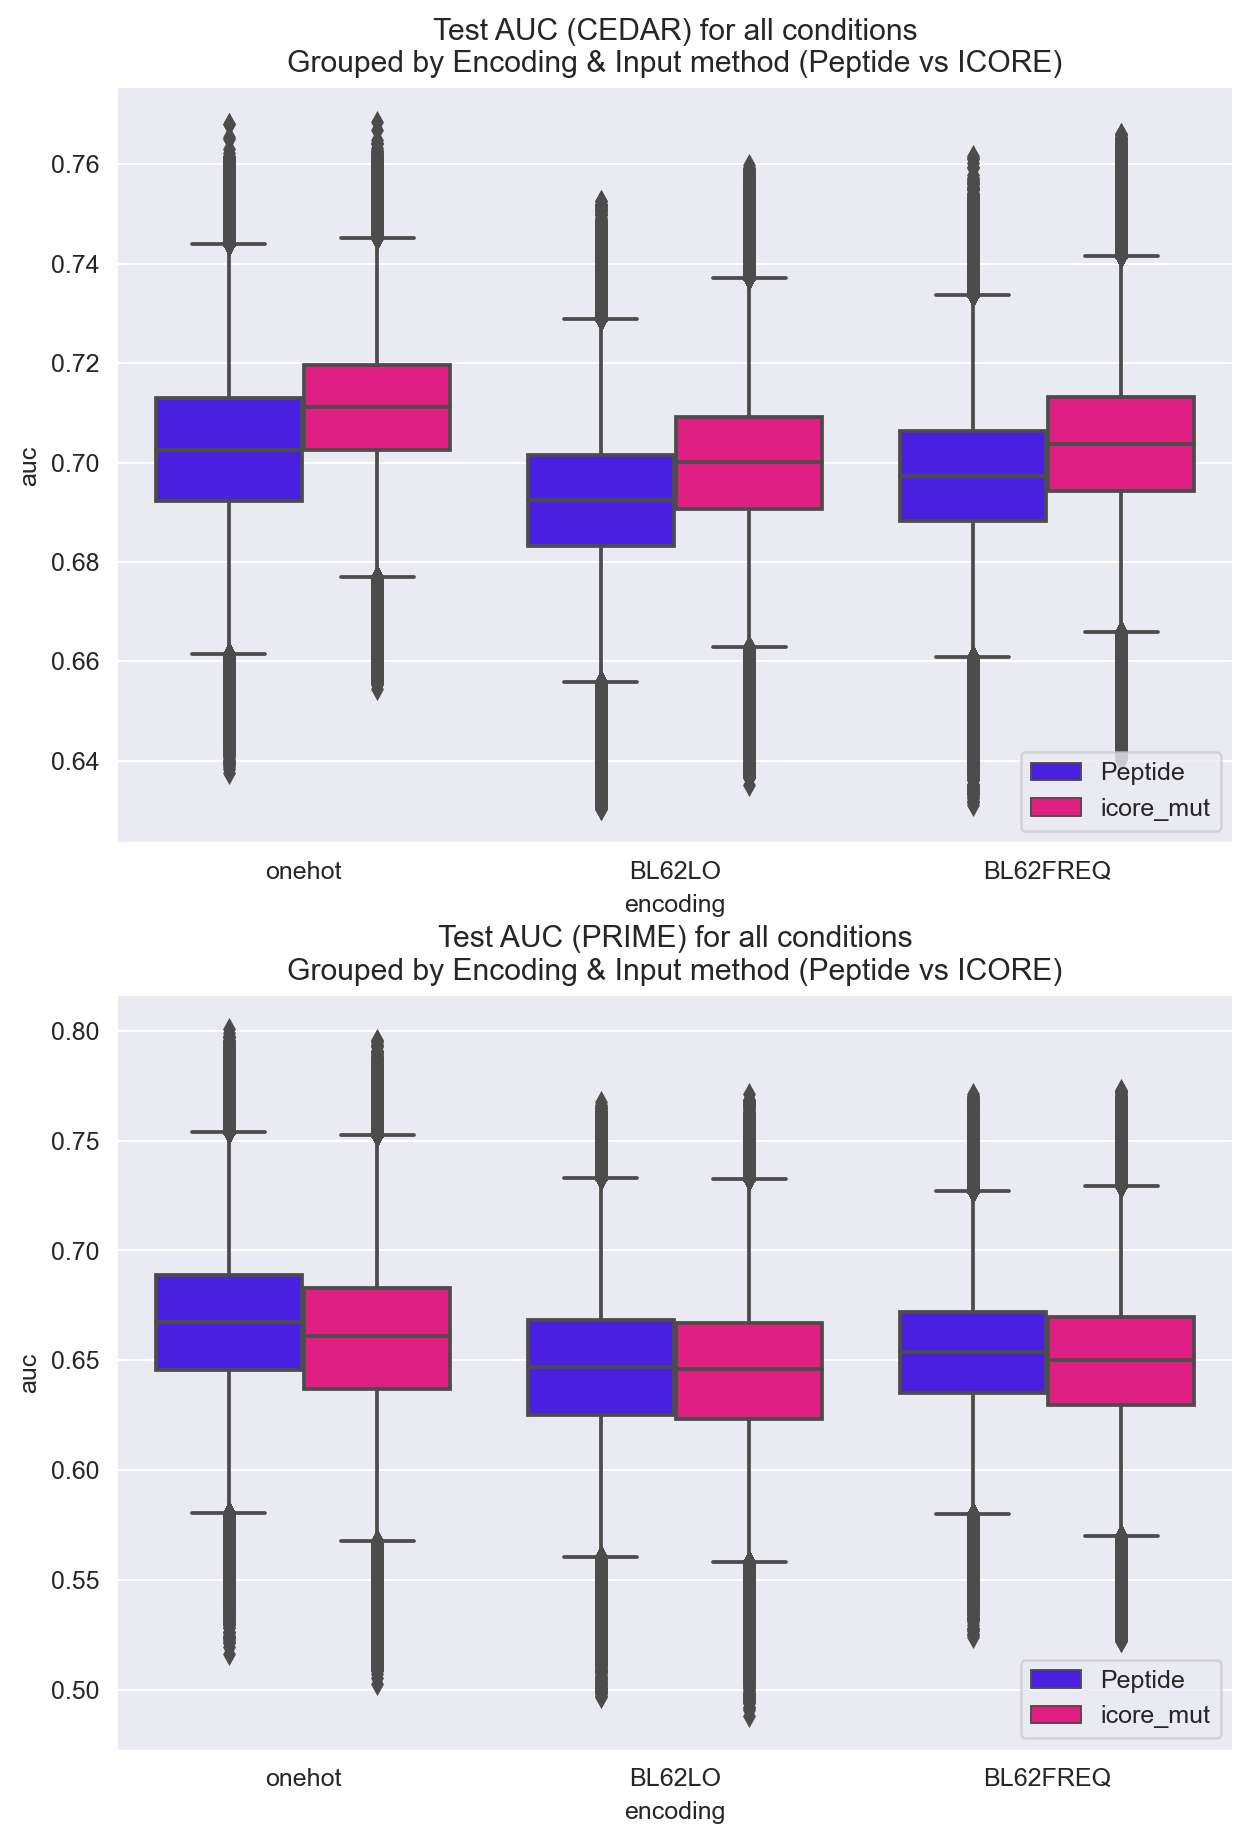

In [316]:
f,a = plt.subplots(2,1, figsize=(8,12))
tmp_ = df_results.query('evalset=="CEDAR"')
sns.boxplot(data=tmp_, hue='pep_col', x='encoding', y='auc', ax=a[0])
plt.setp(a[0].collections, alpha=.75)
a[0].legend(loc='lower right')
a[0].set_title('Test AUC (CEDAR) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

tmp_ = df_results.query('evalset=="PRIME"')
sns.boxplot(data=tmp_, hue='pep_col', x='encoding', y='auc', ax=a[1])
plt.setp(a[1].collections, alpha=.75)
a[1].legend(loc='lower right')
a[1].set_title('Test AUC (PRIME) for all conditions\nGrouped by Encoding & Input method (Peptide vs ICORE)')

## checking weights for OneHot encoding

In [30]:
order = ['KL', 'Shannon', 'Mask', 'None', 'Inverted Mask', 'Inverted Shannon', 'Inverted KL']
renamed_order = list(map(weight_name, order))

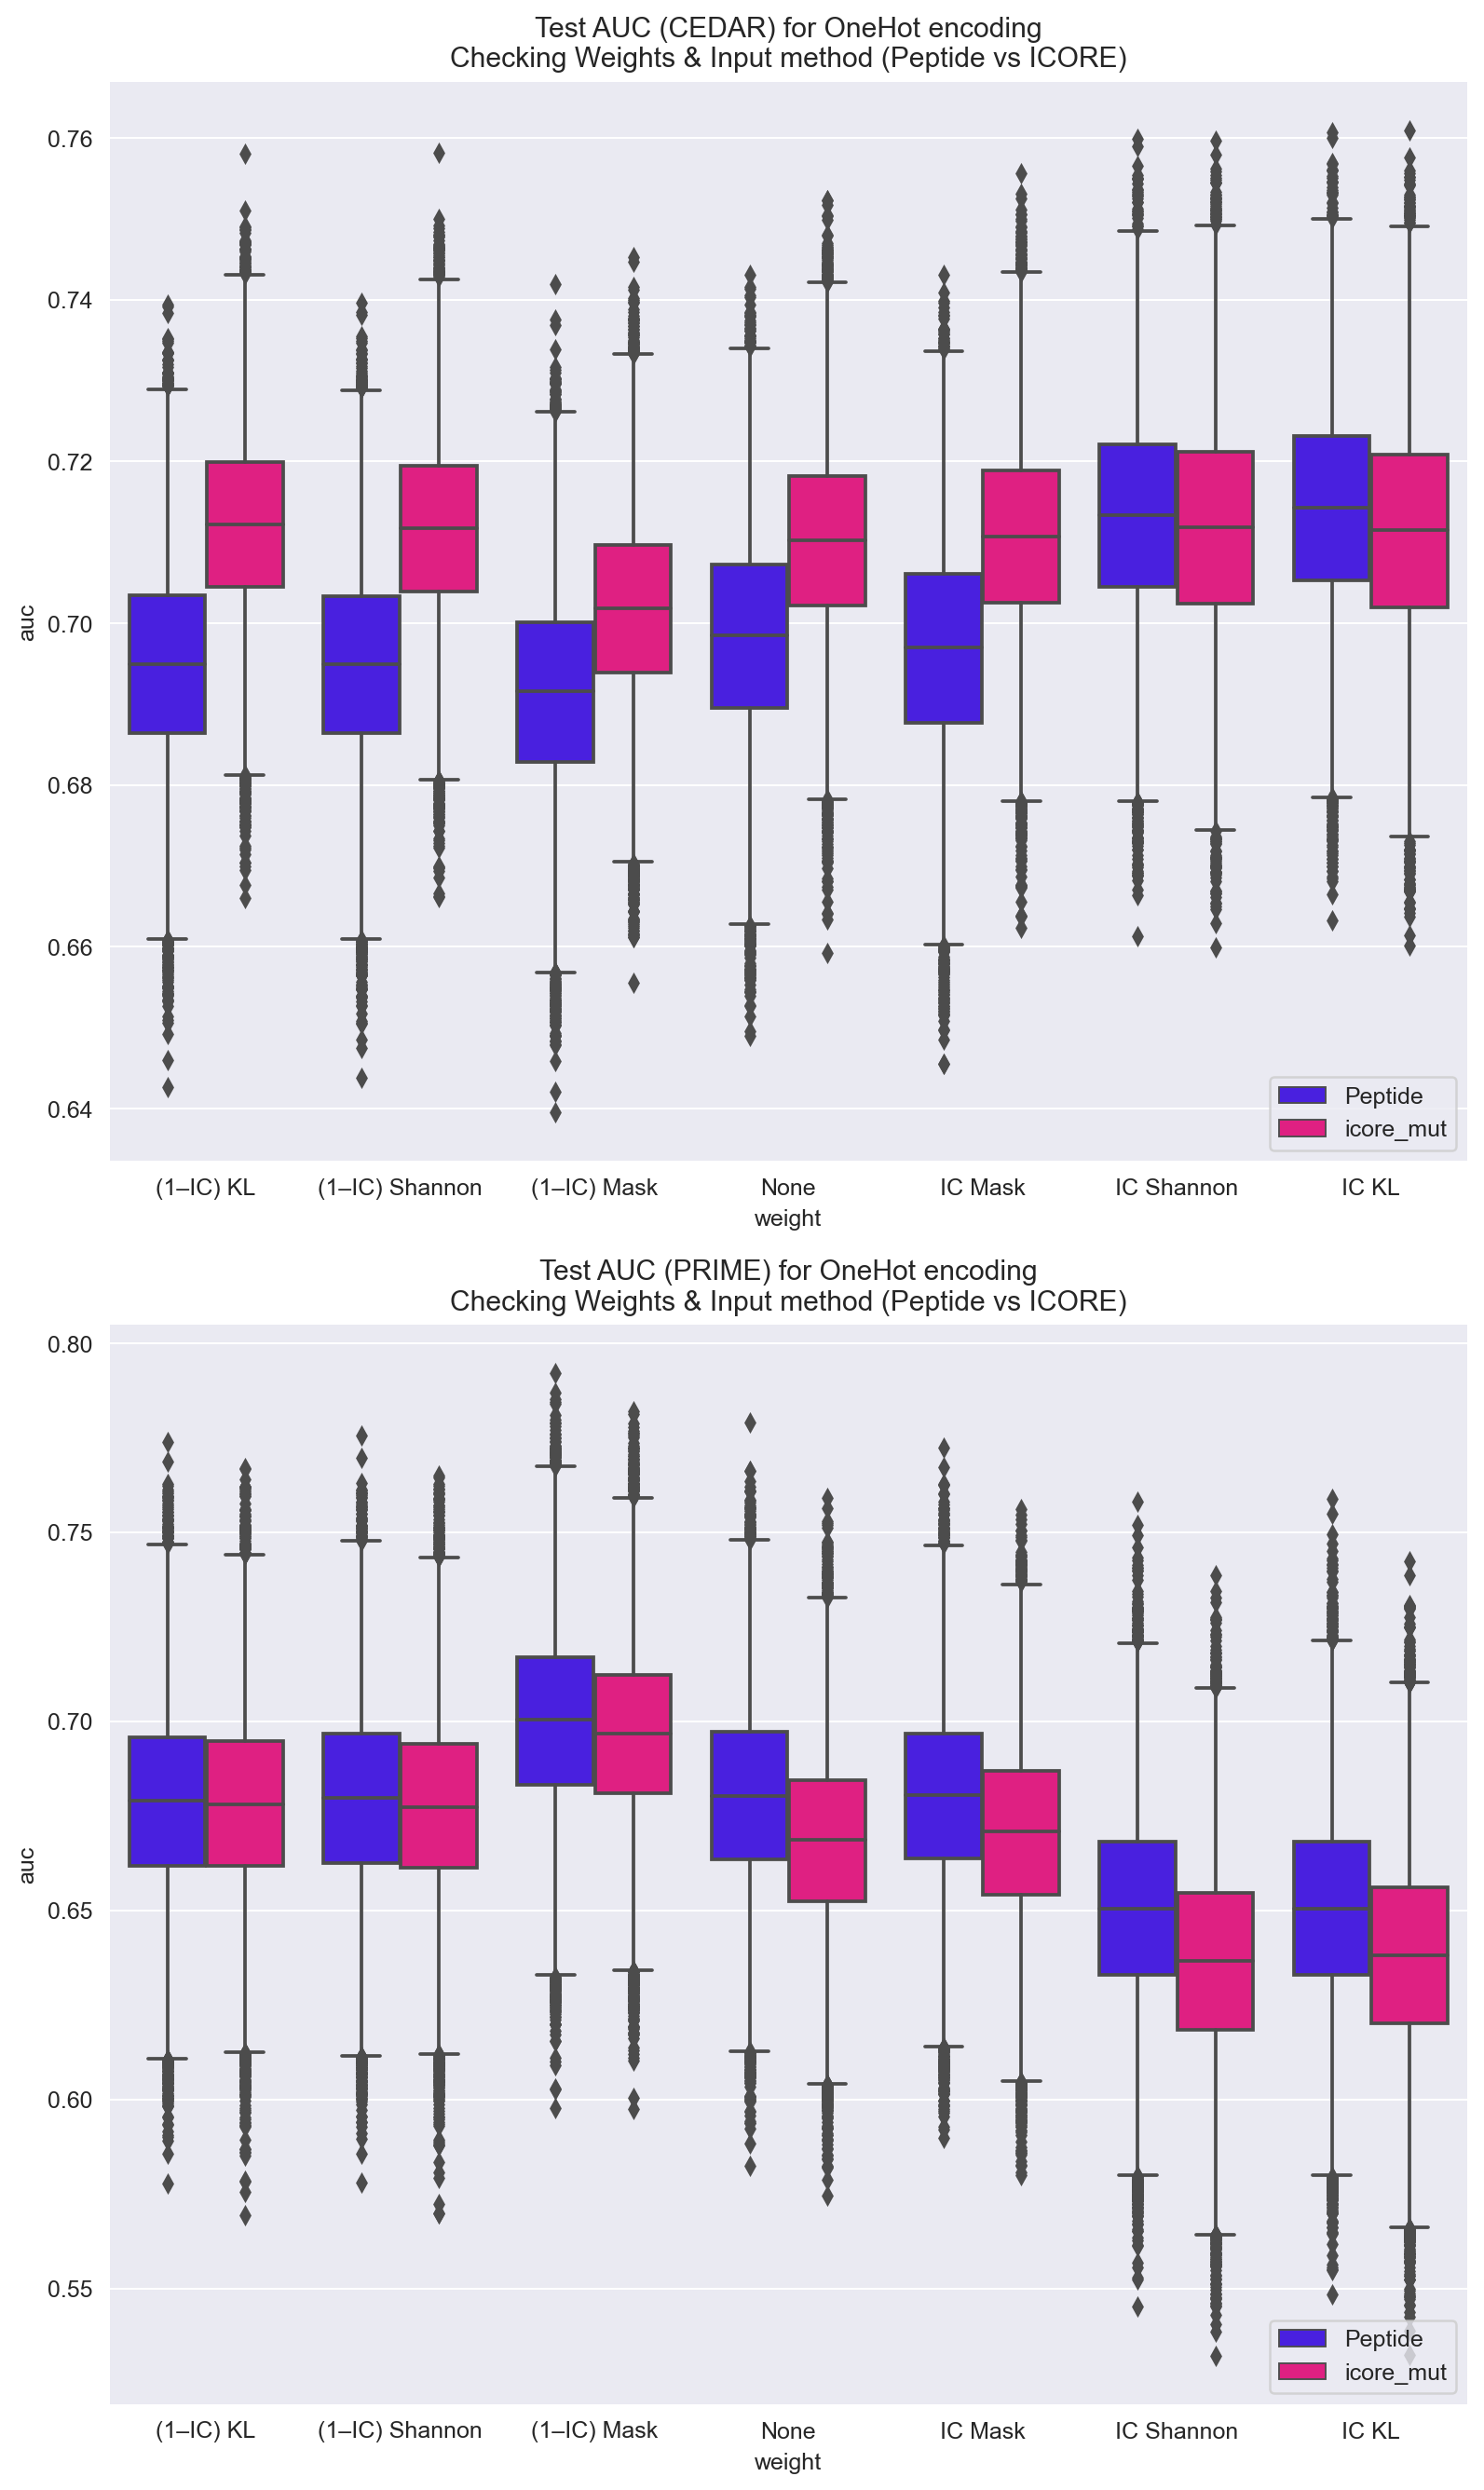

In [695]:
f,a = plt.subplots(2,1, figsize=(9,15))


tmp_ = df_results.query('evalset=="CEDAR" and encoding=="onehot" and key=="only_rank"')
sns.boxplot(data=tmp_, hue='pep_col', x='weight', y='auc', ax=a[0], order=renamed_order)
plt.setp(a[0].collections, alpha=.75)
a[0].legend(loc='lower right')
a[0].set_title('Test AUC (CEDAR) for OneHot encoding\nChecking Weights & Input method (Peptide vs ICORE)')

tmp_ = df_results.query('evalset=="PRIME" and encoding=="onehot" and key=="only_rank"')
sns.boxplot(data=tmp_, hue='pep_col', x='weight', y='auc', ax=a[1], order=renamed_order)
plt.setp(a[1].collections, alpha=.75)
a[1].legend(loc='lower right')
a[1].set_title('Test AUC (PRIME) for OneHot encoding\nChecking Weights & Input method (Peptide vs ICORE)')

f.tight_layout(pad=1.25)

## Feature columns / scores

In [434]:
df_reshape.columns

Index(['auc_cedar', 'prauc_cedar', 'AP_cedar', 'auc_01_cedar', 'f1_cedar',
       'accuracy_cedar', 'precision_cedar', 'recall_cedar', 'encoding',
       'weight', 'pep_col', 'rank_col', 'key', 'auc_prime', 'prauc_prime',
       'AP_prime', 'auc_01_prime', 'f1_prime', 'accuracy_prime',
       'precision_prime', 'recall_prime'],
      dtype='object')

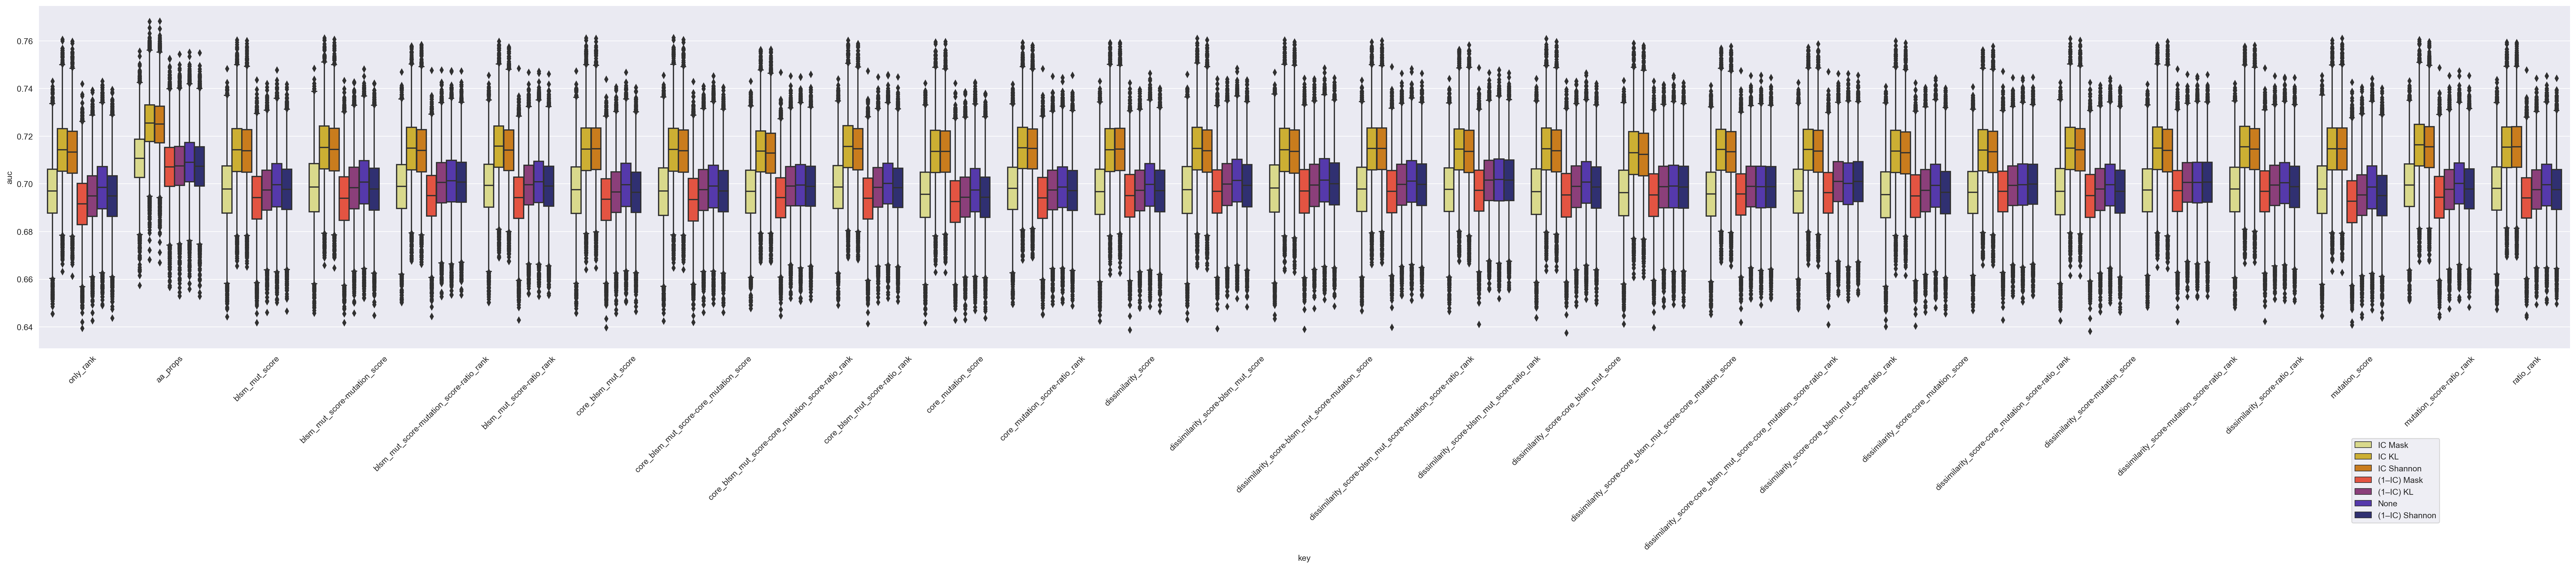

In [442]:
f,a = plt.subplots(1,1, figsize=(55,7.5))
cmr_pal = sns.color_palette('CMRmap_r', 7)
sns.set_palette(cmr_pal)
tmp_ = df_results.query('evalset=="CEDAR" and encoding=="onehot" and pep_col=="Peptide"')
sns.boxplot(data=tmp_, x = 'key', hue = 'weight', y = 'auc')
a.set_xticklabels(a.get_xticklabels(), rotation=45)
a.legend(bbox_to_anchor=(0.95, -0.25))

## Only look at weights that are IC shannon or IC KL as they are the top (group them together)

In [31]:
from copy import deepcopy
keys = df_reshape.key.unique()
mut_keys = [x for x in keys if 'mut' in x]
base_keys = [x for x in keys if x not in mut_keys]
core_keys = deepcopy(base_keys)
core_keys.extend([x for x in mut_keys if "core_" in x])
non_core_keys = deepcopy(base_keys)
non_core_keys.extend([x for x in mut_keys if "core_" not in x])

In [32]:
len(core_keys), len(non_core_keys), len(keys)

(17, 17, 29)

### Doing for stuff that works for CEDAR

In [475]:
tmp_core = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
tmp_non = df_results.query('(weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

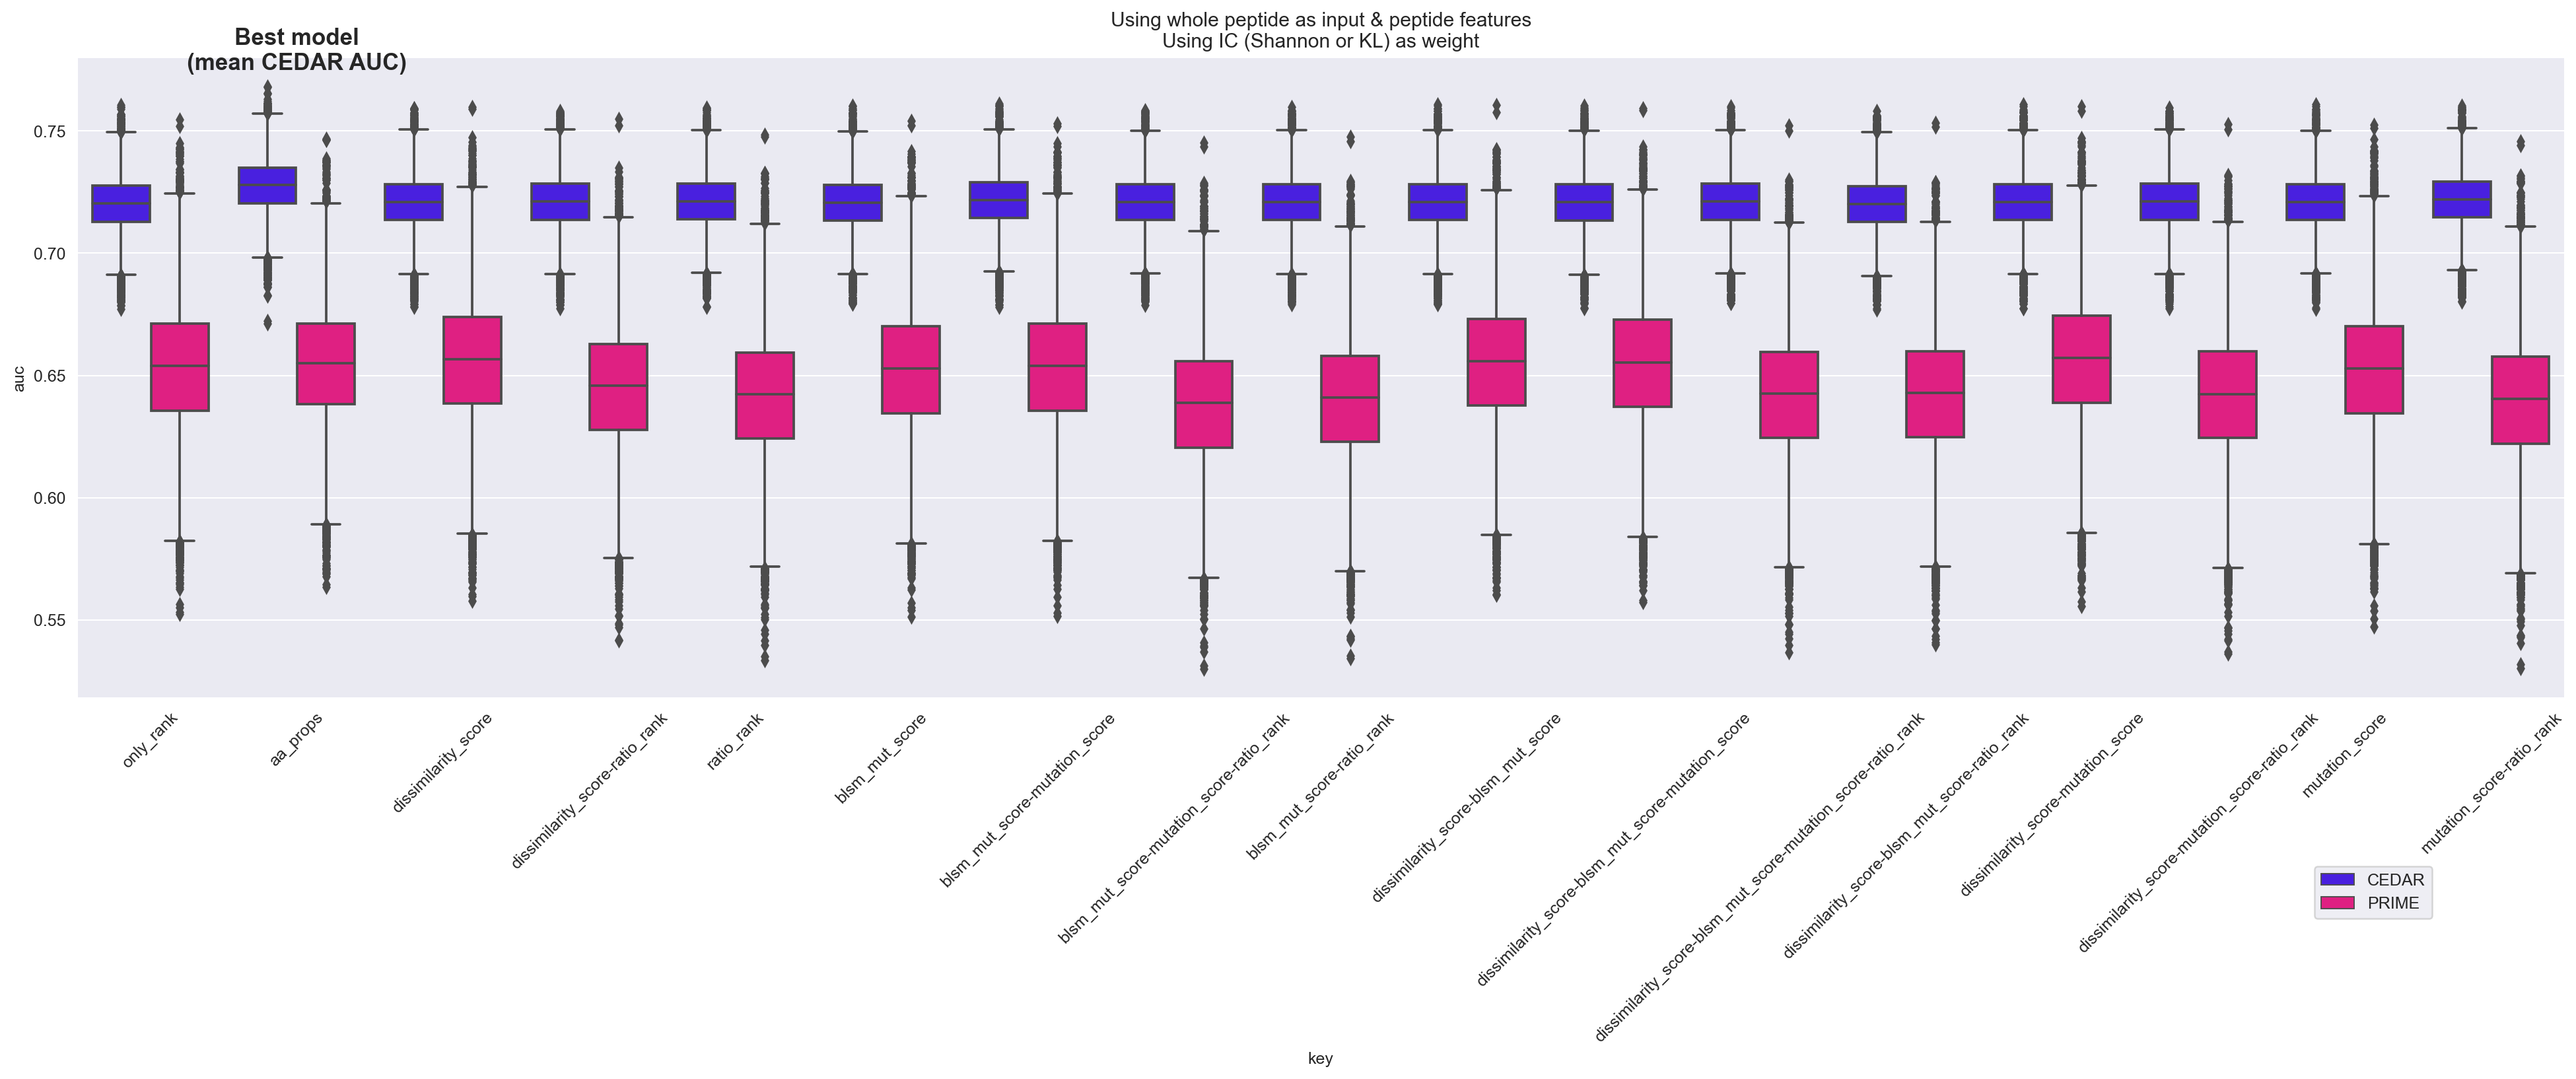

In [519]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_non.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})
a.legend(bbox_to_anchor=(0.95, -0.25))

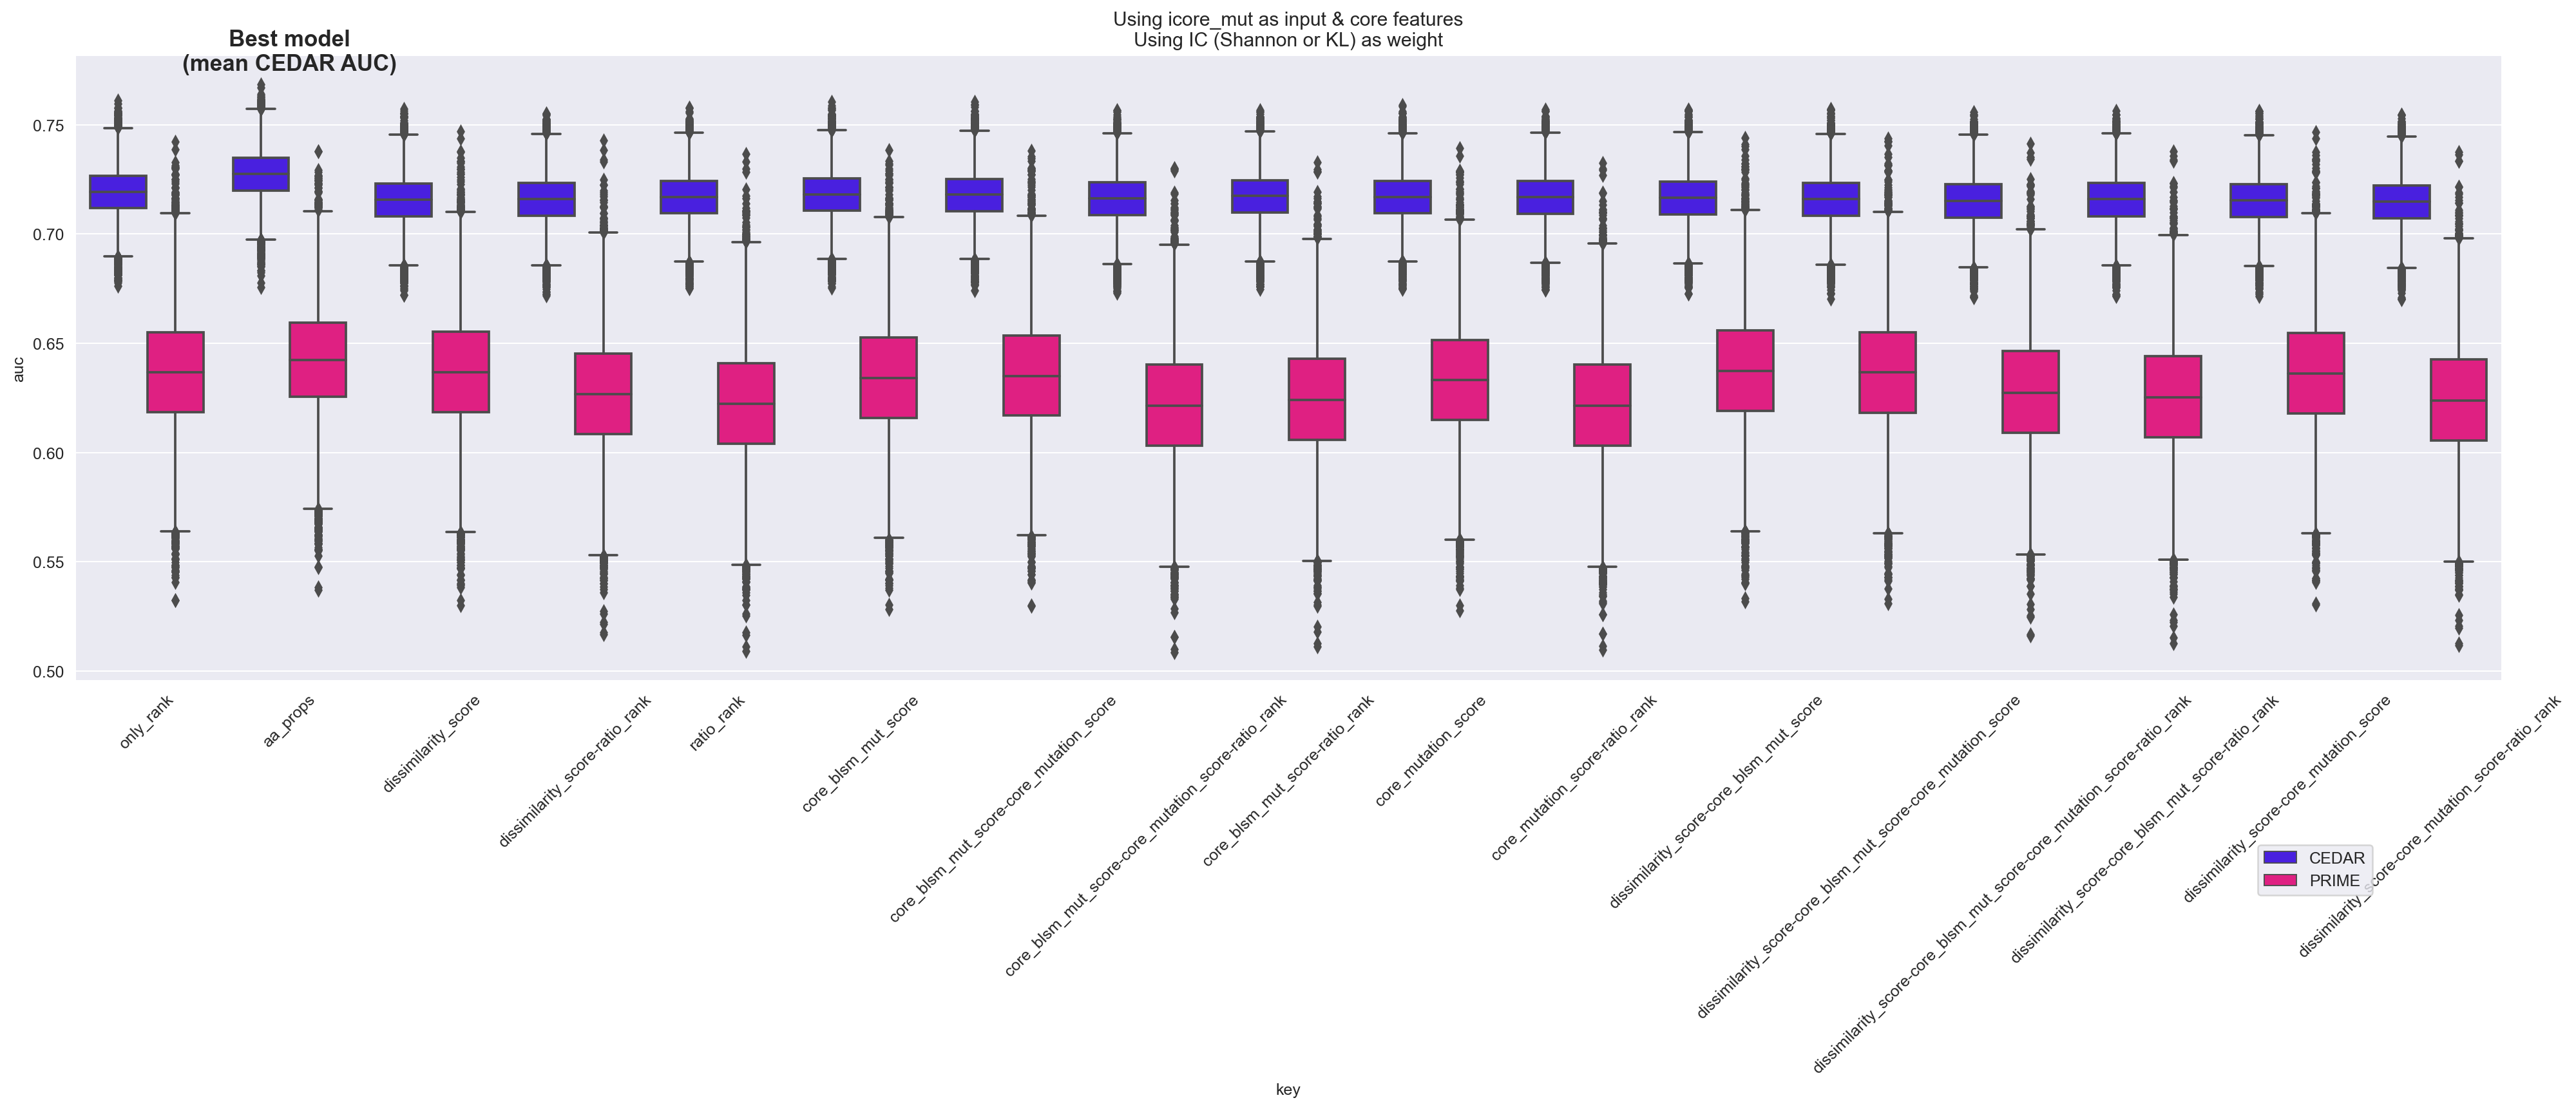

In [518]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing IC (Shannon or KL) as weight')

max_name = tmp_core.query('evalset=="CEDAR"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.775, "Best model\n(mean CEDAR AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

### Repeat for stuff that works for PRIME

In [482]:
prime_tmp_core = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="icore_mut" and key in @core_keys')
prime_tmp_non = df_results.query('(weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and pep_col=="Peptide" and key in @non_core_keys')

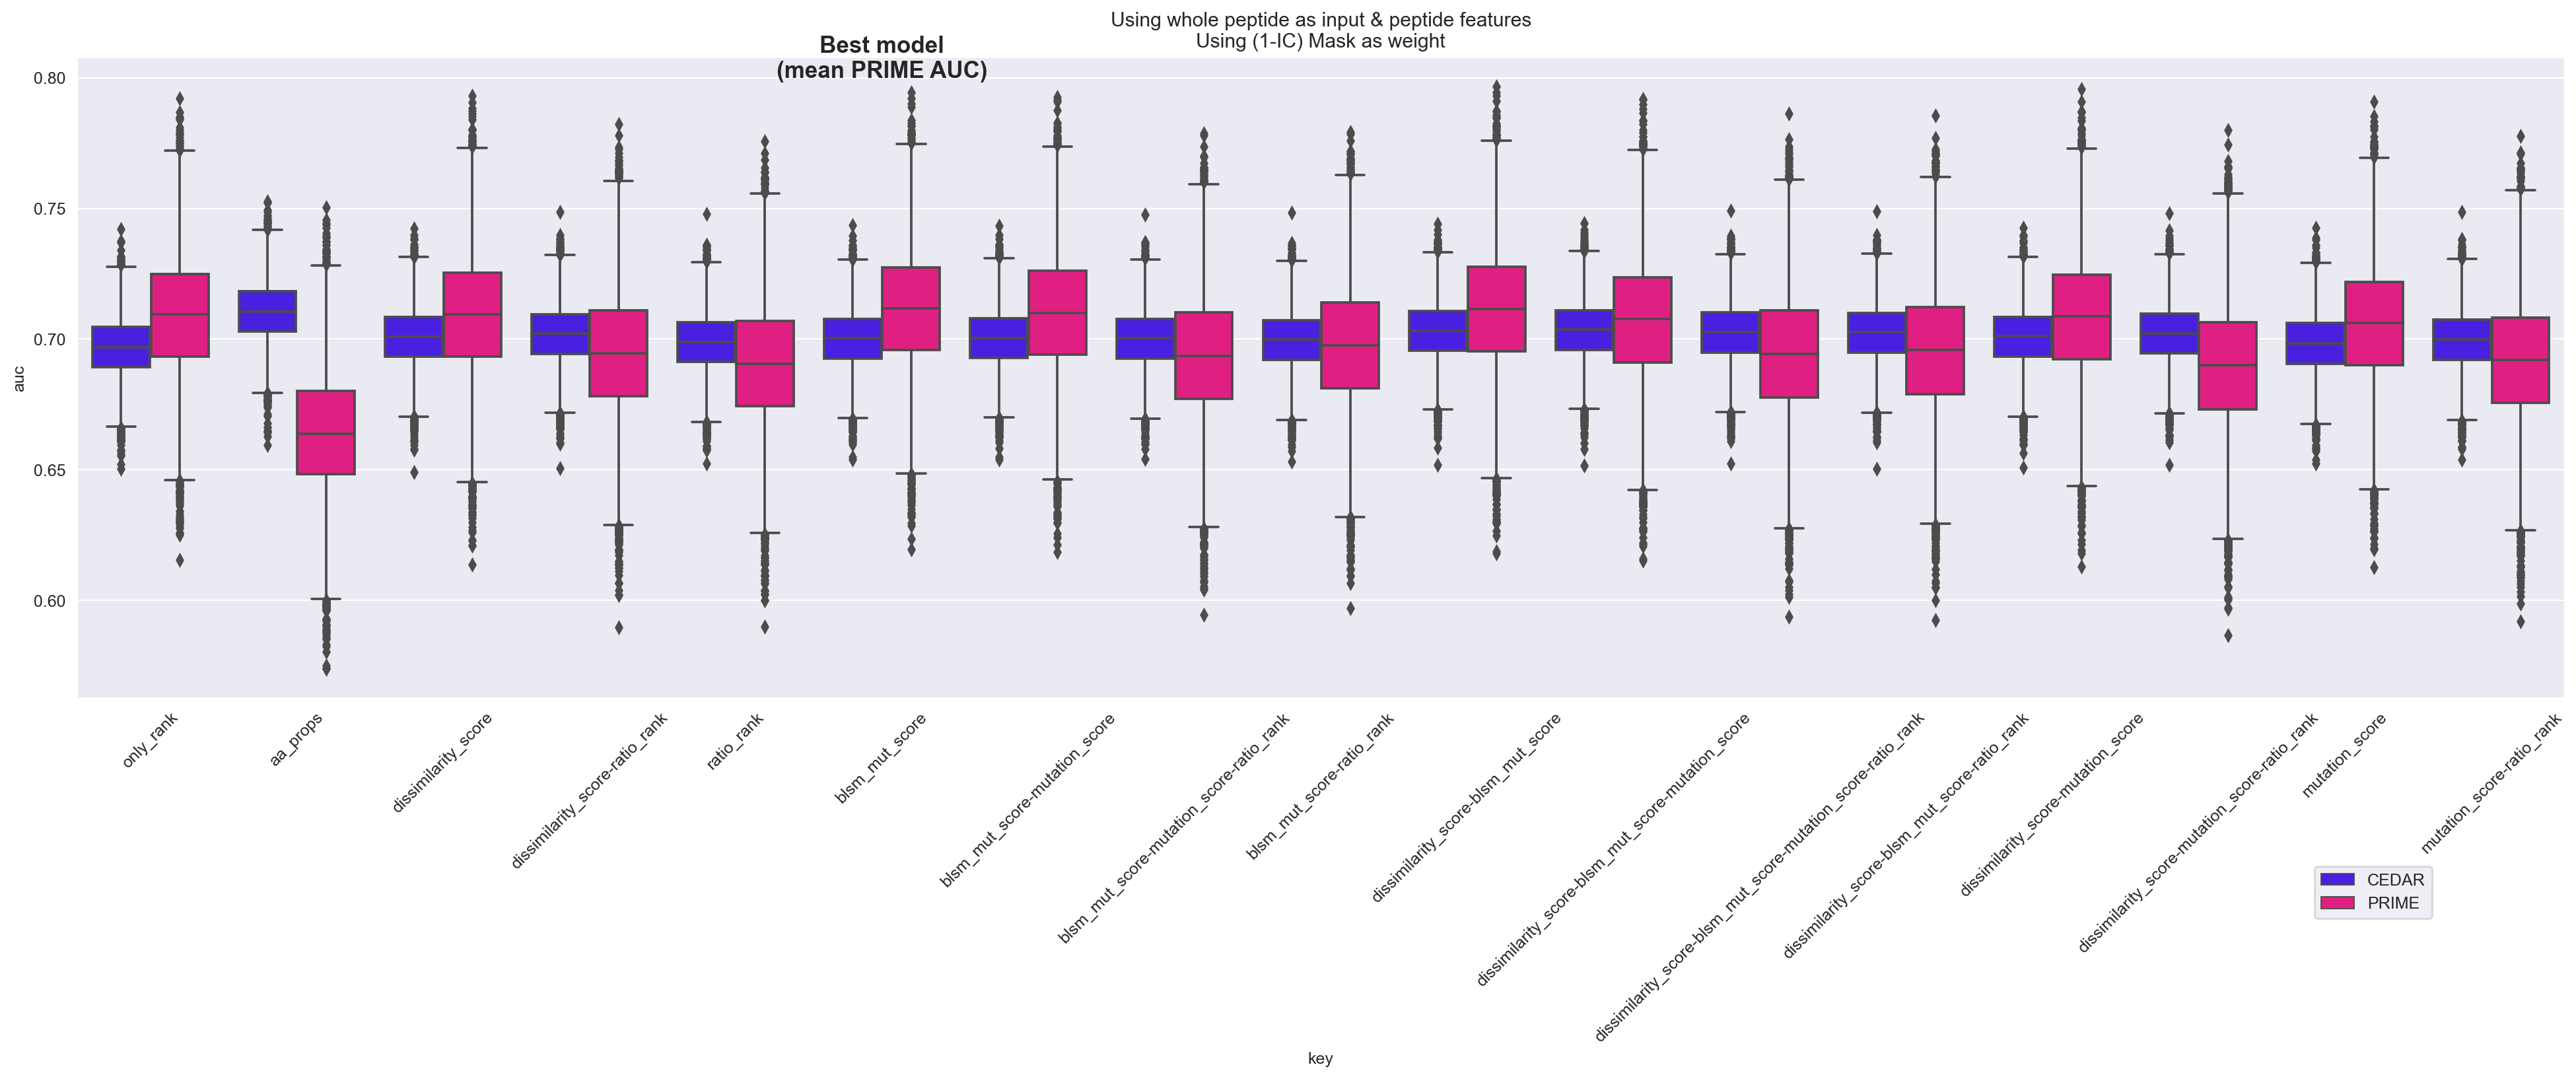

In [517]:
sns.set_palette(HSV)
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_non, x = 'key', hue = 'evalset', y = 'auc', order=non_core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using whole peptide as input & peptide features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_non.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = non_core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.25))

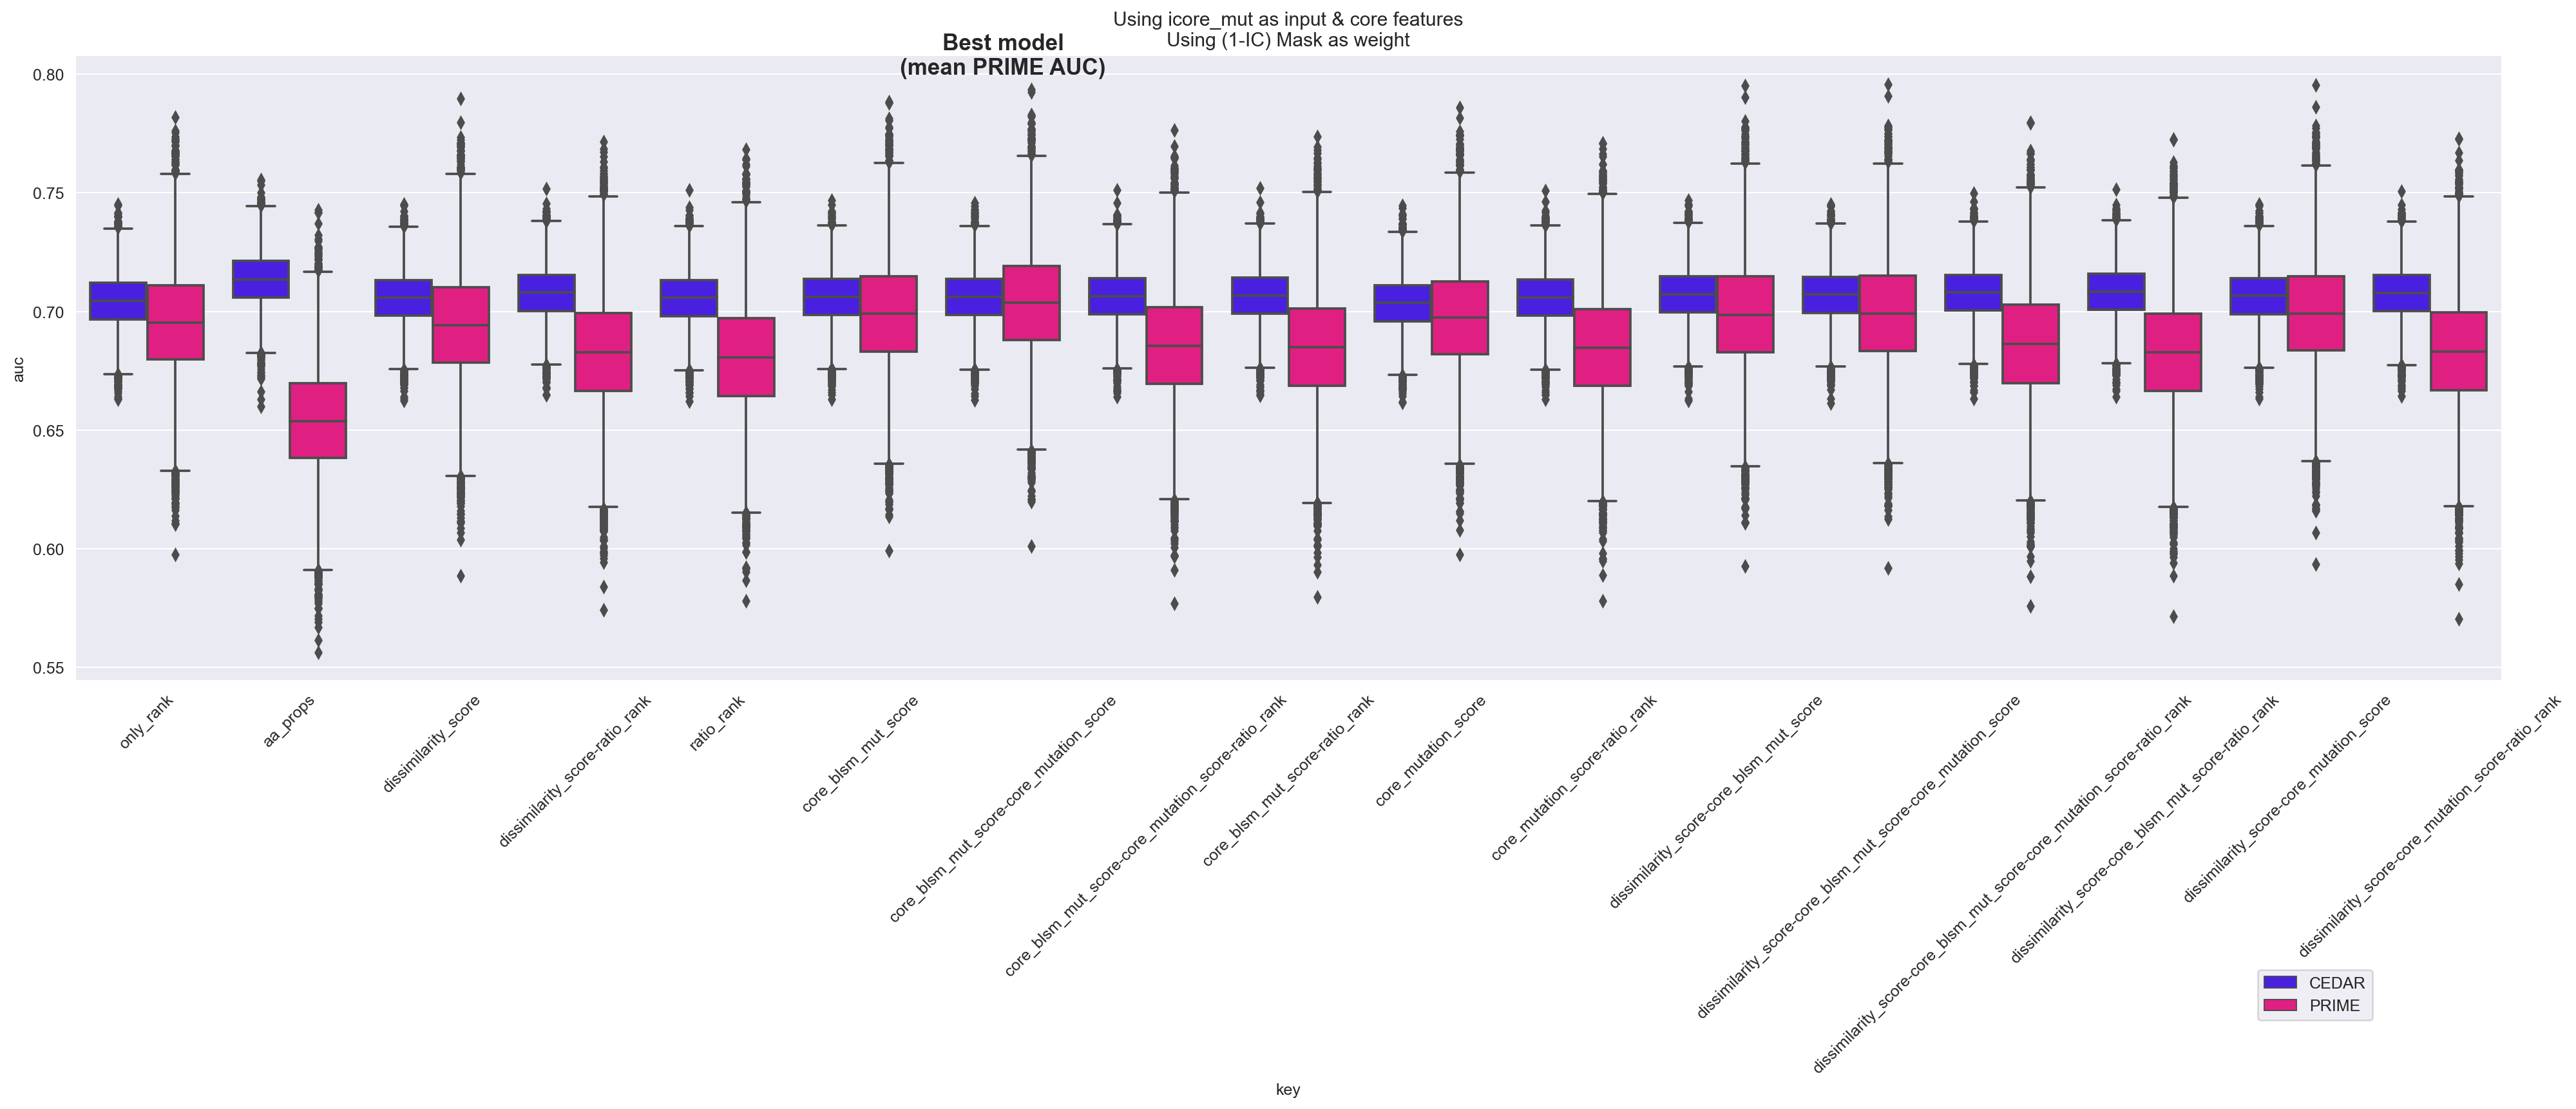

In [522]:
f,a =plt.subplots(1,1, figsize=(27, 7))
sns.boxplot(data=prime_tmp_core, x = 'key', hue = 'evalset', y = 'auc', order=core_keys)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.setp(a.collections, alpha=0.75)
a.set_title('Using icore_mut as input & core features\nUsing (1-IC) Mask as weight')

max_name = prime_tmp_core.query('evalset=="PRIME"').groupby('key').agg(mean_AUC=('auc','mean')).sort_values('mean_AUC', ascending=False).iloc[0].name
max_idx = core_keys.index(max_name)
a.text(max_idx, 0.8, "Best model\n(mean PRIME AUC)", fontdict={'fontweight':'semibold', 'fontsize':14, 'horizontalalignment':'center'})

a.legend(bbox_to_anchor=(0.95, -0.45))

## non mutscore feats comparison

Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')

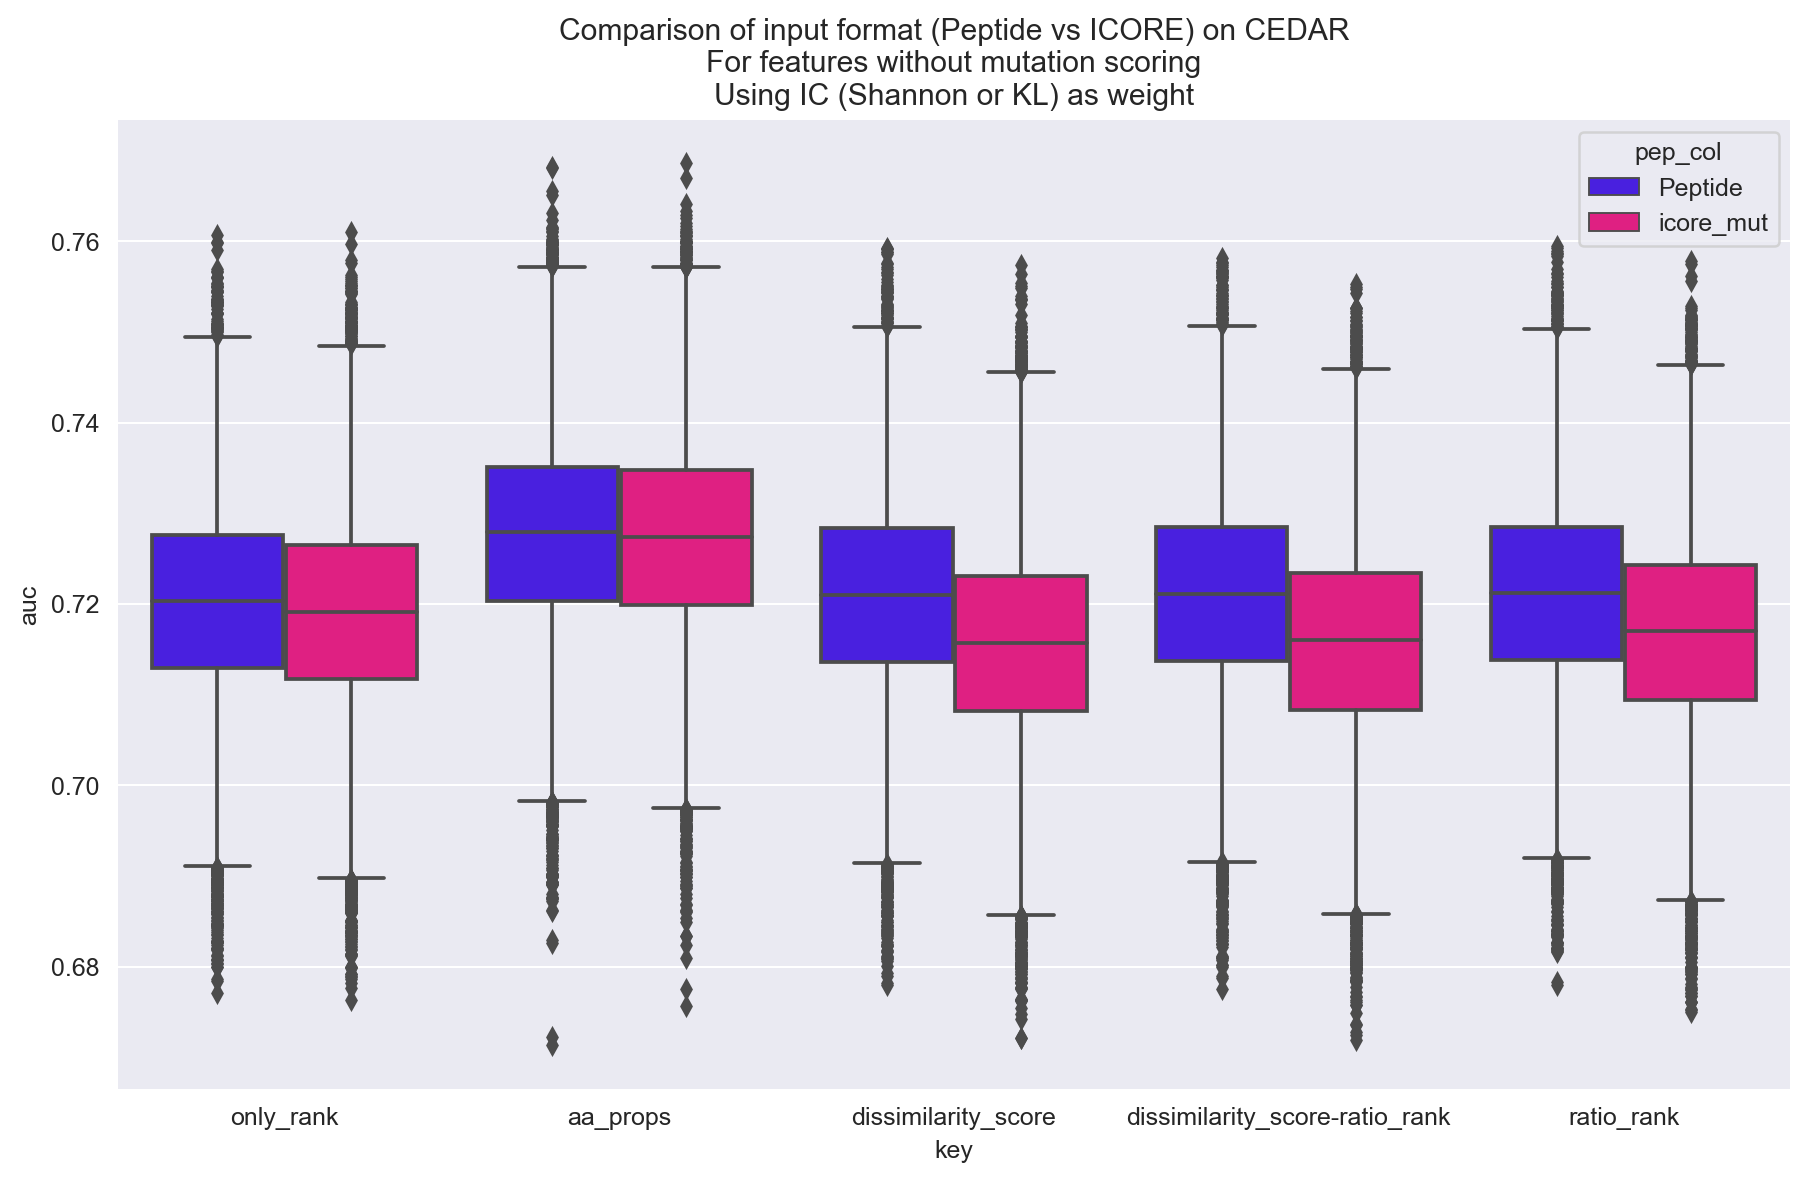

In [696]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="IC KL" or weight=="IC Shannon") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing IC (Shannon or KL) as weight')


Text(0.5, 1.0, 'Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')

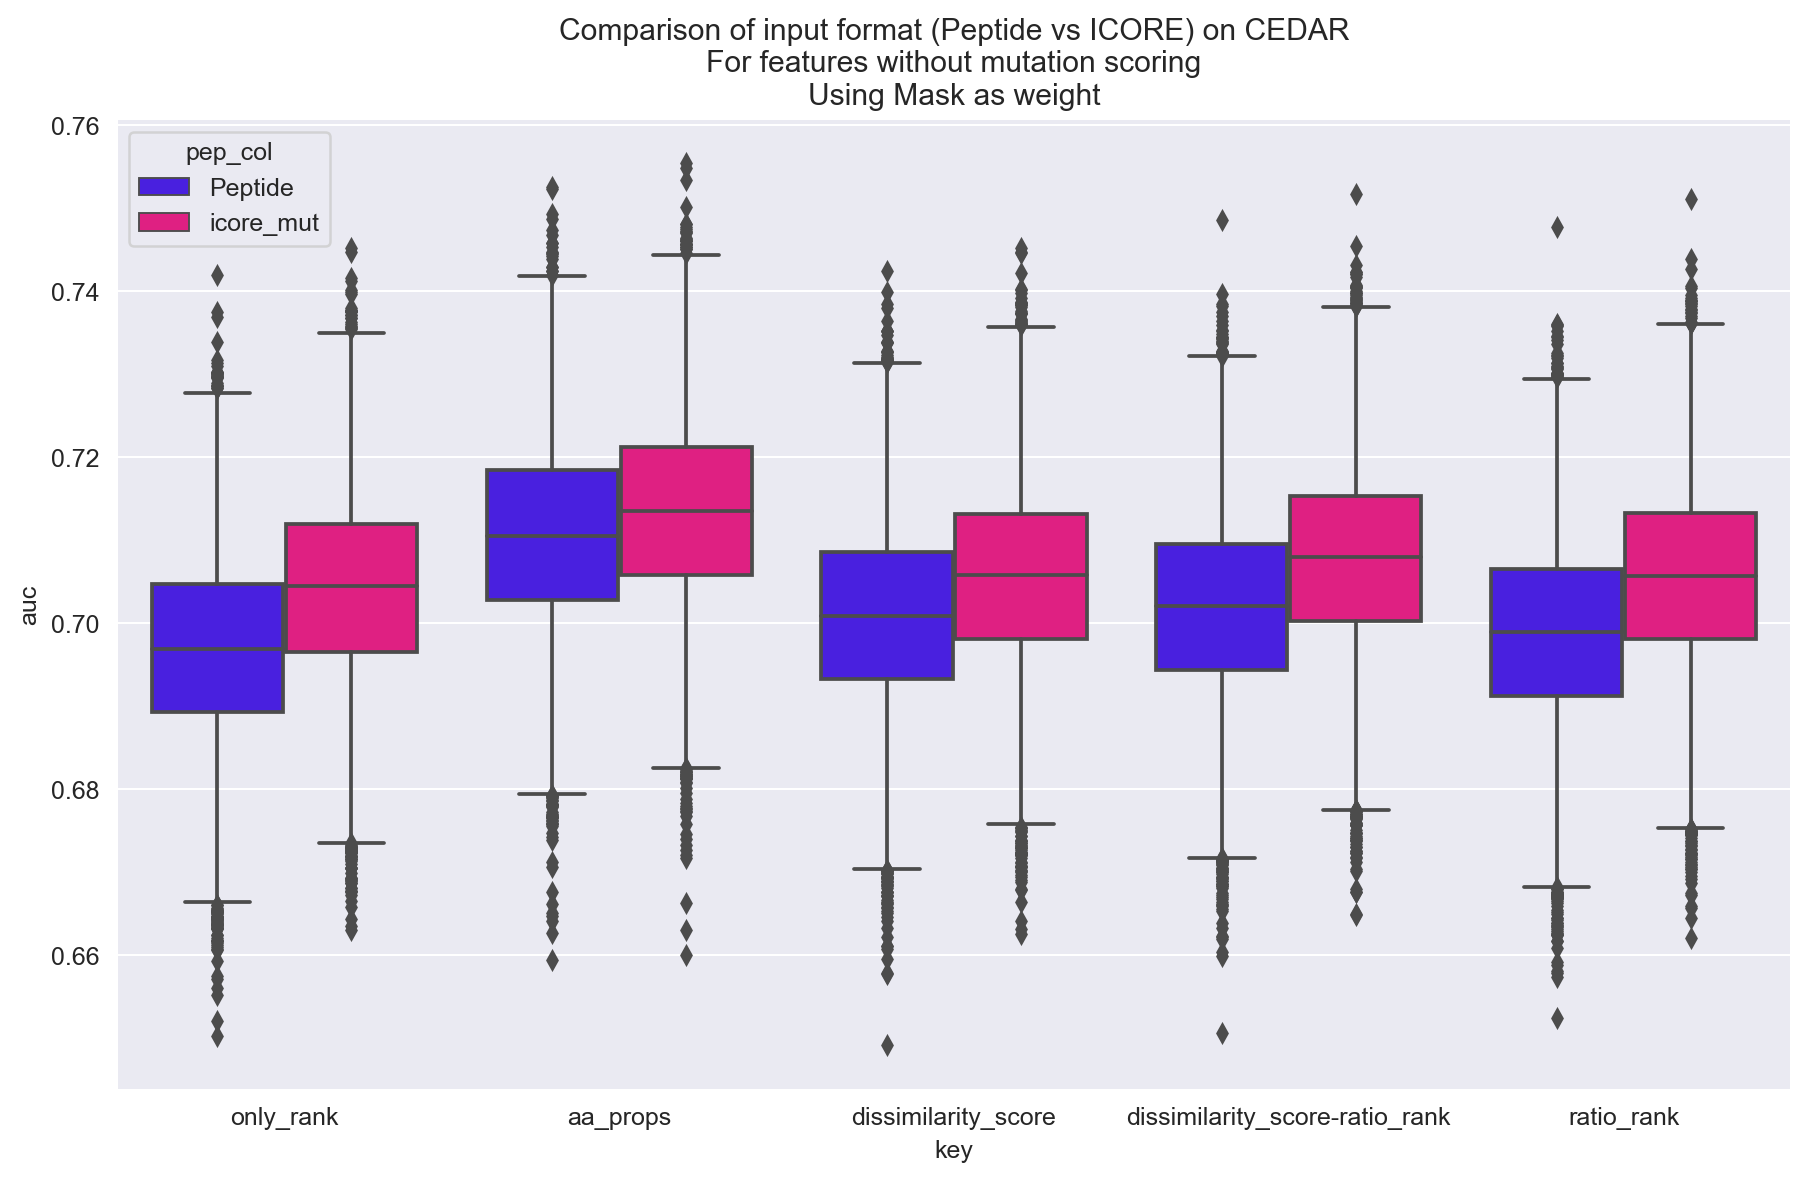

In [697]:
tmp_ = df_results.query('evalset=="CEDAR" and (weight=="(1–IC) Mask") and encoding=="onehot" and rank_col=="EL_rank_mut" and key in @base_keys')
f,a = plt.subplots(1,1, figsize=(12,7))
sns.boxplot(data=tmp_, x='key', y='auc', hue='pep_col')
plt.setp(a.collections, alpha=0.75)
a.set_title('Comparison of input format (Peptide vs ICORE) on CEDAR\nFor features without mutation scoring\nUsing Mask as weight')


## ROCs

In [33]:
display(top25_mean_cedar.head(1)[auc_cols])
display(top25_mean_prime.head(1)[auc_cols])
gb_reshape['mean_CEDAR_PRIME_AUC'] = .5*(gb_reshape['mean_AUC_cedar']+gb_reshape['mean_AUC_prime'])
gb_reshape['mean_CEDAR_PRIME_AUC_weighted'] = 0.66*gb_reshape['mean_AUC_cedar']+0.33*gb_reshape['mean_AUC_prime']
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC',ascending=False).head(1)[auc_cols])
display(gb_reshape.sort_values('mean_CEDAR_PRIME_AUC_weighted',ascending=False).head(1)[auc_cols])

max_AUC_cedar  mean_AUC_cedar  \
encoding weight pep_col rank_col    key                                       
onehot   IC KL  Peptide EL_rank_mut aa_props       0.768095        0.727865   

                                              mean_PRAUC_cedar  max_AUC_prime  \
encoding weight pep_col rank_col    key                                         
onehot   IC KL  Peptide EL_rank_mut aa_props          0.418566       0.746858   

                                              mean_AUC_prime  mean_PRAUC_prime  
encoding weight pep_col rank_col    key                                         
onehot   IC KL  Peptide EL_rank_mut aa_props        0.654866           0.07787

max_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                      
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score       0.742955   

                                                                                  mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score        0.699172   

                                                                                  mean_PRAUC_cedar  \
encoding weight      pep_col rank_col    key                                                         
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score          0.375032   

                                                                                  max_AUC_prime  \
encoding weight      pep_col rank_col    key                                                      
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score       0.799025   

                                                                                  mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                       
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score        0.715095   

                                                                                  mean_PRAUC_prime  
encoding weight      pep_col rank_col    key                                                        
onehot   (1–IC) Mask Peptide EL_rank_mut core_blsm_mut_score-core_mutation_score          0.112765

max_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                                 
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...       0.743066   

                                                                                             mean_AUC_cedar  \
encoding weight      pep_col rank_col    key                                                                  
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.701101   

                                                                                             mean_PRAUC_cedar  \
encoding weight      pep_col rank_col    key                                                                    
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.377558   

                                                                                             max_AUC_prime  \
encoding weight      pep_col rank_col    key                                                                 
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...       0.797696   

                                                                                             mean_AUC_prime  \
encoding weight      pep_col rank_col    key                                                                  
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...        0.714108   

                                                                                             mean_PRAUC_prime  
encoding weight      pep_col rank_col    key                                                                   
onehot   (1–IC) Mask Peptide EL_rank_mut dissimilarity_score-core_blsm_mut_score-core_mu...          0.118509

max_AUC_cedar  \
encoding weight    pep_col   rank_col    key                                                 
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score       0.761354   

                                                                             mean_AUC_cedar  \
encoding weight    pep_col   rank_col    key                                                  
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score        0.718283   

                                                                             mean_PRAUC_cedar  \
encoding weight    pep_col   rank_col    key                                                    
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score          0.405697   

                                                                             max_AUC_prime  \
encoding weight    pep_col   rank_col    key                                                 
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score        0.77465   

                                                                             mean_AUC_prime  \
encoding weight    pep_col   rank_col    key                                                  
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score        0.681639   

                                                                             mean_PRAUC_prime  
encoding weight    pep_col   rank_col    key                                                   
onehot   (1–IC) KL icore_mut EL_rank_mut dissimilarity_score-blsm_mut_score          0.112234

In [725]:
dir_ = '../output/221102_new_core_mutscores/bootstrapping/'
# Best cedar cdt
best_cedar_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.pkl')
best_cedar_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.pkl')
# best prime cdt
best_prime_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.pkl')
best_prime_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.pkl')
# best mean cdt
best_mean_cdt_cedar_roc =  pkl_load(f'{dir_}cedar_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_blsm_mut_score-core_mutation_score.pkl')
best_mean_cdt_prime_roc =  pkl_load(f'{dir_}prime_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_blsm_mut_score-core_mutation_score.pkl')
# best weighted mean cdt
best_weighted_cdt_cedar_roc = pkl_load(f'{dir_}cedar_mean_rocs_onehot_KL_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.pkl')
best_weighted_cdt_prime_roc = pkl_load(f'{dir_}prime_mean_rocs_onehot_KL_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.pkl')

In [752]:
dir_ = '../output/221102_new_core_mutscores/raw/'
# Best cedar cdt
best_cedar_cdt_cedar_preds = pd.read_csv(f'{dir_}cedar_preds_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.csv')
best_cedar_cdt_prime_preds = pd.read_csv(f'{dir_}prime_preds_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.csv')
# best prime cdt
best_prime_cdt_cedar_preds = pd.read_csv(f'{dir_}cedar_preds_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.csv')
best_prime_cdt_prime_preds = pd.read_csv(f'{dir_}prime_preds_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.csv')
# best mean cdt
best_mean_cdt_cedar_preds =  pd.read_csv(f'{dir_}cedar_preds_onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_blsm_mut_score-core_mutation_score.csv')
best_mean_cdt_prime_preds =  pd.read_csv(f'{dir_}prime_preds_onehot_Mask_Peptide_EL_rank_mut_dissimilarity_score-core_blsm_mut_score-core_mutation_score.csv')
# best weighted mean cdt
best_weighted_cdt_cedar_preds = pd.read_csv(f'{dir_}cedar_preds_onehot_KL_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.csv')
best_weighted_cdt_prime_preds = pd.read_csv(f'{dir_}prime_preds_onehot_KL_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.csv')

In [72]:
def get_roc(df, score, binder, anchor_mutation):
    if binder is not None and anchor_mutation is not None:
        df = df.query('binder==@binder and anchor_mutation==@anchor_mutation').copy()
    try:
        fpr,tpr,_ = roc_curve(df.agg_label.values, df[score].values)
        auc = roc_auc_score(df.agg_label.values, df[score].values)
        auc01 = roc_auc_score(df.agg_label.values, df[score].values, max_fpr=0.1)
    except KeyError:
        fpr,tpr,_ = roc_curve(df.agg_label.values, df['mean_pred'].values)
        auc = roc_auc_score(df.agg_label.values, df['mean_pred'].values)
        auc01 = roc_auc_score(df.agg_label.values, df[score].values, max_fpr=0.1)
    return fpr, tpr, auc, auc01, len(df)

In [ ]:
for binder in ['Improved', 'Conserved']:
    for anchor_mutation in [True, False]:
        for condition, df_ced, df_pr in zip(['BestCedar', 'BestPrime', 'BestMean', 'BestWeighted'],
                                            [best_cedar_cdt_cedar_preds, best_prime_cdt_cedar_preds, best_mean_cdt_cedar_preds, best_weighted_cdt_cedar_preds],
                                            
        

Text(0, 0.5, 'TPR')

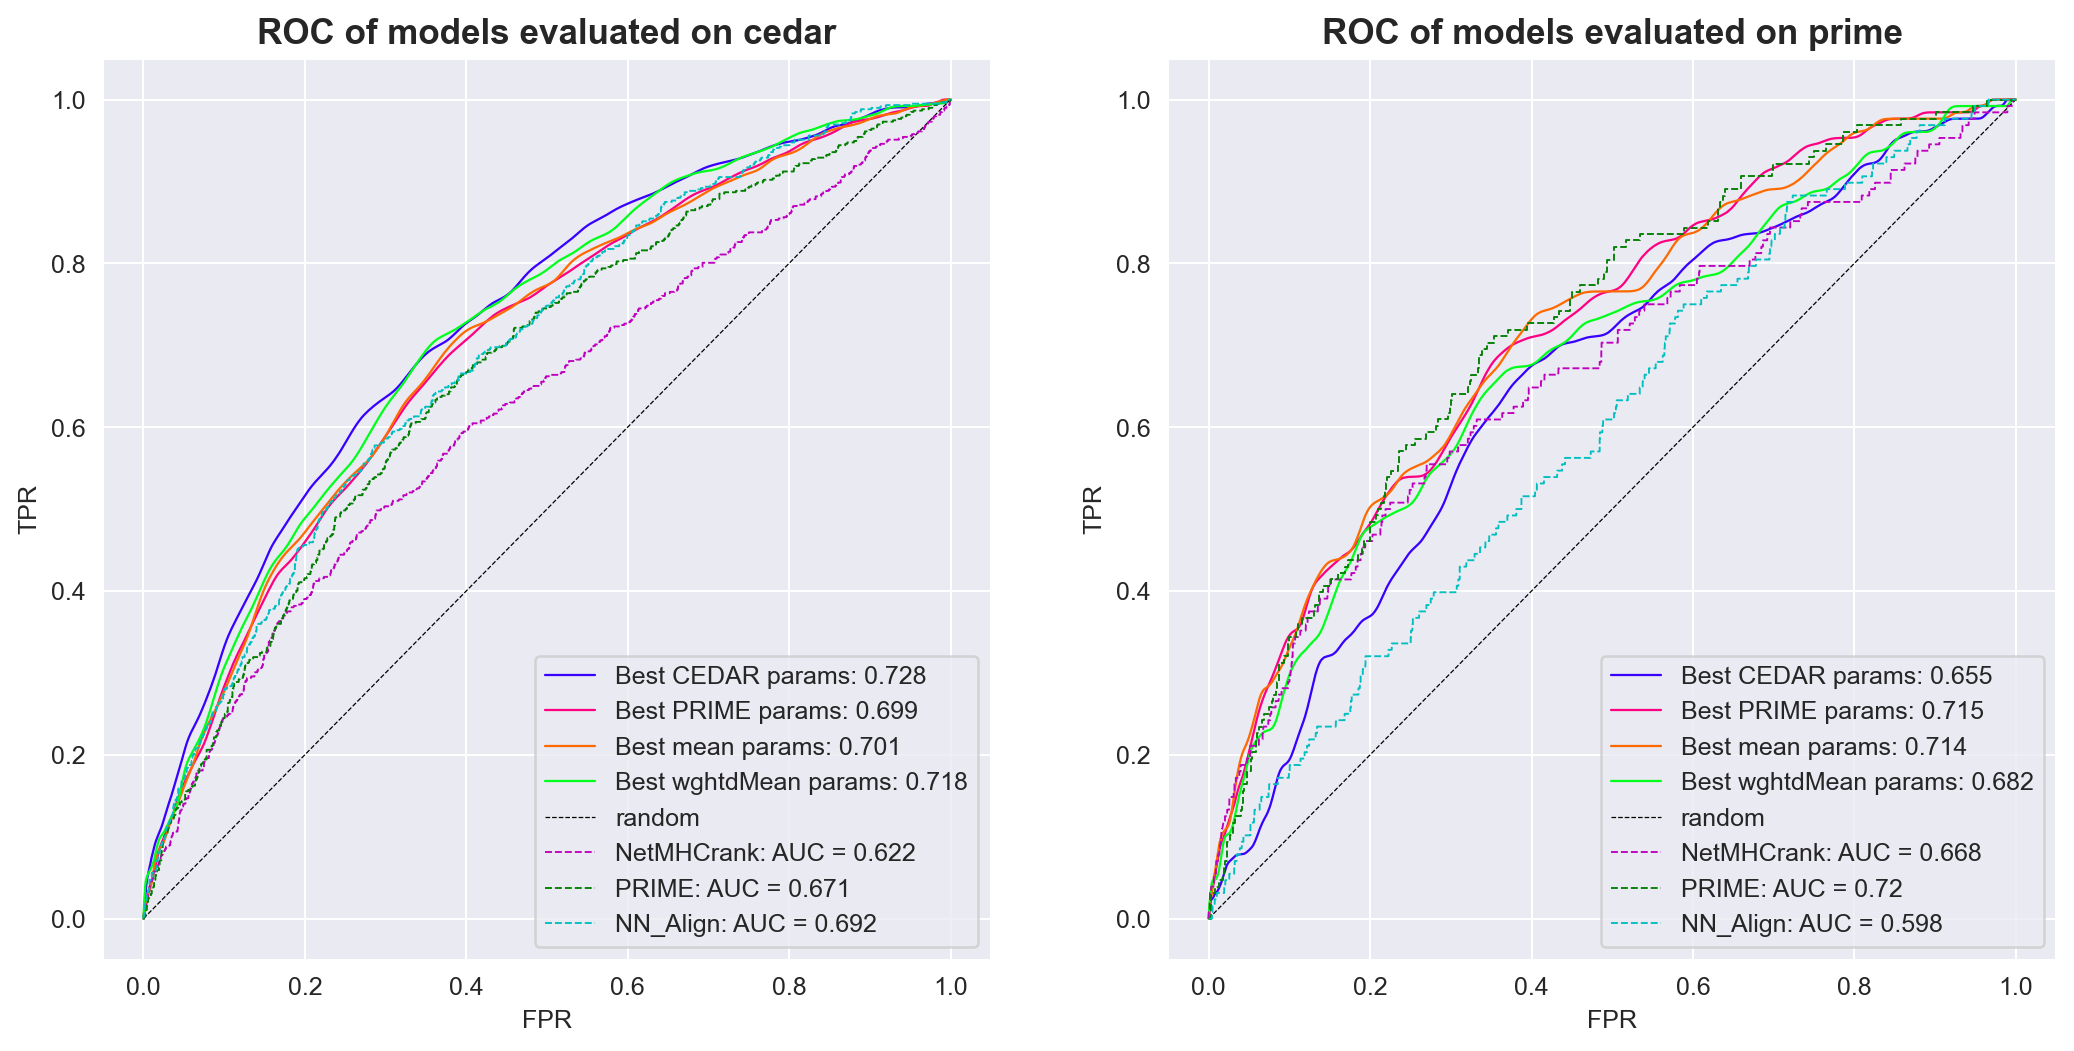

In [739]:
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(14,6.5))
# CEDAR roc
sns.lineplot(x=best_cedar_cdt_cedar_roc[0], y=best_cedar_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best CEDAR params: {round(best_cedar_cdt_cedar_roc[-1],3)}', ax=a[0])

sns.lineplot(x=best_prime_cdt_cedar_roc[0], y=best_prime_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best PRIME params: {round(best_prime_cdt_cedar_roc[-1],3)}', ax=a[0])

sns.lineplot(x=best_mean_cdt_cedar_roc[0], y=best_mean_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best mean params: {round(best_mean_cdt_cedar_roc[-1],3)}', ax=a[0])

sns.lineplot(x=best_weighted_cdt_cedar_roc[0], y=best_weighted_cdt_cedar_roc[1], linewidth=0.9,
             label=f'Best wghtdMean params: {round(best_weighted_cdt_cedar_roc[-1],3)}', ax=a[0])

a[0].plot([0,1],[0,1],ls='--',lw=0.5,c='k', label='random')
plot_related_baseline_roc(axis=a[0], dataset=new_cedar_baseline)
a[0].legend(loc='lower right')
a[0].set_title('ROC of models evaluated on cedar', fontweight='semibold',fontsize=14)
a[0].set_xlabel('FPR')
a[0].set_ylabel('TPR')

# PRIME roc
sns.lineplot(x=best_cedar_cdt_prime_roc[0], y=best_cedar_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best CEDAR params: {round(best_cedar_cdt_prime_roc[-1],3)}', ax=a[1])

sns.lineplot(x=best_prime_cdt_prime_roc[0], y=best_prime_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best PRIME params: {round(best_prime_cdt_prime_roc[-1],3)}', ax=a[1])


sns.lineplot(x=best_mean_cdt_prime_roc[0], y=best_mean_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best mean params: {round(best_mean_cdt_prime_roc[-1],3)}', ax=a[1])

sns.lineplot(x=best_weighted_cdt_prime_roc[0], y=best_weighted_cdt_prime_roc[1], linewidth=0.9,
             label=f'Best wghtdMean params: {round(best_weighted_cdt_prime_roc[-1],3)}', ax=a[1])

a[1].plot([0,1],[0,1],ls='--',lw=0.5,c='k', label='random')
plot_related_baseline_roc(axis=a[1], dataset=new_prime_baseline)
a[1].legend(loc='lower right')
a[1].set_title('ROC of models evaluated on prime', fontweight='semibold',fontsize=14)
a[1].set_xlabel('FPR')
a[1].set_ylabel('TPR')


# Check performance of best params on Ibel's data

In [35]:
from src.mutation_tools import get_anchor

# Need to rescore these peptides and get their icore/cores
ibel_neoepi = pd.read_csv('../data/mutant/ibel_neoepitopes_cio_mhc_25aa.csv', sep = '\t')
# Saving as seq
ibel_neoepi['seq_id'] = [f'seq_{i}' for i in range(len(ibel_neoepi))]
with open('../../netmhcpan/score_shift/data/ibel_neoepi_mut.fa', 'w') as f:
    for i, row in ibel_neoepi.iterrows():
        f.write(f'>{row["seq_id"]}\n')
        f.write(f'{row["Mut_peptide"]}\n')
with open('../../netmhcpan/score_shift/data/ibel_neoepi_wt.fa', 'w') as f:
    for i, row in ibel_neoepi.iterrows():
        f.write(f'>{row["seq_id"]}\n')
        f.write(f'{row["Norm_peptide"]}\n')

In [826]:
','.join(sorted(ibel_neoepi.HLA_allele.str.replace(':','').unique()))

'HLA-A0101,HLA-A0201,HLA-A0301,HLA-A1101,HLA-A2501,HLA-A3101,HLA-B0702,HLA-B1801,HLA-B5101,HLA-B5701,HLA-C0501,HLA-C0602,HLA-C0701,HLA-C0702,HLA-C1502'

## Re-rank

In [838]:
# FOR CEDAR
# Read
ibel_neoepi['HLA'] = ibel_neoepi.HLA_allele.str.replace(':','')
ibel_mutant_xls = read_xls_parse_shift('../../netmhcpan/score_shift/output/ibel_neoepi_mut.fa.xls')
ibel_wt_xls = read_xls_parse_shift('../../netmhcpan/score_shift/output/ibel_neoepi_wt.fa.xls')
# Parse-merge
new_ibel_mut = pipeline_xls(ibel_neoepi, ibel_mutant_xls, xls_suffix='_mut')
new_ibel_wt = pipeline_xls(ibel_neoepi, ibel_wt_xls, xls_suffix='_wt')
# merged mut-wt
common_cols = [x for x in new_ibel_mut.columns if x in new_ibel_wt.columns]
ibel_related_merged = new_ibel_mut.merge(new_ibel_wt,
                                 left_on=common_cols,
                                 right_on=common_cols)

In [853]:
ibel_related_merged.rename(columns={'Mut_peptide':'Peptide', 
                                    'Norm_peptide':'wild_type'}, inplace=True)
ibel_related_merged['len'] = ibel_related_merged['Peptide'].apply(len)

## get scores

In [842]:
# Saving peps for 1-similarity computation
ibel_related_merged[['Peptide_mut', 'Peptide_wt']].to_csv('../../kern_dist/data/ibel_mut_wt_REDO.pep',
                                                     sep='\t', index=False, header=False)

In [844]:
ibel_related_merged_distance = pd.read_csv('../../kern_dist/out/ibel_mut_wt_REDO.pep_kerndist.out', header=None).rename(columns={0:'mut_wt_sim'})
ibel_related_merged_distance['dissimilarity_score']=1-ibel_related_merged_distance['mut_wt_sim']
ibel_related_merged = ibel_related_merged.reset_index(drop=True).merge(ibel_related_merged_distance, left_index=True, right_index=True)

In [851]:
from src.mutation_tools import get_anchor, get_anchor_mutation, get_binder_type, get_blsm_mutation_score, get_mutation_pos, get_mutation_score

In [854]:
ibel_related_merged['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
ibel_related_merged['mhc_anchor'] = ibel_related_merged.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
ibel_related_merged['mutation_position'] = ibel_related_merged.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
ibel_related_merged['anchor_mutation'] = ibel_related_merged.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
ibel_related_merged['core_mutation_position'] = ibel_related_merged.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
ibel_related_merged['binder'] = ibel_related_merged.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
ibel_related_merged['ratio_rank'] = ibel_related_merged['EL_rank_wt']/ibel_related_merged['EL_rank_mut']
ibel_related_merged['mutation_score'] = ibel_related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
ibel_related_merged['blsm_mut_score'] = ibel_related_merged.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

ibel_related_merged['core_mutation_score'] = ibel_related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
ibel_related_merged['core_blsm_mut_score'] = ibel_related_merged.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)

In [49]:
ibel_related_merged['agg_label'] = ibel_related_merged['Target'].values
ibel_related_merged.to_csv('../data/mutant/ibel_neoepitopes_scored_merged.csv', index=False)

In [50]:
ibel_related_merged = pd.read_csv('../data/mutant/ibel_neoepitopes_scored_merged.csv')

## train/eval

### fct def

In [46]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing
import itertools
from src.data_processing import get_aa_properties, get_mutation_dataset
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
ibel_related_merged, props_col = get_aa_properties(ibel_related_merged)

In [47]:
def bootstrap_wrapper(y_score, y_true, seed):
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]

    try:
        test_results = get_metrics(sample_true, sample_score)
    except:
        return pd.DataFrame(), (None, None, None, None)

    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper,
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in
                                     tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1, leave=False))

    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output if x[1][0] is not None])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve


def assert_encoding_kwargs(encoding_kwargs, mode_eval=False):
    """
    Assertion / checks for encoding kwargs and verify all the necessary key-values 
    are in
    """
    # Making a deep copy since dicts are mutable between fct calls
    encoding_kwargs = deepcopy(encoding_kwargs)
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    if mode_eval:
        if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
            if 'seq_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'Peptide'})
            if 'hla_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'hla_col': 'HLA'})
            if 'target_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'target_col': 'agg_label'})
            if 'rank_col' not in encoding_kwargs.keys():
                encoding_kwargs.update({'seq_col': 'trueHLA_EL_rank'})

        # This KWARGS not needed in eval mode since I'm using Pipeline and Wrapper
        del encoding_kwargs['standardize']
    return encoding_kwargs


def get_predictions(df, models, ics_dict, encoding_kwargs):
    """
    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """

    df = df.copy()

    # HERE NEED TO DO SWITCH CASES
    x, y = get_mutation_dataset(df, ics_dict, **encoding_kwargs)

    # Take the first model in the list and get its class
    model_class = models[0].__class__

    # If model is a scikit-learn model, get pred prob
    # if issubclass(model_class, sklearn.base.BaseEstimator):
    average_predictions = [model.predict_proba(x)[:, 1] \
                           for model in models]

    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    # assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df


# TRAIN WITH PARALLEL WRAPPER
def parallel_inner_train_wrapper(train_dataframe, x_test, base_model, ics_dict,
                                 encoding_kwargs, standardize, fold_out, fold_in):
    seed = fold_out * 10 + fold_in
    # Copy the base model, resets the seed
    model = sklearn.base.clone(base_model)
    model.set_params(random_state=seed)
    if standardize:
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])

    # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
    # Query subset dataframe and get encoded data and targets
    train = train_dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Get datasets
    x_train, y_train = get_mutation_dataset(train, ics_dict, **encoding_kwargs)
    x_valid, y_valid = get_mutation_dataset(valid, ics_dict, **encoding_kwargs)

    # Fit the model and append it to the list
    model.fit(x_train, y_train)

    # Get the prediction values on both the train and validation set
    y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
    y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
    # Get the metrics and save them
    train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
    valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
    y_pred_test = model.predict_proba(x_test)[:, 1]

    return model, train_metrics, valid_metrics, y_pred_test


def nested_kcv_train_mut(dataframe, base_model, ics_dict, encoding_kwargs: dict = None, n_jobs=None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    #
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test, y_test = get_mutation_dataset(test, ics_dict, **encoding_kwargs)
        # For a given fold, all the models that are trained should be appended to this list
        inner_folds = sorted([f for f in folds if f != fold_out])
        n_jobs = len(inner_folds) if n_jobs is None else n_jobs
        # Create the sub-dict and put the model into the models dict
        train_wrapper_ = partial(parallel_inner_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 base_model=base_model, ics_dict=ics_dict, encoding_kwargs=encoding_kwargs,
                                 standardize=std, fold_out=fold_out)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds,
                                                                         desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_tmp = [x[1] for x in output]
        valid_tmp = [x[2] for x in output]
        avg_prediction = [x[3] for x in output]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        train_metrics[fold_out] = {k: {'train': v_train,
                                       'valid': v_valid} for k, v_train, v_valid in
                                   zip(inner_folds, train_tmp, valid_tmp)}
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics


# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper(test_dataframe, models_list, ics_dict,
                          train_dataframe, encoding_kwargs, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_mut(test_dataframe, models_dict, ics_dict,
                                train_dataframe=None,
                                encoding_kwargs: dict = None,
                                concatenated=False, only_concat=False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        predictions_df
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)

    output = Parallel(n_jobs=8)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                    desc='Eval Folds',
                                                                    leave=False,
                                                                    position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df


### train

In [56]:
from copy import deepcopy
encoding_kwargs={'encoding':'onehot',
 'blosum_matrix':None,
 'max_len':12,
 'add_rank':True,
 'mask':False,
 'add_aaprop':False,
 'remove_pep':False,
 'standardize':True,
 'target_col':'agg_label'}

best_cedar='Inverted-KLXXPeptideXXEL_rank_mutXXaa_props'
best_prime='MaskXXPeptideXXEL_rank_mutXXcore_blsm_mut_score-core_mutation_score'
best_mean='MaskXXPeptideXXEL_rank_mutXXdissimilarity_score-core_blsm_mut_score-core_mutation_score'
best_weighted='KLXXicore_mutXXEL_rank_mutXXdissimilarity_score-blsm_mut_score'

best_kwarg_cedar = deepcopy(encoding_kwargs)
best_kwarg_prime = deepcopy(encoding_kwargs)
best_kwarg_mean = deepcopy(encoding_kwargs)
best_kwarg_weighted = deepcopy(encoding_kwargs)


ibel_all_results = {}
for name, params, kwargs in zip(['best_cedar','best_prime','best_mean','best_weighted'],
                                [best_cedar, best_prime, best_mean, best_weighted],
                                [best_kwarg_cedar, best_kwarg_prime, best_kwarg_mean, best_kwarg_weighted]):
    params = params.split('XX')
    ic = ics_shannon if 'Mask' in params[0] else ics_kl
    kwargs['invert'] = True if 'Inverted' in params[0] else False
    kwargs['seq_col'] = params[1]
    kwargs['rank_col'] = params[2]
    kwargs['mut_col'] = params[3].split('-') if params[3] != 'aa_props' else props_col
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    print('Training')
    trained_models, train_metrics, _ = nested_kcv_train_mut(cedar_related_newcore, model,
                                                            ics_dict=ic,
                                                            encoding_kwargs=kwargs,
                                                            n_jobs=8)
    ibel_results, ibel_preds = evaluate_trained_models_mut(ibel_related_merged, trained_models, ic, None,
                                                            kwargs, concatenated=True)
    
    ibel_all_results[name] = ibel_results['concatenated'], ibel_preds
    print(name, get_roc(ibel_preds, 'pred', None, None)[-2])

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_cedar 0.6030882352941176
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_prime 0.6598755656108597
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_mean 0.6550169683257918
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

best_weighted 0.6509671945701357


### getting prime baseline to compare to my results

In [61]:
ibel_related_merged['Peptide'].to_csv('../data/mutant/ibel_neoepi_pep.txt', index=False, header=False)

In [64]:
','.join(sorted(ibel_related_merged.HLA.str.replace('HLA-','').unique()))

'A0101,A0201,A0301,A1101,A2501,A3101,B0702,B1801,B5101,B5701,C0501,C0602,C0701,C0702,C1502'

In [65]:
ibel_prime_scores = pd.read_csv('../data/mutant/ibel_neoepi_primescore.txt', sep='\t', comment='#')

In [67]:
ibel_related_merged = ibel_related_merged.merge(ibel_prime_scores['Score_bestAllele'], left_index=True, right_index=True)

Text(0.5, 1.0, 'Performances of various params on Ibel Neoepi')

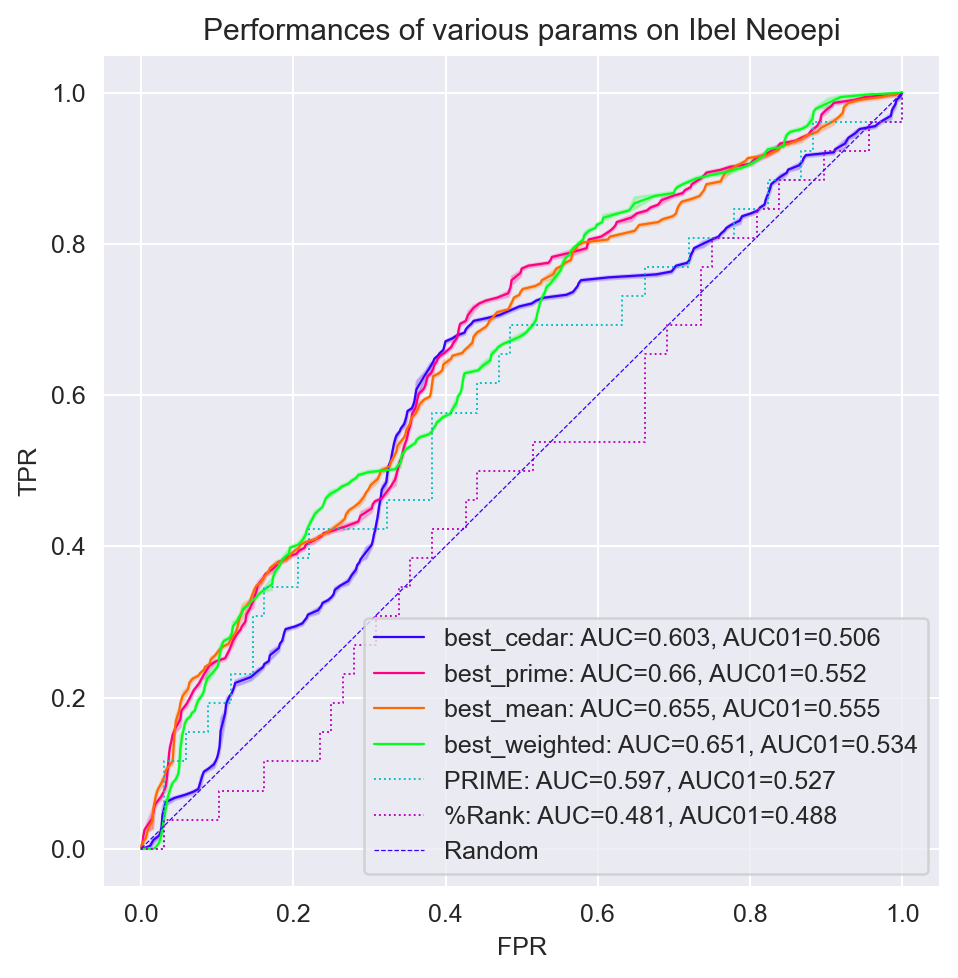

In [86]:
f,a = plt.subplots(1,1,figsize=(6,6))
sns.set_palette(HSV)
for k,v in ibel_all_results.items():
    auc = v[0]['auc']
    auc01 = v[0]['auc_01']
    roc = v[0]['roc_curve']
    sns.lineplot(x= roc[0], y= roc[1], linewidth=0.9, label=f'{k}: AUC={round(auc,3)}, AUC01={round(auc01,3)}')

prime_roc = get_roc(ibel_related_merged, 'Score_bestAllele', None, None)
a.plot(prime_roc[0], prime_roc[1], label=f'PRIME: AUC={round(prime_roc[2], 3)}, AUC01={round(prime_roc[3],3)}',
       lw=0.75, ls=':', c='c')


rank_roc = get_roc(ibel_related_merged, 'EL_rank_mut', None, None)
a.plot(rank_roc[0], rank_roc[1], label=f'%Rank: AUC={round(rank_roc[2], 3)}, AUC01={round(rank_roc[3],3)}',
       lw=0.75, ls=':', c='m')

a.plot([0,1],[0,1], label='Random', ls='--', lw=0.5)
a.legend(loc='lower right')
a.set_xlabel('FPR')
a.set_ylabel('TPR')
a.set_title('Performances of various params on Ibel Neoepi')

In [128]:
len(v[1])

940

In [129]:
concat.to_csv('../data/mutant/cedar_prime_concat.csv', index=False)